In [85]:
from massspecgym.data.datasets import MSnDataset, MassSpecDataset
from massspecgym.data.transforms import MolFingerprinter, SpecTokenizer
from massspecgym.data import MassSpecDataModule
from massspecgym.featurize import SpectrumFeaturizer

from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests
from scikit_posthocs import posthoc_dunn
from collections import defaultdict
from itertools import combinations
from typing import List
from scipy import stats
from math import comb
import numpy as np
import random
import pandas as pd
from typing import List, Dict, Tuple, Optional, Any

In [8]:
file_mgf = "/Users/macbook/CODE/Majer:MassSpecGym/data/MSn/20241211_msn_library_pos_all_lib_MSn.mgf"
split_file = "/Users/macbook/CODE/Majer:MassSpecGym/data/MSn/20241211_split.tsv"

In [9]:
config = {
    'features': ['binned_peaks'],
    'feature_attributes': {
        'binned_peaks': {
            'max_mz': 1,
            'bin_width': 1.0,
        },
    },
}

In [10]:
featurizer = SpectrumFeaturizer(config, mode='torch')

In [11]:
# Init hyperparameters
n_peaks = 60
fp_size = 4096
batch_size = 12

msn_dataset = MSnDataset(
    pth=file_mgf,
    featurizer=featurizer,
    mol_transform=MolFingerprinter(fp_size=fp_size),
    max_allowed_deviation=0.005
)

In [12]:
msn_dataset[0]

{'spec': Data(x=[14, 1005], edge_index=[2, 13]),
 'mol': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 'precursor_mz': tensor(347.1489),
 'adduct': '[M+H]+',
 'identifier': '0000002_0000000',
 'mol_freq': tensor(1.)}

## Spectra node similarities

In [13]:
def summarize_similarity_distribution_aggregated(scores: List[float]) -> dict:
    """
    Return mean, std, median, count for a list of float scores,
    ignoring NaNs.
    """
    arr = np.array(scores)
    arr = arr[~np.isnan(arr)]
    if len(arr) == 0:
        return {"mean": np.nan, "std": np.nan, "median": np.nan, "count": 0}
    return {
        "mean": float(np.mean(arr)),
        "std": float(np.std(arr)),
        "median": float(np.median(arr)),
        "count": len(arr)
    }

In [14]:
def summarize_similarity_distribution(scores: List[float], normality_alpha: float = 0.05) -> Dict[str, Any]:
    """
    Summarize similarity scores with extended statistics and normality tests.
    
    Parameters:
    - scores: List of similarity scores (floats)
    - normality_alpha: Significance level for normality tests
    
    Returns:
    - Dictionary with comprehensive statistics
    """
    arr = np.array(scores)
    arr = arr[~np.isnan(arr)]
    summary = {}
    
    if len(arr) == 0:
        summary = {
            "mean": np.nan,
            "std": np.nan,
            "median": np.nan,
            "count": 0,
            # "mode": np.nan,
            "q1": np.nan,
            "q3": np.nan,
            "IQR": np.nan,
            "range": np.nan,
            "skewness": np.nan,
            "kurtosis": np.nan,
            "ks_p": np.nan,
            "is_normal": False
        }
        return summary
    
    summary["mean"] = float(np.mean(arr))
    summary["std"] = float(np.std(arr))
    summary["median"] = float(np.median(arr))
    summary["count"] = len(arr)
    # summary["mode"] = float(stats.mode(arr).mode[0])
    summary["q1"] = float(np.percentile(arr, 25))
    summary["q3"] = float(np.percentile(arr, 75))
    summary["IQR"] = summary["q3"] - summary["q1"]
    summary["range"] = float(np.ptp(arr))
    summary["skewness"] = float(stats.skew(arr))
    summary["kurtosis"] = float(stats.kurtosis(arr))
    
    # Kolmogorov-Smirnov Test against normal distribution
    ks_stat, ks_p = stats.kstest(arr, 'norm', args=(summary["mean"], summary["std"]))
    
    summary["ks_p"] = ks_p
    
    # Determine normality based on KS test
    if ks_p >= normality_alpha:
        is_normal = True
    else:
        is_normal = False
    
    summary["is_normal"] = is_normal
    
    return summary

In [15]:
# def perform_statistical_tests(all_level_sims: Dict[Tuple[int, int], List[float]], alpha: float = 0.05) -> List[Dict[str, Any]]:
#     """
#     Perform statistical tests between all level pairs.
#     
#     Parameters:
#     - all_level_sims: Dict mapping level pairs to list of similarity scores
#     - alpha: Significance level
#     
#     Returns:
#     - List of dictionaries containing comparison results
#     """
#     # Summarize distributions and assess normality
#     summaries = {level_pair: summarize_similarity_distribution(vals) 
#                 for level_pair, vals in all_level_sims.items()}
#     
#     # Prepare for pairwise comparisons
#     level_pairs = list(all_level_sims.keys())
#     comparison_results = []
#     
#     # Total number of comparisons for Bonferroni
#     m = comb(len(level_pairs), 2) if len(level_pairs) > 1 else 0
#     if m > 0:
#         adjusted_alpha = alpha / m
#     else:
#         adjusted_alpha = alpha
#     
#     # Perform pairwise comparisons
#     for (lvlA1, lvlB1), (lvlA2, lvlB2) in combinations(level_pairs, 2):
#         # Define comparison labels
#         group1_label = f"{lvlA1}-{lvlB1}"
#         group2_label = f"{lvlA2}-{lvlB2}"
#         
#         scores1 = all_level_sims[(lvlA1, lvlB1)]
#         scores2 = all_level_sims[(lvlA2, lvlB2)]
#         
#         summary1 = summaries[(lvlA1, lvlB1)]
#         summary2 = summaries[(lvlA2, lvlB2)]
#         
#         # Decide which test to use based on normality
#         if summary1["is_normal"] and summary2["is_normal"]:
#             # Perform Welch's t-test
#             t_stat, p_val = stats.ttest_ind(scores1, scores2, equal_var=False, nan_policy='omit')
#             test_used = "Welch's t-test"
#         else:
#             # Perform Mann-Whitney U test
#             t_stat, p_val = stats.mannwhitneyu(scores1, scores2, alternative='two-sided')
#             test_used = "Mann-Whitney U test"
#         
#         # Determine significance with Bonferroni correction
#         significant = p_val < adjusted_alpha
#         
#         comparison_results.append({
#             "Group 1": group1_label,
#             "Group 2": group2_label,
#             "Test Used": test_used,
#             "Statistic": t_stat,
#             "p-value": p_val,
#             "Significant": significant,
#             "Adjusted Alpha": adjusted_alpha
#         })
#     
#     return comparison_results

In [1]:

def report_comparison_results(comparison_results: List[Dict[str, Any]]):
    """
    Print comparison results in a structured format.
    
    Parameters:
    - comparison_results: List of dictionaries containing comparison details
    """
    if not comparison_results:
        print("No comparisons to report.")
        return
    
    df = pd.DataFrame(comparison_results)
    
    # Rearrange columns for clarity
    df = df[[
        "Group 1", 
        "Group 2", 
        "Test Used", 
        "Statistic", 
        "p-value", 
        "Adjusted Alpha", 
        "Significant"
    ]]
    
    # Sort by p-value
    df = df.sort_values(by="p-value")
    
    # Display the DataFrame
    print(df.to_string(index=False))
    
def downsample_all_level_sims(all_level_sims_hung, desired_size=None, random_seed=42):
    """
    Downsample each group in the all_level_sims_hung dictionary to the desired_size.
    If desired_size is not specified, it defaults to the size of the smallest group.
    
    Parameters:
    - all_level_sims_hung (dict): Dictionary with Level_Pair tuples as keys and lists of similarity scores as values.
    - desired_size (int, optional): The number of samples to retain in each group.
                                    Defaults to the size of the smallest group.
    - random_seed (int, optional): Seed for reproducibility.
    
    Returns:
    - downsampled_dict (dict): Dictionary with downsampled similarity scores.
    """
    # Set the random seed for reproducibility
    random.seed(random_seed)
    
    # Determine the default desired_size as the size of the smallest group
    if desired_size is None:
        desired_size = min(len(scores) for scores in all_level_sims_hung.values())
        print(f"Desired sample size per group set to the smallest group size: {desired_size}")
    else:
        print(f"Desired sample size per group set to: {desired_size}")
    
    downsampled_dict = {}
    for pair, scores in all_level_sims_hung.items():
        current_size = len(scores)
        if current_size > desired_size:
            # Randomly sample without replacement
            sampled_scores = random.sample(scores, desired_size)
            downsampled_dict[pair] = sampled_scores
            print(f"Downsampled group {pair} from {current_size} to {desired_size}")
        elif current_size < desired_size:
            # Optionally, handle groups smaller than desired_size
            # For now, we'll keep them as is
            downsampled_dict[pair] = scores
            print(f"Group {pair} has only {current_size} samples; no downsampling performed.")
        else:
            # No downsampling needed
            downsampled_dict[pair] = scores
            print(f"Group {pair} already has {desired_size} samples; no downsampling performed.")
    
    return downsampled_dict

NameError: name 'List' is not defined

In [17]:
def perform_statistical_tests_with_effect_sizes(all_level_sims: Dict[Tuple[int, int], List[float]], alpha: float = 0.05) -> List[Dict[str, Any]]:
    """
    Perform statistical tests between all level pairs and calculate effect sizes.
    
    Parameters:
    - all_level_sims: Dict mapping level pairs to list of similarity scores
    - alpha: Significance level
    
    Returns:
    - List of dictionaries containing comparison results including effect sizes
    """
    # Summarize distributions and assess normality
    summaries = {level_pair: summarize_similarity_distribution(vals) 
                for level_pair, vals in all_level_sims.items()}
    
    # Prepare for pairwise comparisons
    level_pairs = list(all_level_sims.keys())
    comparison_results = []
    
    # Total number of comparisons for Bonferroni
    m = comb(len(level_pairs), 2) if len(level_pairs) > 1 else 0
    if m > 0:
        adjusted_alpha = alpha / m
    else:
        adjusted_alpha = alpha
    
    # Perform pairwise comparisons
    for (lvlA1, lvlB1), (lvlA2, lvlB2) in combinations(level_pairs, 2):
        # Define comparison labels
        group1_label = f"{lvlA1}-{lvlB1}"
        group2_label = f"{lvlA2}-{lvlB2}"
        
        scores1 = all_level_sims[(lvlA1, lvlB1)]
        scores2 = all_level_sims[(lvlA2, lvlB2)]
        
        summary1 = summaries[(lvlA1, lvlB1)]
        summary2 = summaries[(lvlA2, lvlB2)]
        
        # Decide which test to use based on normality
        if summary1["is_normal"] and summary2["is_normal"]:
            # Perform Welch's t-test
            t_stat, p_val = stats.ttest_ind(scores1, scores2, equal_var=False, nan_policy='omit')
            test_used = "Welch's t-test"
            # Calculate Cohen's d
            mean_diff = summary1["mean"] - summary2["mean"]
            pooled_var = ((summary1["std"]**2) / summary1["count"] + (summary2["std"]**2) / summary2["count"])
            pooled_std = np.sqrt(pooled_var)
            cohen_d = mean_diff / pooled_std
            effect_size = cohen_d
            effect_size_label = "Cohen's d"
        else:
            # Perform Mann-Whitney U test
            u_stat, p_val = stats.mannwhitneyu(scores1, scores2, alternative='two-sided')
            test_used = "Mann-Whitney U test"
            # Calculate Rank-Biserial Correlation as effect size
            n1 = len(scores1)
            n2 = len(scores2)
            rbc = 1 - (2 * u_stat) / (n1 * n2)
            effect_size = rbc
            effect_size_label = "Rank-Biserial Correlation"
        
        # Determine significance with Bonferroni correction
        significant = p_val < adjusted_alpha
        
        comparison_results.append({
            "Group 1": group1_label,
            "Group 2": group2_label,
            "Test Used": test_used,
            "Statistic": t_stat if test_used == "Welch's t-test" else u_stat,
            "p-value": p_val,
            "Adjusted Alpha": adjusted_alpha,
            "Significant": significant,
            "Effect Size": effect_size,
            "Effect Size Type": effect_size_label
        })
    
    return comparison_results

def report_comparison_results_with_effect_sizes(comparison_results: List[Dict[str, Any]]):
    """
    Print comparison results with effect sizes in a structured format.
    
    Parameters:
    - comparison_results: List of dictionaries containing comparison details
    """
    if not comparison_results:
        print("No comparisons to report.")
        return
    
    df = pd.DataFrame(comparison_results)
    
    # Rearrange columns for clarity
    df = df[[
        "Group 1", 
        "Group 2", 
        "Test Used", 
        "Statistic", 
        "p-value", 
        "Adjusted Alpha",
        "Significant",
        "Effect Size",
        "Effect Size Type"
    ]]
    
    # Sort by p-value
    df = df.sort_values(by="p-value")
    
    # Display the DataFrame
    print(df.to_string(index=False))

In [18]:
def compare_target_group_against_others(
    all_level_sims: Dict[Tuple[int, int], List[float]],
    target_level_pair: Tuple[int, int],
    alpha: float = 0.05
) -> pd.DataFrame:
    """
    Compare the target level pair's similarity scores against all other level pairs.
    
    Parameters:
    - all_level_sims: Dict mapping level pairs to list of similarity scores
    - target_level_pair: Tuple indicating the target level pair (e.g., (2,2))
    - alpha: Significance level
    
    Returns:
    - Pandas DataFrame with comparison results
    """
    target_scores = all_level_sims.get(target_level_pair, [])
    if not target_scores:
        raise ValueError(f"No similarity scores found for target level pair {target_level_pair}")
    
    # Summarize the target group
    summary_target = summarize_similarity_distribution(target_scores)
    
    comparison_results = []
    
    # Number of comparisons for Bonferroni correction
    other_level_pairs = [lp for lp in all_level_sims.keys() if lp != target_level_pair]
    m = len(other_level_pairs)
    if m == 0:
        raise ValueError("No other level pairs to compare against.")
    adjusted_alpha = alpha / m  # Bonferroni correction
    
    # Iterate over all other level pairs
    for level_pair in other_level_pairs:
        other_scores = all_level_sims[level_pair]
        summary_other = summarize_similarity_distribution(other_scores)
        
        # Decide which test to use based on normality
        if summary_target["is_normal"] and summary_other["is_normal"]:
            # Perform Welch's t-test
            t_stat, p_val = stats.ttest_ind(target_scores, other_scores, equal_var=False, nan_policy='omit')
            test_used = "Welch's t-test"
            # Calculate Cohen's d
            mean_diff = summary_target["mean"] - summary_other["mean"]
            pooled_var = ((summary_target["std"]**2) / summary_target["count"] + 
                         (summary_other["std"]**2) / summary_other["count"])
            pooled_std = np.sqrt(pooled_var)
            cohen_d = mean_diff / pooled_std
            effect_size = cohen_d
            effect_size_label = "Cohen's d"
        else:
            # Perform Mann-Whitney U test
            try:
                u_stat, p_val = stats.mannwhitneyu(target_scores, other_scores, alternative='two-sided')
            except ValueError as e:
                # Handle cases where all values are identical
                u_stat, p_val = np.nan, np.nan
            test_used = "Mann-Whitney U test"
            # Calculate Rank-Biserial Correlation as effect size
            if not np.isnan(u_stat):
                n1 = len(target_scores)
                n2 = len(other_scores)
                rbc = 1 - (2 * u_stat) / (n1 * n2)
            else:
                rbc = np.nan
            effect_size = rbc
            effect_size_label = "Rank-Biserial Correlation"
        
        # Determine significance with Bonferroni correction
        significant = p_val < adjusted_alpha if not np.isnan(p_val) else False
        
        comparison_results.append({
            "Target Group": f"{target_level_pair}",
            "Compared Group": f"{level_pair}",
            "Test Used": test_used,
            "Statistic": t_stat if test_used == "Welch's t-test" else u_stat,
            "p-value": p_val,
            "Adjusted Alpha": adjusted_alpha,
            "Significant": significant,
            "Effect Size": effect_size,
            "Effect Size Type": effect_size_label
        })
    
    # Convert to DataFrame for better readability
    df_results = pd.DataFrame(comparison_results)
    
    # Sort by p-value
    df_results = df_results.sort_values(by="p-value")
    
    return df_results

In [19]:
def convert_similarity_scores(similarity_scores):
    """
    Convert a list of numpy.ndarray similarity scores to a list of floats.
    
    Parameters:
    - similarity_scores: List of numpy.ndarray objects containing single floats
    
    Returns:
    - List of floats
    """
    return [float(score) for score in similarity_scores]

## Comparing results

In [20]:
from massspecgym.tools.data import (compute_cosine_hungarian_score, compute_pairwise_similarity_by_mslevel, compute_same_level_similarity_limited,compute_ancestor_descendant_similarity, compute_sibling_similarity, random_node_pairs)

from massspecgym.tools.plots import plot_histograms, plot_histograms_by_level_pairs
from massspecgym.tools.io import load_embeddings


In [21]:
# Your existing analysis code
# For normal similarity function (hungarian_fn)
def hungarian_fn(specA, specB):
    (sc, _) = compute_cosine_hungarian_score(specA, specB, tolerance=0.1)
    return (sc, 0)


In [22]:
# MS-Level Pair Analysis (hungarian_fn based)
all_level_sims_hung = defaultdict(list)

for tree in msn_dataset.trees:
    level_sims_dict = compute_pairwise_similarity_by_mslevel(
        tree, use_embedding=False, sim_fn=hungarian_fn, descendant_mode=True,
    )
    for (lvlA, lvlB), simvals in level_sims_dict.items():
        all_level_sims_hung[(lvlA, lvlB)].extend(simvals)

In [23]:
# # Print average for each level pair
# for level_pair, vals in all_level_sims_hung.items():
#     stats_lv = summarize_similarity_distribution(vals)
#     print(f"Level pair {level_pair} -> {stats_lv}")

In [24]:
# # Summarize and perform statistical tests for hungarian_fn similarities
# print("\n--- Statistical Analysis for Hungarian Similarity Function ---")
# comparison_results_hung = perform_statistical_tests_with_effect_sizes(all_level_sims_hung, alpha=0.05)
# report_comparison_results_with_effect_sizes(comparison_results_hung)

In [25]:
# Limited MS2<->MS2 similarities (hungarian_fn)
ms2_sims_hung = compute_same_level_similarity_limited(
    msn_dataset,
    target_level=2,
    use_embedding=False,
    sim_fn=hungarian_fn,
    tolerance=0.1,
    max_pairs=500
)

In [26]:
# stats_ms2_hung = summarize_similarity_distribution(ms2_sims_hung)
# print("\nMS2<->MS2 (Hungarian) limited stats:", stats_ms2_hung)

In [27]:
# Initialize (2,2) if not present
if (2, 2) not in all_level_sims_hung:
    all_level_sims_hung[(2, 2)] = []

all_level_sims_hung[(2, 2)].extend(ms2_sims_hung)


In [28]:
for level_pair in all_level_sims_hung.keys():
    all_level_sims_hung[level_pair] = convert_similarity_scores(all_level_sims_hung[level_pair])

# Verify the conversion
print(f"Type of all_level_sims_hung[(2, 2)][0]: {type(all_level_sims_hung[(2, 2)][0])}")
print(f"First 5 similarity scores for (2, 2): {all_level_sims_hung[(2, 2)][:5]}")

Type of all_level_sims_hung[(2, 2)][0]: <class 'float'>
First 5 similarity scores for (2, 2): [0.029566219173215544, 5.9475197241021546e-05, 0.037128361554007464, 0.0002034738731627284, 0.04097006933965245]


**Level pair (2, 3) -> {'mean': 0.39291368614045286, 'std': 0.29446695517700344, 'median': 0.3235879346057741, 'count': 71933, 'q1': 0.13362602081935926, 'q3': 0.6344383589923479, 'IQR': 0.5008123381729886, 'range': 0.9995800041106572, 'skewness': 0.48872539637428364, 'kurtosis': -1.0411544580415926, 'ks_p': 0.0, 'is_normal': False}
Level pair (2, 4) -> {'mean': 0.15920017039996986, 'std': 0.2026399596469752, 'median': 0.07434368995850654, 'count': 80364, 'q1': 0.02185318192276241, 'q3': 0.2126005494627695, 'IQR': 0.19074736754000707, 'range': 0.9959788048473043, 'skewness': 1.8430302018936078, 'kurtosis': 2.9530116284363856, 'ks_p': 0.0, 'is_normal': False}
Level pair (3, 3) -> {'mean': 0.2554785019529586, 'std': 0.31310530745819204, 'median': 0.10053266364833399, 'count': 139192, 'q1': 0.010903632159481678, 'q3': 0.4247133244980841, 'IQR': 0.4138096923386024, 'range': 0.9999999998048363, 'skewness': 1.1394792752124678, 'kurtosis': -0.07039736518531114, 'ks_p': 0.0, 'is_normal': False}
Level pair (3, 4) -> {'mean': 0.24371597288093041, 'std': 0.29400848616911196, 'median': 0.11401620645957766, 'count': 400242, 'q1': 0.012389135819860144, 'q3': 0.3812560009687533, 'IQR': 0.36886686514889316, 'range': 0.9999998943366096, 'skewness': 1.2580979322422845, 'kurtosis': 0.44775514785614856, 'ks_p': 0.0, 'is_normal': False}
Level pair (4, 4) -> {'mean': 0.24120319032465876, 'std': 0.32201527994996815, 'median': 0.0727915126063649, 'count': 250039, 'q1': 0.002184929756329353, 'q3': 0.3745391818472372, 'IQR': 0.3723542520909079, 'range': 0.9999995802780668, 'skewness': 1.296312972274004, 'kurtosis': 0.3153908590884891, 'ks_p': 0.0, 'is_normal': False}
Level pair (2, 5) -> {'mean': 0.07193860604153023, 'std': 0.11487458429477933, 'median': 0.02658169835400203, 'count': 14511, 'q1': 0.006805473241533721, 'q3': 0.08324942317736418, 'IQR': 0.07644394993583047, 'range': 0.9497050578075252, 'skewness': 2.990898247935712, 'kurtosis': 11.053779053299808, 'ks_p': 0.0, 'is_normal': False}
Level pair (3, 5) -> {'mean': 0.17168872250009667, 'std': 0.22198916240377284, 'median': 0.08056879358545516, 'count': 72724, 'q1': 0.011626456963149387, 'q3': 0.24328286012166717, 'IQR': 0.23165640315851777, 'range': 0.9998108276554616, 'skewness': 1.76205374062585, 'kurtosis': 2.6863851070714846, 'ks_p': 0.0, 'is_normal': False}
Level pair (4, 5) -> {'mean': 0.27896573058598184, 'std': 0.3234083841746633, 'median': 0.12890938206511526, 'count': 115821, 'q1': 0.007206153399456089, 'q3': 0.4836068843426613, 'IQR': 0.47640073094320523, 'range': 0.9999678503981415, 'skewness': 0.9715578371633723, 'kurtosis': -0.4700195272093417, 'ks_p': 0.0, 'is_normal': False}
Level pair (5, 5) -> {'mean': 0.42366050705093833, 'std': 0.3989486226710962, 'median': 0.2791003993166397, 'count': 23887, 'q1': 0.026521290749318686, 'q3': 0.8937117426833809, 'IQR': 0.8671904519340623, 'range': 0.999999534644902, 'skewness': 0.33576493080087877, 'kurtosis': -1.5929083441915997, 'ks_p': 0.0, 'is_normal': False}
Level pair (2, 2) -> {'mean': 0.022932866621570434, 'std': 0.06762524492088509, 'median': 0.0034169375239689326, 'count': 500, 'q1': 0.0003365369845421263, 'q3': 0.018517355766991553, 'IQR': 0.018180818782449426, 'range': 0.9262508471850277, 'skewness': 7.581167796805256, 'kurtosis': 77.08059608038526, 'ks_p': 5.559876931547988e-61, 'is_normal': False}**

In [29]:
# Print average for each level pair
for level_pair, vals in all_level_sims_hung.items():
    stats_lv = summarize_similarity_distribution(vals)
    print(f"Level pair {level_pair} -> {stats_lv}")

Level pair (2, 3) -> {'mean': 0.39291368614045286, 'std': 0.29446695517700344, 'median': 0.3235879346057741, 'count': 71933, 'q1': 0.13362602081935926, 'q3': 0.6344383589923479, 'IQR': 0.5008123381729886, 'range': 0.9995800041106572, 'skewness': 0.48872539637428364, 'kurtosis': -1.0411544580415926, 'ks_p': 0.0, 'is_normal': False}
Level pair (2, 4) -> {'mean': 0.15920017039996986, 'std': 0.2026399596469752, 'median': 0.07434368995850654, 'count': 80364, 'q1': 0.02185318192276241, 'q3': 0.2126005494627695, 'IQR': 0.19074736754000707, 'range': 0.9959788048473043, 'skewness': 1.8430302018936078, 'kurtosis': 2.9530116284363856, 'ks_p': 0.0, 'is_normal': False}
Level pair (3, 3) -> {'mean': 0.2554785019529586, 'std': 0.31310530745819204, 'median': 0.10053266364833399, 'count': 139192, 'q1': 0.010903632159481678, 'q3': 0.4247133244980841, 'IQR': 0.4138096923386024, 'range': 0.9999999998048363, 'skewness': 1.1394792752124678, 'kurtosis': -0.07039736518531114, 'ks_p': 0.0, 'is_normal': False}


In [30]:
# Summarize and perform statistical tests for hungarian_fn similarities
print("\n--- Statistical Analysis for Hungarian Similarity Function ---")
comparison_results_hung = perform_statistical_tests_with_effect_sizes(all_level_sims_hung, alpha=0.05)
report_comparison_results_with_effect_sizes(comparison_results_hung)


--- Statistical Analysis for Hungarian Similarity Function ---
Group 1 Group 2           Test Used    Statistic       p-value  Adjusted Alpha  Significant  Effect Size          Effect Size Type
    2-3     2-4 Mann-Whitney U test 4.418347e+09  0.000000e+00        0.001111         True    -0.528622 Rank-Biserial Correlation
    3-3     2-5 Mann-Whitney U test 1.304503e+09  0.000000e+00        0.001111         True    -0.291705 Rank-Biserial Correlation
    3-3     4-5 Mann-Whitney U test 4.322242e+08  0.000000e+00        0.001111         True     0.572016 Rank-Biserial Correlation
    3-4     4-4 Mann-Whitney U test 1.463097e+10  0.000000e+00        0.001111         True    -0.456243 Rank-Biserial Correlation
    3-4     2-5 Mann-Whitney U test 1.081539e+09  0.000000e+00        0.001111         True    -0.854870 Rank-Biserial Correlation
    3-4     3-5 Mann-Whitney U test 8.313705e+08  0.000000e+00        0.001111         True    -0.425823 Rank-Biserial Correlation
    3-4     4-5 Man

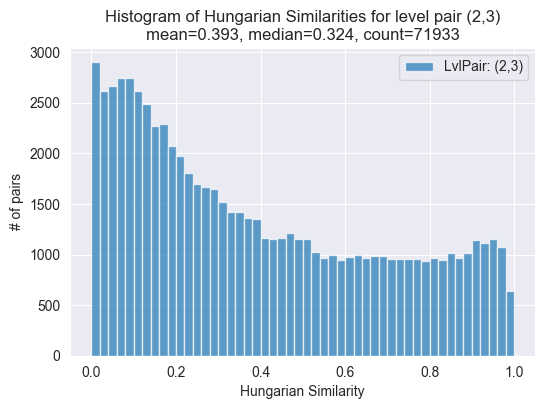

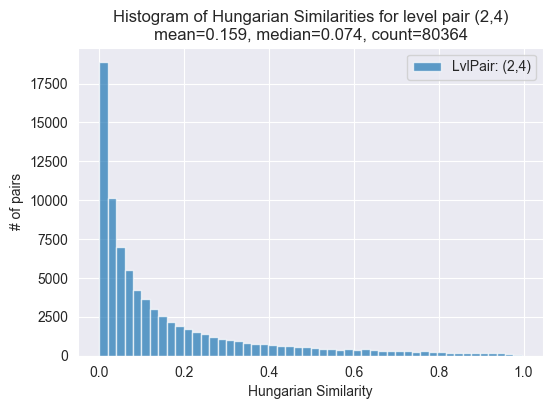

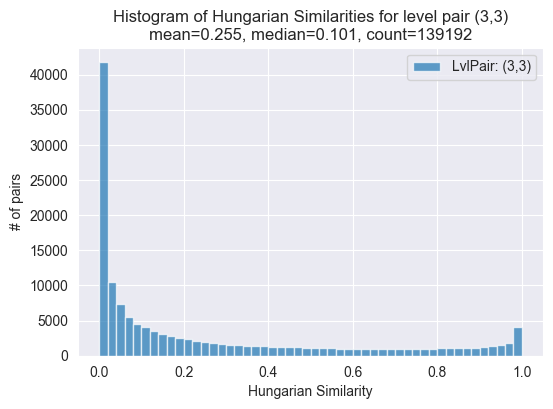

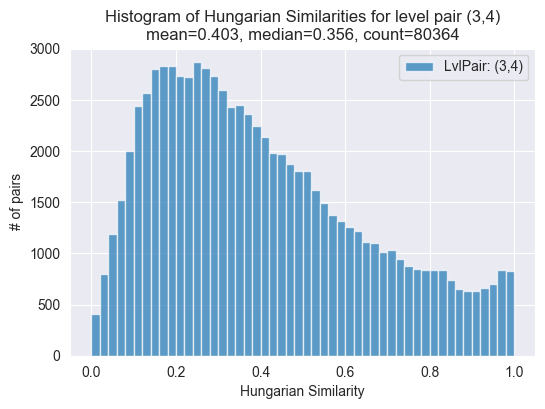

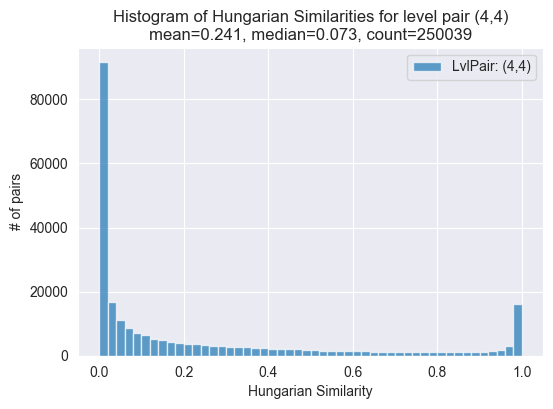

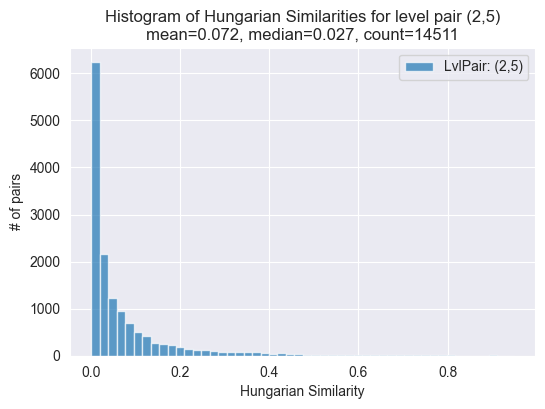

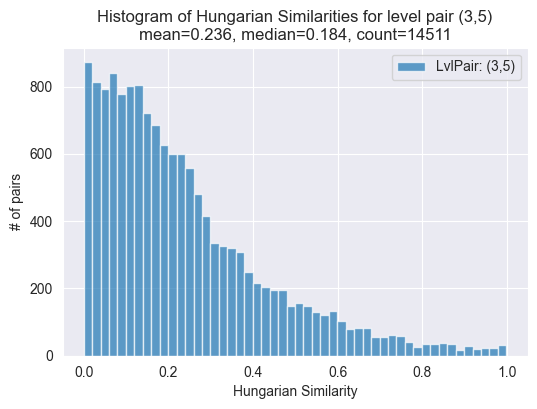

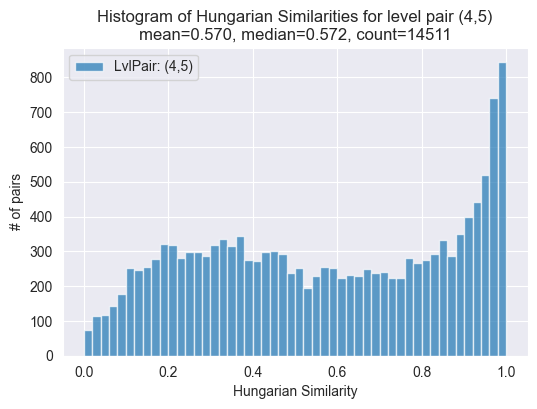

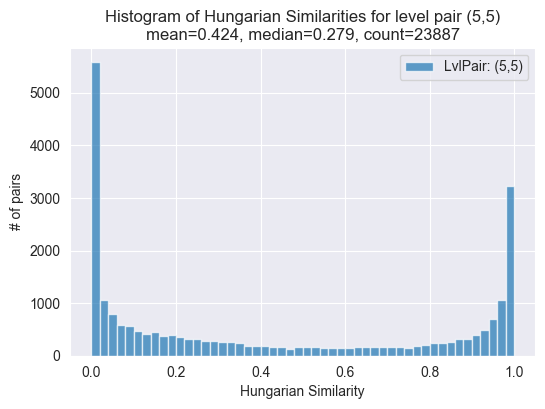

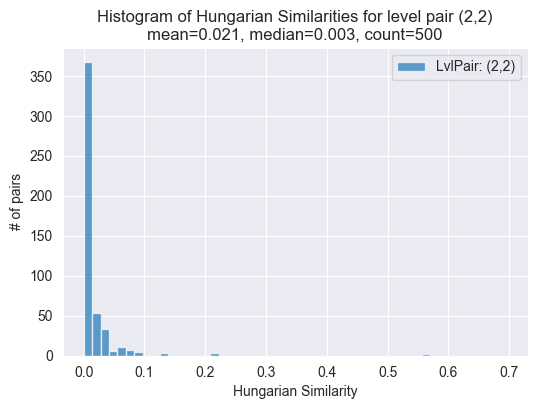

In [31]:
# Optionally plot each level pair in a separate figure:
plot_histograms_by_level_pairs(all_level_sims_hung, mode="Hungarian")

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
def plot_histogram_kde(all_level_sims: Dict[Tuple[int, int], List[float]], target_level_pair: Tuple[int, int], title: str):
    """
    Plot histogram with KDE overlay for a specific level pair.
    
    Parameters:
    - all_level_sims: Dict mapping level pairs to list of similarity scores
    - target_level_pair: Tuple indicating the target level pair (e.g., (2,2))
    - title: Title of the plot
    """
    sims = all_level_sims.get(target_level_pair, [])
    
    # Diagnostic Prints
    print(f"Type of sims: {type(sims)}")
    print(f"Length of sims: {len(sims)}")
    if isinstance(sims, list):
        if len(sims) > 0:
            print(f"First 5 elements: {sims[:5]}")
        else:
            print("sims list is empty.")
    else:
        print("sims is not a list.")
    
    if not sims:
        print(f"No similarity scores found for level pair {target_level_pair}.")
        return
    
    # Ensure all elements are numeric
    sims_numeric = [score for score in sims if isinstance(score, (int, float, np.integer, np.floating))]
    non_numeric = len(sims) - len(sims_numeric)
    if non_numeric > 0:
        print(f"Removed {non_numeric} non-numeric similarity scores.")

    if not sims_numeric:
        print(f"No numeric similarity scores available for level pair {target_level_pair}.")
        return
    
    plt.figure(figsize=(10, 6))
    sns.histplot(sims_numeric, bins=50, kde=True, stat="density", color='skyblue', edgecolor='black')
    plt.title(f"{title} for Level Pair {target_level_pair}")
    plt.xlabel("Similarity Score")
    plt.ylabel("Density")
    plt.xlim(-0.1, 1.1)  # Adjust based on similarity score range
    plt.show()

def plot_boxplots(all_level_sims: Dict[Tuple[int, int], List[float]], title: str):
    """
    Plot boxplots of similarity scores for multiple level pairs.
    
    Parameters:
    - all_level_sims: Dict mapping level pairs to list of similarity scores
    - title: Title of the plot
    """
    data = []
    for (lvlA, lvlB), sims in all_level_sims.items():
        label = f"{lvlA}-{lvlB}"
        for sim in sims:
            data.append({"Level Pair": label, "Similarity": sim})
    
    df = pd.DataFrame(data)
    
    plt.figure(figsize=(14, 8))
    sns.boxplot(x="Level Pair", y="Similarity", data=df, palette="Set3")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.xlabel("MS Level Pair")
    plt.ylabel("Similarity Score")
    plt.show()

In [34]:
def plot_density(all_level_sims: Dict[Tuple[int, int], List[float]], title: str):
    """
    Plot density plots of similarity scores for all level pairs.
    
    Parameters:
    - all_level_sims: Dict mapping level pairs to list of similarity scores
    - title: Title of the plot
    """
    plt.figure(figsize=(14, 8))
    for (lvlA, lvlB), sims in all_level_sims.items():
        label = f"{lvlA}-{lvlB}"
        sns.kdeplot(sims, label=label, shade=False)
    
    plt.title(title)
    plt.xlabel("Similarity Score")
    plt.ylabel("Density")
    plt.legend(title="MS Level Pairs", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
    
def plot_comparative_histogram(all_level_sims: Dict[Tuple[int, int], List[float]], target_level_pair: Tuple[int, int], compare_level_pair: Tuple[int, int], title: str):
    """
    Plot comparative histograms for two specific level pairs.
    
    Parameters:
    - all_level_sims: Dict mapping level pairs to list of similarity scores
    - target_level_pair: Tuple indicating the target level pair (e.g., (2,2))
    - compare_level_pair: Tuple indicating the comparison level pair (e.g., (2,3))
    - title: Title of the plot
    """
    sims_target = all_level_sims.get(target_level_pair, [])
    sims_compare = all_level_sims.get(compare_level_pair, [])
    
    if not sims_target or not sims_compare:
        print(f"Insufficient data for comparison between {target_level_pair} and {compare_level_pair}.")
        return
    
    plt.figure(figsize=(10, 6))
    sns.histplot(sims_target, bins=50, kde=True, stat="density", label=f"{target_level_pair}", color='blue', alpha=0.5)
    sns.histplot(sims_compare, bins=50, kde=True, stat="density", label=f"{compare_level_pair}", color='orange', alpha=0.5)
    plt.title(title)
    plt.xlabel("Similarity Score")
    plt.ylabel("Density")
    plt.legend(title="MS Level Pairs")
    plt.xlim(-0.1, 1.1)
    plt.show()


Type of sims: <class 'list'>
Length of sims: 71933
First 5 elements: [0.09482385185445195, 0.8912841082529714, 0.005303157202610283, 0.18932301495035853, 0.898550915493607]


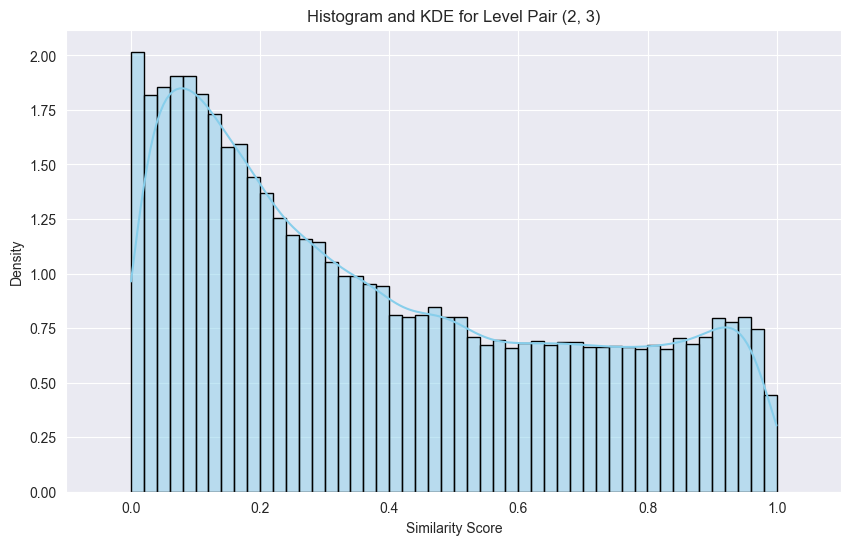

In [35]:
plot_histogram_kde(all_level_sims_hung, (2, 3), "Histogram and KDE")

/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_26379/3836655273.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Level Pair", y="Similarity", data=df, palette="Set3")


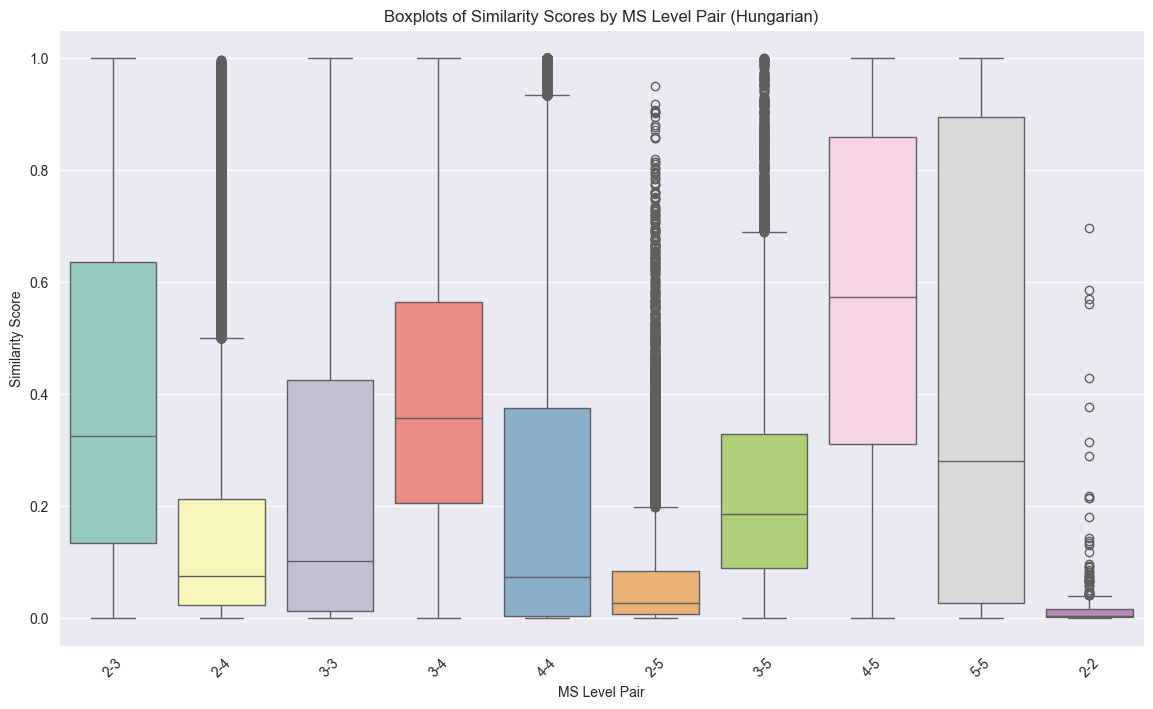

In [36]:
plot_boxplots(all_level_sims_hung, "Boxplots of Similarity Scores by MS Level Pair (Hungarian)")

/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_26379/792835851.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(sims, label=label, shade=False)
/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_26379/792835851.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(sims, label=label, shade=False)
/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_26379/792835851.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(sims, label=label, shade=False)
/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_26379/792835851.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; 

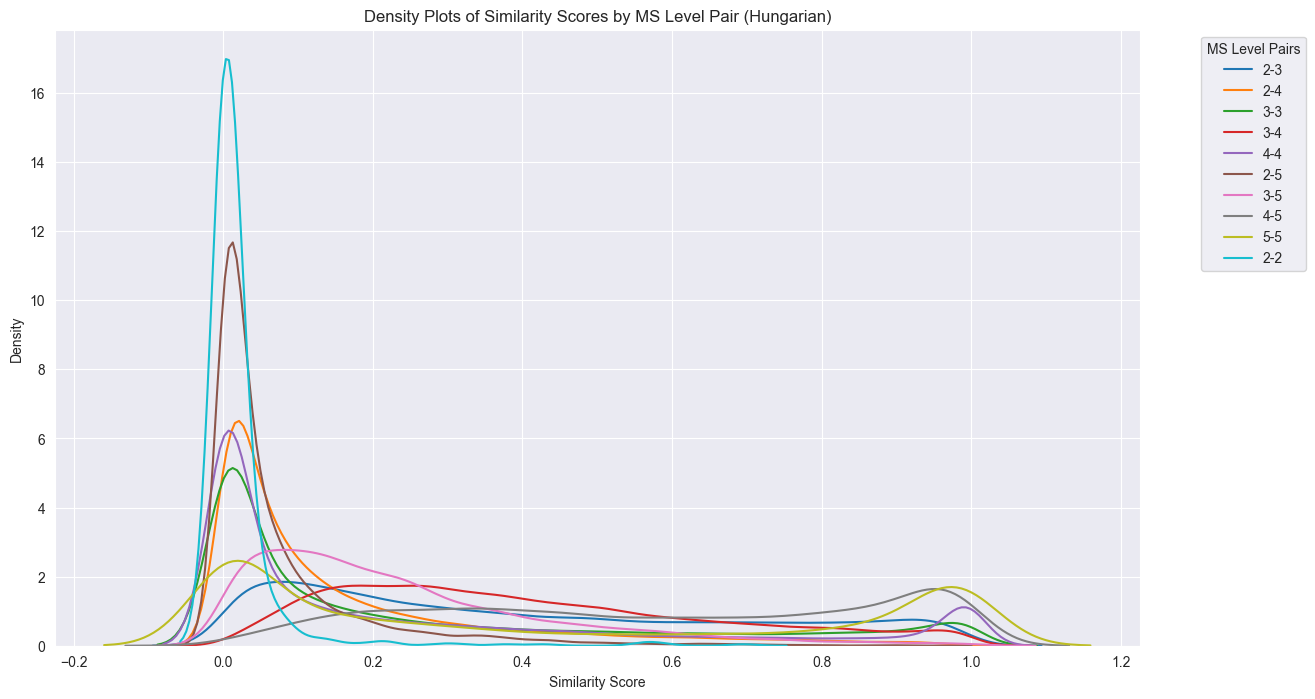

In [37]:
plot_density(all_level_sims_hung, "Density Plots of Similarity Scores by MS Level Pair (Hungarian)")

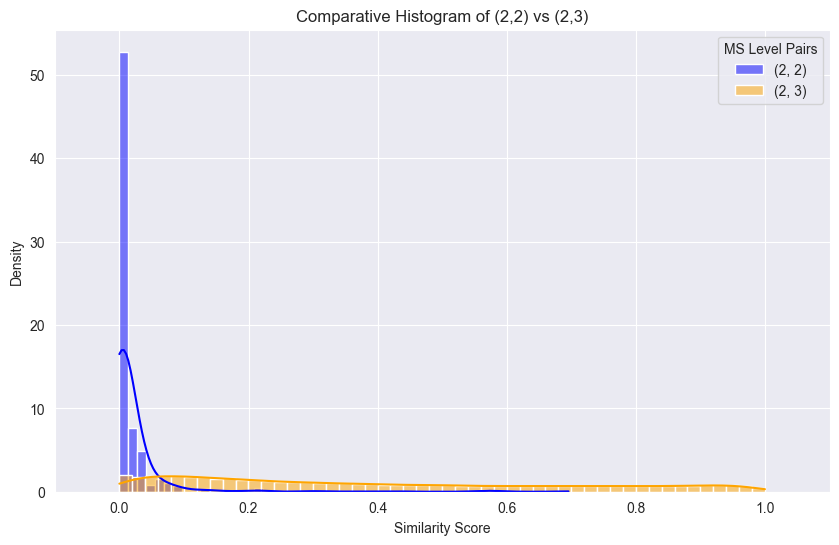

In [38]:
plot_comparative_histogram(all_level_sims_hung, (2, 2), (2, 3), "Comparative Histogram of (2,2) vs (2,3)")

## Identify best distribution for our data

In [39]:
from scipy import stats
import numpy as np
import pandas as pd
import warnings

def fit_distributions(data: List[float], distributions: List[str] = None) -> pd.DataFrame:
    """
    Fit multiple distributions to the data and evaluate goodness-of-fit using KS statistic.
    
    Parameters:
    - data: List of similarity scores (floats)
    - distributions: List of distribution names to fit. If None, a default list is used.
    
    Returns:
    - DataFrame with distribution parameters and KS statistics
    """
    if distributions is None:
        distributions = [
            'norm', 'expon', 'beta', 'gamma', 'lognorm', 'uniform', 'weibull_min',
            'weibull_max', 'pareto', 't', 'cauchy'
        ]
    
    results = []
    data = np.array(data)
    
    # Remove NaN values
    data = data[~np.isnan(data)]
    
    for dist_name in distributions:
        dist = getattr(stats, dist_name)
        try:
            # Fit distribution to data
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                params = dist.fit(data)
            
            # Perform KS test
            ks_stat, ks_p = stats.kstest(data, dist_name, args=params)
            
            # Append results
            results.append({
                'Distribution': dist_name,
                'Parameters': params,
                'KS Statistic': ks_stat,
                'KS p-value': ks_p
            })
        except Exception as e:
            print(f"Could not fit distribution {dist_name}: {e}")
            continue
    
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by='KS Statistic')
    return results_df

def fit_distributions_with_aic(data: List[float], distributions: List[str] = None) -> pd.DataFrame:
    """
    Fit multiple distributions to the data and evaluate goodness-of-fit using AIC.
    
    Parameters:
    - data: List of similarity scores (floats)
    - distributions: List of distribution names to fit. If None, a default list is used.
    
    Returns:
    - DataFrame with distribution parameters and AIC scores
    """
    if distributions is None:
        distributions = [
            'norm', 'expon', 'beta', 'gamma', 'lognorm', 'uniform', 'weibull_min',
            'weibull_max', 'pareto', 't', 'cauchy'
        ]
    
    results = []
    data = np.array(data)
    
    # Remove NaN values
    data = data[~np.isnan(data)]
    
    for dist_name in distributions:
        dist = getattr(stats, dist_name)
        try:
            # Fit distribution to data
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                params = dist.fit(data)
            
            # Calculate log-likelihood
            log_likelihood = np.sum(dist.logpdf(data, *params))
            
            # Number of parameters
            k = len(params)
            
            # Calculate AIC
            aic = 2*k - 2*log_likelihood
            
            # Append results
            results.append({
                'Distribution': dist_name,
                'Parameters': params,
                'AIC': aic
            })
        except Exception as e:
            print(f"Could not fit distribution {dist_name}: {e}")
            continue
    
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by='AIC')
    return results_df

def identify_top_fits(df: pd.DataFrame, criterion: str = 'KS Statistic', top_n: int = 5) -> pd.DataFrame:
    """
    Identify the top N best-fitting distributions based on a specified criterion.
    
    Parameters:
    - df: DataFrame containing distribution fit results
    - criterion: Column name to sort by ('KS Statistic' or 'AIC')
    - top_n: Number of top distributions to return
    
    Returns:
    - DataFrame of top N distributions
    """
    if criterion not in df.columns:
        raise ValueError(f"Criterion '{criterion}' not found in DataFrame columns.")
    
    top_fits = df.nsmallest(top_n, criterion)
    return top_fits

def summarize_all_level_pairs(
    all_level_sims: Dict[Tuple[int, int], List[float]],
    top_n: int = 5
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Fit distributions to all level pairs and summarize the top N best-fitting distributions based on KS and AIC.
    
    Parameters:
    - all_level_sims: Dict mapping level pairs to list of similarity scores (floats)
    - top_n: Number of top distributions to include in the summary
    
    Returns:
    - Tuple containing two DataFrames:
        1. Summary based on KS Statistic
        2. Summary based on AIC
    """
    ks_summary = []
    aic_summary = []
    
    for level_pair, sims in all_level_sims.items():
        if len(sims) == 0:
            print(f"Level pair {level_pair} has no similarity scores. Skipping.")
            continue
        print(f"\nFitting distributions for Level Pair {level_pair} with {len(sims)} scores...")
        
        # Fit distributions and compute KS statistics
        ks_df = fit_distributions(sims)
        if ks_df.empty:
            print(f"No distributions were successfully fitted for Level Pair {level_pair}.")
            continue
        top_ks = identify_top_fits(ks_df, criterion='KS Statistic', top_n=top_n)
        top_ks = top_ks.copy()
        top_ks['Level Pair'] = f"{level_pair[0]},{level_pair[1]}"  # Convert tuple to string
        ks_summary.append(top_ks)
        
        # Fit distributions and compute AIC
        aic_df = fit_distributions_with_aic(sims)
        if aic_df.empty:
            print(f"No distributions were successfully fitted for Level Pair {level_pair} based on AIC.")
            continue
        top_aic = identify_top_fits(aic_df, criterion='AIC', top_n=top_n)
        top_aic = top_aic.copy()
        top_aic['Level Pair'] = f"{level_pair[0]},{level_pair[1]}"  # Convert tuple to string
        aic_summary.append(top_aic)
    
    # Concatenate all summaries
    if ks_summary:
        ks_summary_df = pd.concat(ks_summary, ignore_index=True)
    else:
        ks_summary_df = pd.DataFrame()
    if aic_summary:
        aic_summary_df = pd.concat(aic_summary, ignore_index=True)
    else:
        aic_summary_df = pd.DataFrame()
    
    return ks_summary_df, aic_summary_df

def plot_histogram_with_best_fit(data: List[float], best_fit_dist: str, title: str):
    """
    Plot histogram with KDE and the best-fitting distribution's PDF.
    
    Parameters:
    - data: List of similarity scores (floats)
    - best_fit_dist: Name of the best-fitting distribution
    - title: Title of the plot
    """
    dist = getattr(stats, best_fit_dist)
    params = dist.fit(data)
    
    # Create range for x-axis
    x = np.linspace(min(data), max(data), 1000)
    pdf = dist.pdf(x, *params)
    
    plt.figure(figsize=(10, 6))
    sns.histplot(data, bins=50, kde=True, stat="density", color='skyblue', edgecolor='black', label='Data')
    plt.plot(x, pdf, 'r-', label=f'{best_fit_dist} PDF')
    plt.title(f"{title} with Best-Fitting Distribution ({best_fit_dist})")
    plt.xlabel("Similarity Score")
    plt.ylabel("Density")
    plt.legend()
    plt.xlim(-0.1, 1.1)  # Adjust based on similarity score range
    plt.show()
    

def plot_best_fit(
    summary_df: pd.DataFrame,
    all_level_sims: Dict[Tuple[int, int], List[float]],
    criterion: str = 'KS Statistic',
    save_plots: bool = False
):
    """
    Plot histogram with KDE and the best-fitting distribution's PDF for each level pair based on the specified criterion.
    
    Parameters:
    - summary_df: DataFrame containing distribution fit results (either KS or AIC based).
    - all_level_sims: Dict mapping level pairs to list of similarity scores (floats).
    - criterion: Criterion to select distributions ('KS Statistic' or 'AIC').
    - save_plots: If True, saves the plots as PNG files.
    """
    # Ensure the criterion is valid
    if criterion not in ['KS Statistic', 'AIC']:
        raise ValueError("Criterion must be either 'KS Statistic' or 'AIC'")
    
    # Define the column to sort by based on the criterion
    if criterion == 'KS Statistic':
        stat_col = 'KS Statistic'
    else:
        stat_col = 'AIC'
    
    # Sort the DataFrame based on 'Level Pair' and the criterion
    sorted_df = summary_df.sort_values(['Level Pair', stat_col], ascending=[True, True])
    
    # Group by 'Level Pair' and take the first entry in each group (best fit)
    best_fits = sorted_df.groupby('Level Pair').first().reset_index()
    
    # Iterate over each level pair and plot
    for _, row in best_fits.iterrows():
        level_pair_str = row['Level Pair']
        try:
            lvlA, lvlB = map(int, level_pair_str.split(','))
        except ValueError:
            print(f"Invalid Level Pair format: '{level_pair_str}'. Skipping plot.")
            continue
        
        sims = all_level_sims.get((lvlA, lvlB), [])
        
        if not sims:
            print(f"Level pair ({lvlA}, {lvlB}) has no similarity scores. Skipping plot.")
            continue
        
        # Summarize statistics
        stats_lv = summarize_similarity_distribution(sims)
        mean = stats_lv['mean']
        median = stats_lv['median']
        count = stats_lv['count']
        
        # Get distribution details
        dist_name = row['Distribution']
        params = row['Parameters']
        
        # Format parameters to three decimal places
        formatted_params = ', '.join([f"{param:.3f}" for param in params])
        
        # Create range for x-axis
        x = np.linspace(min(sims), max(sims), 1000)
        
        # Get the distribution and compute PDF
        try:
            dist = getattr(stats, dist_name)
            pdf = dist.pdf(x, *params)
        except Exception as e:
            print(f"Error computing PDF for distribution '{dist_name}' with parameters {params}: {e}")
            continue
        
        # Initialize the plot
        plt.figure(figsize=(12, 7))
        
        # Plot histogram with KDE
        sns.histplot(sims, bins=50, kde=True, stat="density", color='skyblue', edgecolor='black', label='Histogram')
        
        # Overlay the PDF of the best-fitting distribution
        plt.plot(x, pdf, 'r-', label=f"{dist_name} PDF", linewidth=2)
        
        # Customize the legend to include KDE
        plt.legend(title='Legend', fontsize=12)
        
        # Customize axis labels and title
        plt.xlabel("Similarity Score", fontsize=14)
        plt.ylabel("Density", fontsize=14)
        
        # Title with criterion and best distribution
        plt.title(
            f"{criterion}: {dist_name}\n"
            f"Level Pair: ({lvlA},{lvlB}) | Mean: {mean:.3f}, Median: {median:.3f}, Count: {count}\n"
            f"Parameters: ({formatted_params})",
            fontsize=16
        )
        
        # Increase tick label sizes
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        
        # Adjust x-axis limits if necessary
        plt.xlim(-0.1, 1.1)  # Modify based on your data's range
        
        # Save the plot if required
        if save_plots:
            plt.savefig(f"Histogram_{lvlA}_{lvlB}_{criterion}.png")
        
        # Display the plot
        plt.show()

In [40]:
# Generate the summary tables
ks_summary_df, aic_summary_df = summarize_all_level_pairs(all_level_sims_hung, top_n=5)

# Display KS Summary Table
print("\nTop 5 Best-Fitting Distributions Based on KS Statistic:")
display(ks_summary_df)

# Display AIC Summary Table
print("\nTop 5 Best-Fitting Distributions Based on AIC:")
display(aic_summary_df)


Fitting distributions for Level Pair (2, 3) with 71933 scores...

Fitting distributions for Level Pair (2, 4) with 80364 scores...

Fitting distributions for Level Pair (3, 3) with 139192 scores...

Fitting distributions for Level Pair (3, 4) with 80364 scores...

Fitting distributions for Level Pair (4, 4) with 250039 scores...

Fitting distributions for Level Pair (2, 5) with 14511 scores...

Fitting distributions for Level Pair (3, 5) with 14511 scores...

Fitting distributions for Level Pair (4, 5) with 14511 scores...

Fitting distributions for Level Pair (5, 5) with 23887 scores...

Fitting distributions for Level Pair (2, 2) with 500 scores...

Top 5 Best-Fitting Distributions Based on KS Statistic:


Distribution                                         Parameters  \
0          beta  (0.9529189668699778, 2.1430406223244924, -1.57...   
1   weibull_min  (1.2124347883121667, -0.0008508629037633147, 0...   
2         gamma  (1.247510526508711, -0.0007953053784309521, 0....   
3       lognorm  (0.6717420620441968, -0.09993517911944097, 0.4...   
4   weibull_max  (141373146.89470714, 32791666.38793264, 327916...   
5   weibull_min  (0.7453535431238589, -1.0705943309842896e-30, ...   
6        pareto  (2.002329621328352, -0.18230990420184898, 0.18...   
7         gamma  (0.576079908061335, -5.4385845413828965e-31, 0...   
8          beta  (0.46856270451909277, 2.495022325184895, -4.29...   
9         expon                         (0.0, 0.15920017039996986)   
10       pareto  (0.645866249499667, -0.03056486974734716, 0.03...   
11  weibull_min  (0.507421604591606, -5.346976874343505e-29, 0....   
12         beta  (0.3981177561468062, 0.8409864083573237, -2.44...   
13  weibull_max  (62039.5573622453, 12330.108651957185, 12329.9...   
14        gamma  (0.6208536352436191, -4.123808517546061e-26, 0...   
15  weibull_min  (1.6886057933286955, -0.0016921896615908851, 0...   
16        gamma  (2.6361631378245334, -0.018894419633405365, 0....   
17      lognorm  (0.4369406583822738, -0.17288399469023288, 0.5...   
18         beta  (1.5254425414053565, 2.845728546329934, -0.000...   
19  weibull_max  (97220995.47617719, 18963629.34426975, 1896362...   
20  weibull_max  (221405892.2077192, 42283658.469274685, 422836...   
21         beta  (0.3373965762611878, 0.727371236433517, -9.918...   
22        gamma  (0.5808119216313115, -1.4237466236599852e-29, ...   
23         norm         (0.24120319032465876, 0.32201527994996815)   
24       pareto  (139112721.89488998, -33554432.0, 33554431.999...   
25       pareto  (1.1912396270046404, -0.030953978182449996, 0....   
26         beta  (0.598931520135563, 790.435979220077, -2.58284...   
27  weibull_min  (0.5659969554154223, -1.6125874191326126e-31, ...   
28  weibull_max  (33534.415710173154, 1784.0557314048947, 1784....   
29        expon                         (0.0, 0.07193860604153023)   
30  weibull_min  (1.1637563146424457, -0.0006735315350781988, 0...   
31        gamma  (1.2575889905795115, -0.0012074379559965367, 0...   
32         beta  (0.9460859305491596, 4.309881663721789, -3.823...   
33  weibull_max  (270888683.517558, 36892367.54923102, 36892367...   
34        expon                         (0.0, 0.23587060716991398)   
35         beta  (1.1719767504925522, 0.8667418235981916, -0.00...   
36      lognorm  (0.0100617693240822, -28.870906393859038, 29.4...   
37            t  (19238564929.561367, 0.5697009128630603, 0.296...   
38         norm           (0.5697008981701628, 0.2965893527288839)   
39        gamma  (844.7559957813955, -8.066295907969014, 0.0102...   
40         norm          (0.42366050705093833, 0.3989486226710962)   
41            t  (853841886.4088633, 0.4236621233738296, 0.3989...   
42        expon                         (0.0, 0.42366050705093833)   
43         beta  (0.3567563821237013, 0.8616736395863788, -1.05...   
44  weibull_max  (0.8799279928896369, 0.9999995346449021, 0.552...   
45       pareto  (0.4156996181459681, -0.0003438498996348177, 0...   
46         beta  (0.5377208359840768, 930.1841571432487, -5.616...   
47        gamma  (0.1361806930525245, -2.4271872410643413e-29, ...   
48  weibull_max  (944281029.3412905, 14829538.612455605, 148295...   
49  weibull_min  (0.7204122906466642, -1.7250746507600213e-31, ...   

    KS Statistic     KS p-value Level Pair  
0       0.047143  2.277159e-139        2,3  
1       0.062610  1.398716e-245        2,3  
2       0.065866  9.182752e-272        2,3  
3       0.071538  1.439707e-320        2,3  
4       0.074026   0.000000e+00        2,3  
5       0.030777   1.436386e-66        2,4  
6       0.049466  2.491512e-171        2,4  
7       0.063937  4.651442e-286        2,4  
8       0.080394   0.000000


Top 5 Best-Fitting Distributions Based on AIC:


Distribution                                         Parameters  \
0          beta  (0.9529189668699778, 2.1430406223244924, -1.57...   
1       uniform                          (0.0, 0.9995800041106572)   
2   weibull_min  (1.2124347883121667, -0.0008508629037633147, 0...   
3         gamma  (1.247510526508711, -0.0007953053784309521, 0....   
4         expon                         (0.0, 0.39291368614045286)   
5       lognorm  (119.93913359446574, -5e-324, 1.46519666918618...   
6          beta  (0.46856270451909277, 2.495022325184895, -4.29...   
7         gamma  (0.576079908061335, -5.4385845413828965e-31, 0...   
8   weibull_min  (0.7453535431238589, -1.0705943309842896e-30, ...   
9        pareto  (2.002329621328352, -0.18230990420184898, 0.18...   
10      lognorm  (235.0476227806456, -5e-324, 3.119482026118572...   
11         beta  (0.3981177561468062, 0.8409864083573237, -2.44...   
12  weibull_min  (0.507421604591606, -5.346976874343505e-29, 0....   
13        gamma  (0.6208536352436191, -4.123808517546061e-26, 0...   
14       pareto  (0.645866249499667, -0.03056486974734716, 0.03...   
15         beta  (1.5254425414053565, 2.845728546329934, -0.000...   
16  weibull_min  (1.6886057933286955, -0.0016921896615908851, 0...   
17        gamma  (2.6361631378245334, -0.018894419633405365, 0....   
18      lognorm  (0.4369406583822738, -0.17288399469023288, 0.5...   
19  weibull_max  (97220995.47617719, 18963629.34426975, 1896362...   
20      lognorm  (305.89579092585143, -5e-324, 1.28775508142295...   
21  weibull_min  (0.25728039125460545, -5.512552209338458e-30, ...   
22         beta  (0.3373965762611878, 0.727371236433517, -9.918...   
23        gamma  (0.5808119216313115, -1.4237466236599852e-29, ...   
24            t  (0.19325382610704223, -9.161269098015043e-19, ...   
25      lognorm  (190.7584328969867, -5e-324, 2.909941168790213...   
26  weibull_min  (0.5659969554154223, -1.6125874191326126e-31, ...   
27        gamma  (0.6637253027603023, -1.7365873879028413e-32, ...   
28         beta  (0.598931520135563, 790.435979220077, -2.58284...   
29       pareto  (1.1912396270046404, -0.030953978182449996, 0....   
30      lognorm  (63.538705349198246, -5e-324, 0.00064465675213...   
31         beta  (0.9460859305491596, 4.309881663721789, -3.823...   
32  weibull_min  (1.1637563146424457, -0.0006735315350781988, 0...   
33        gamma  (1.2575889905795115, -0.0012074379559965367, 0...   
34        expon                         (0.0, 0.23587060716991398)   
35         beta  (1.1719767504925522, 0.8667418235981916, -0.00...   
36      uniform                           (0.0, 0.999957820102002)   
37  weibull_max  (1.2687027108258477, 1.0063144279531167, 0.466...   
38  weibull_min  (2.734242815719876, -0.15811494927910733, 0.82...   
39         norm           (0.5697008981701628, 0.2965893527288839)   
40      lognorm  (265.34164064858516, -5e-324, 9.20357842323052...   
41         beta  (0.3567563821237013, 0.8616736395863788, -1.05...   
42  weibull_min  (0.5420782478623578, -9.443366575970845e-29, 0...   
43        gamma  (0.6997784897695276, -1.5551688443951932e-19, ...   
44      uniform                           (0.0, 0.999999534644902)   
45      lognorm  (256.4150627325092, -5e-324, 4.877850280707308...   
46        gamma  (0.1361806930525245, -2.4271872410643413e-29, ...   
47         beta  (0.5377208359840768, 930.1841571432487, -5.616...   
48  weibull_min  (0.7204122906466642, -1.7250746507600213e-31, ...   
49       pareto  (0.4156996181459681, -0.0003438498996348177, 0...   

             AIC Level Pair  
0  -3.654443e+03        2,3  
1  -5.643582e+01        2,3  
2   6.175381e+03        2,3  
3   7.710433e+03        2,3  
4   9.475372e+03        2,3  
5  -2.642031e+06        2,4  
6  -2.851602e+05        2,4  
7  -2.607937e+05        2,4  
8  -2.183247e+05        2,4  
9  -1.441574e+05        2,4  
10 -2.212647e+07        3,3  
11 -1.385086e+06        3,3  
12 -1.093594e+06        3,3  
13 -7.552691

In [41]:
ks_summary_df.keys(), aic_summary_df.keys()

(Index(['Distribution', 'Parameters', 'KS Statistic', 'KS p-value',
        'Level Pair'],
       dtype='object'),
 Index(['Distribution', 'Parameters', 'AIC', 'Level Pair'], dtype='object'))


Plotting Best-Fitting Distributions Based on KS Statistic:


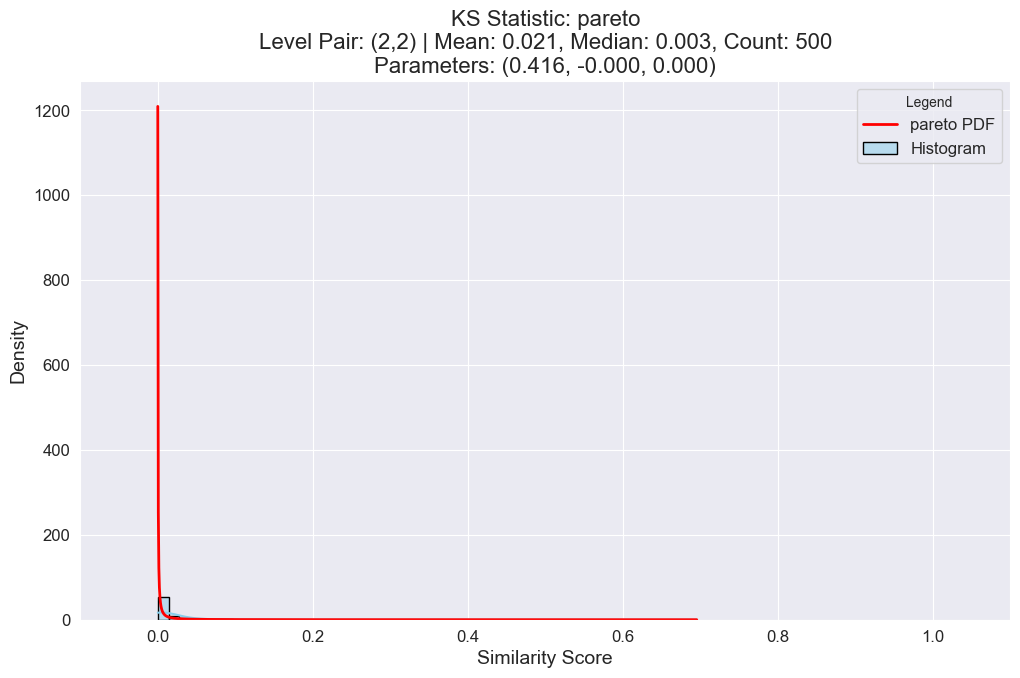

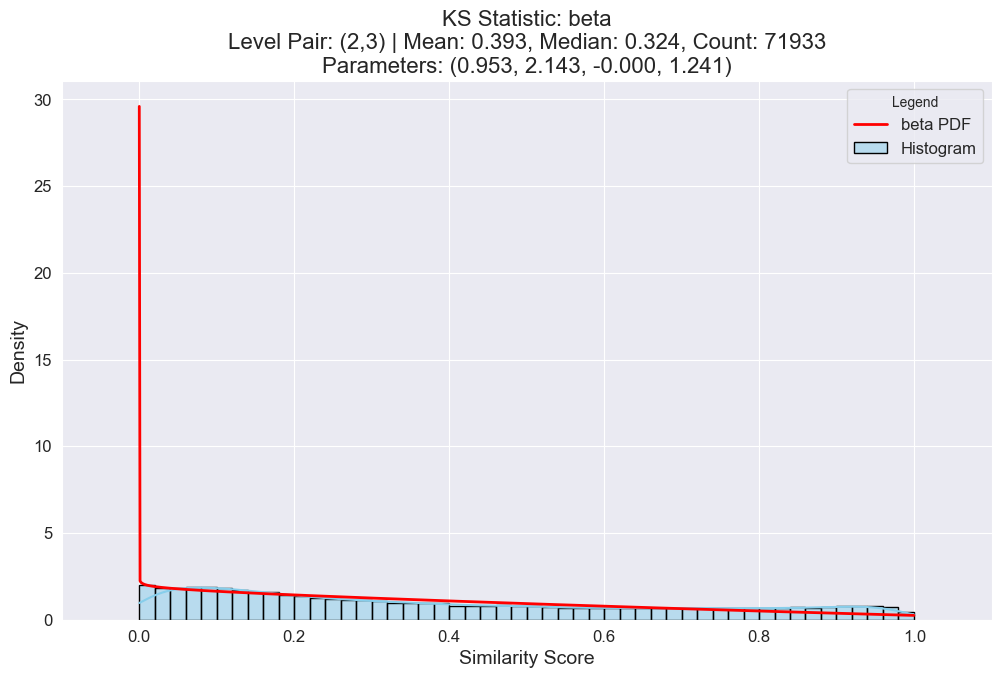

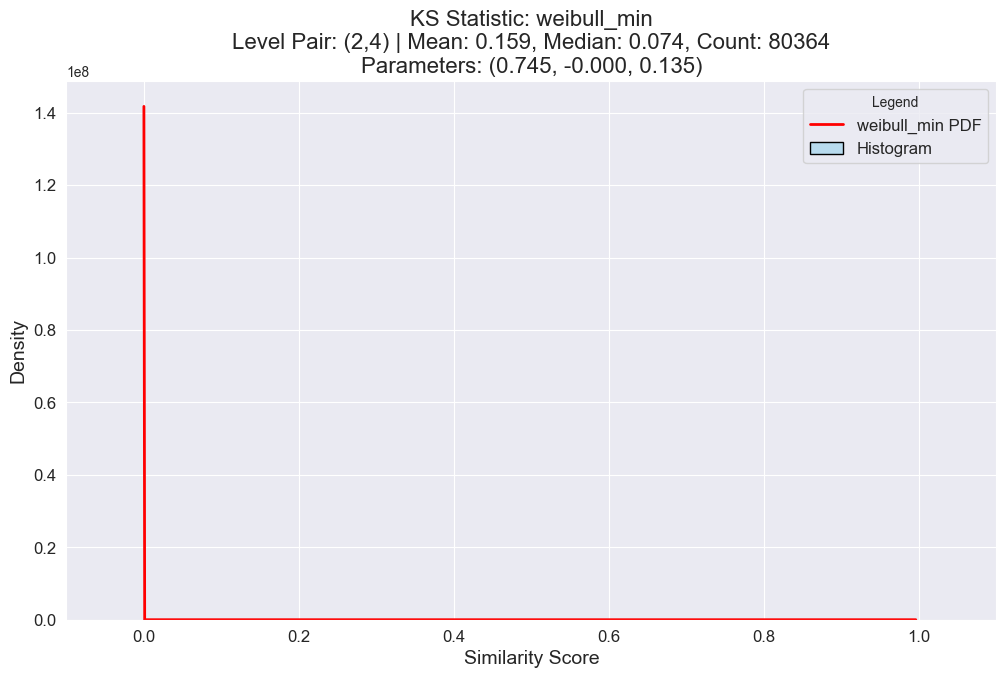

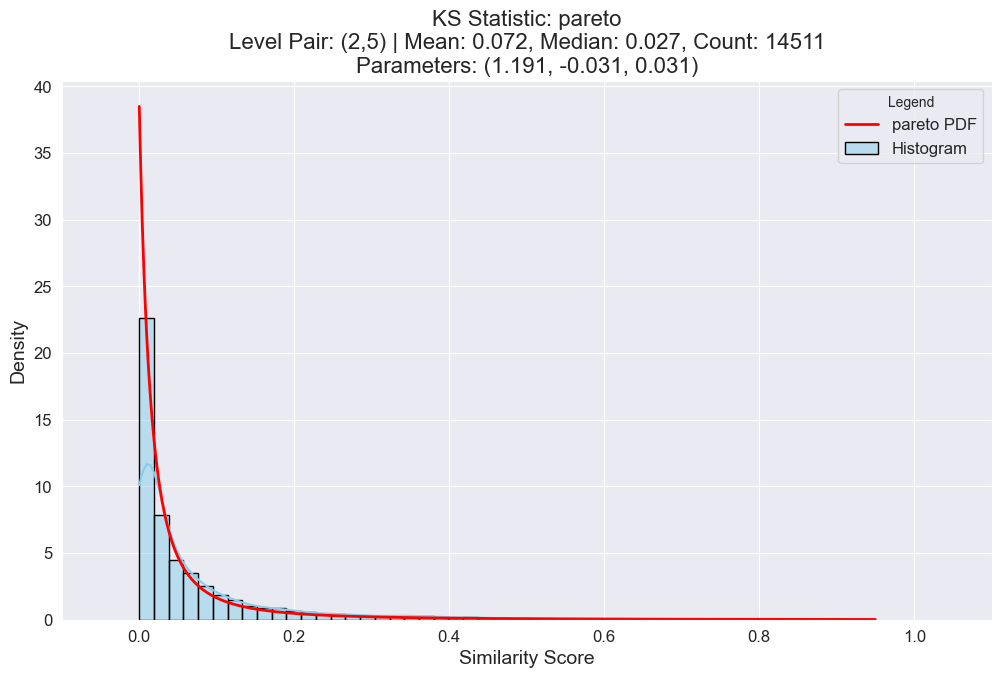

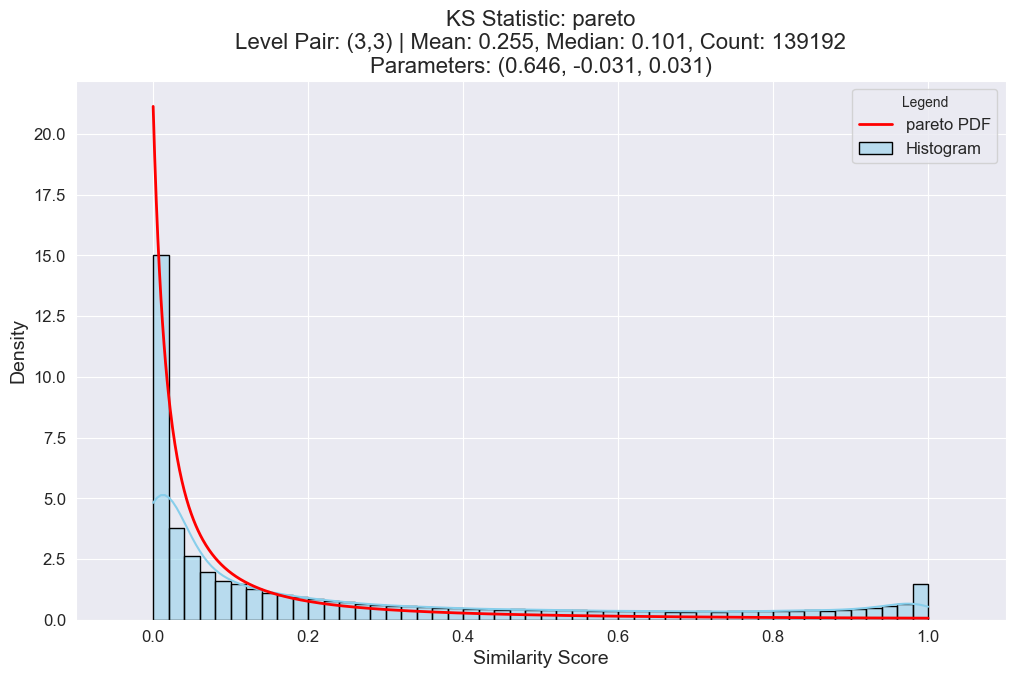

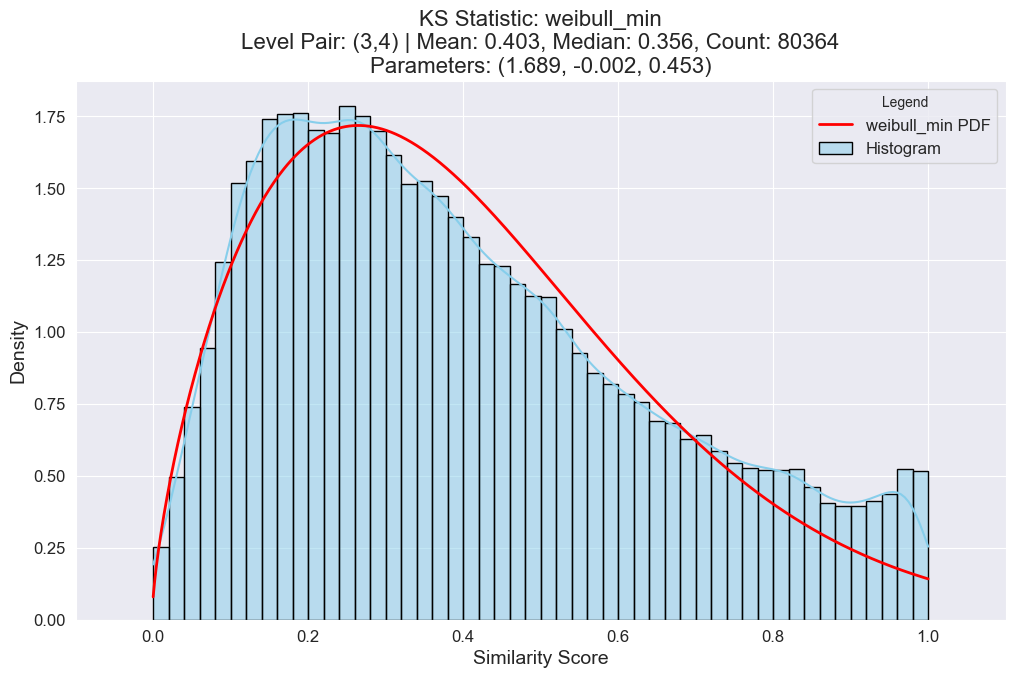

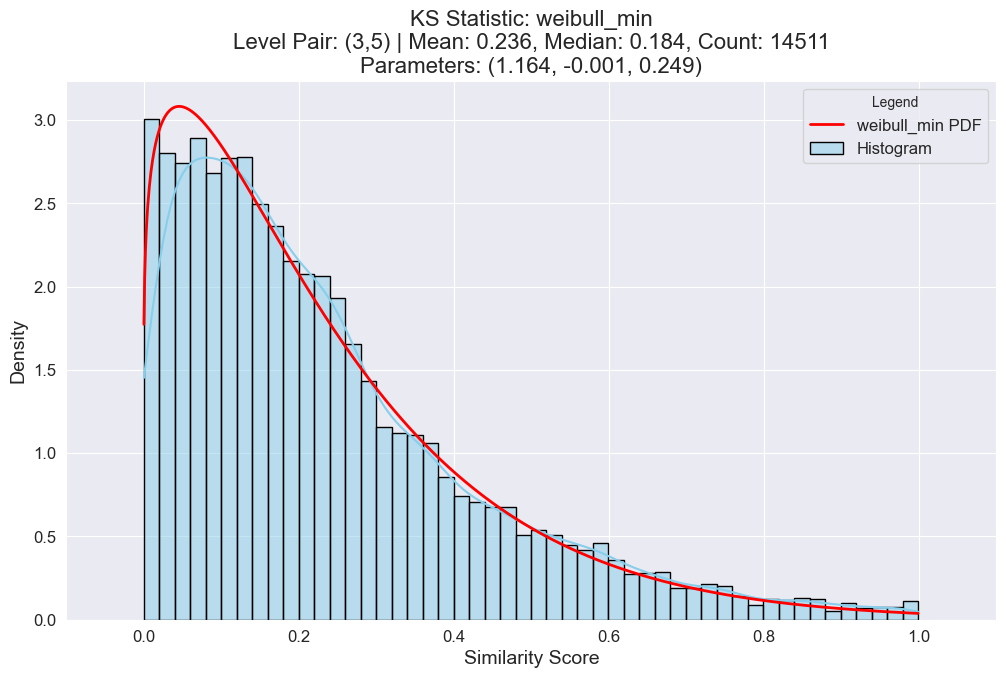

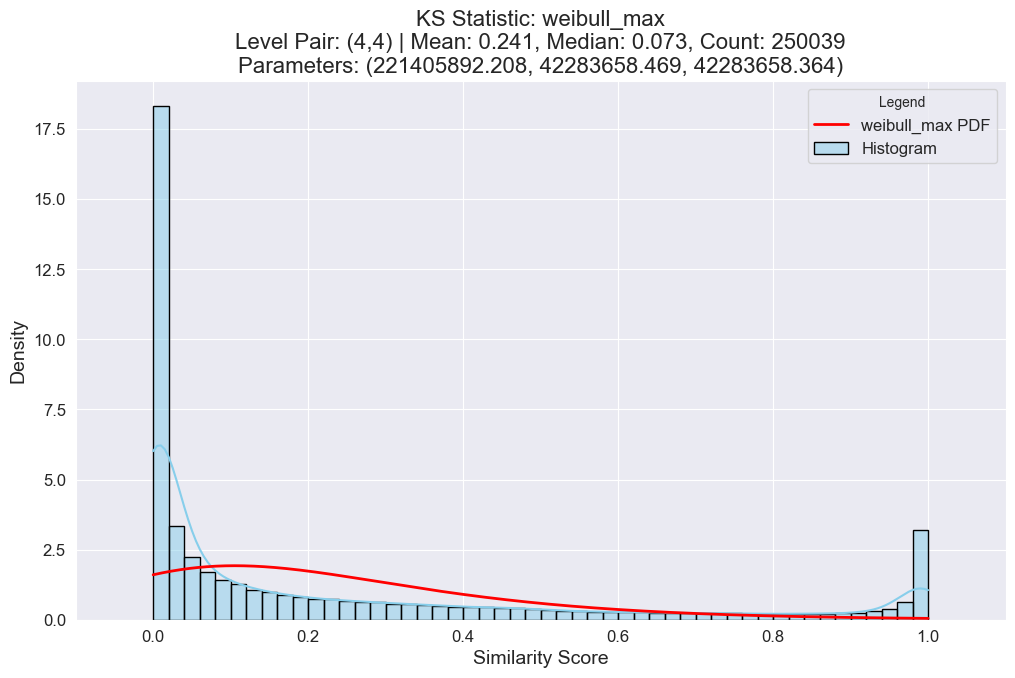

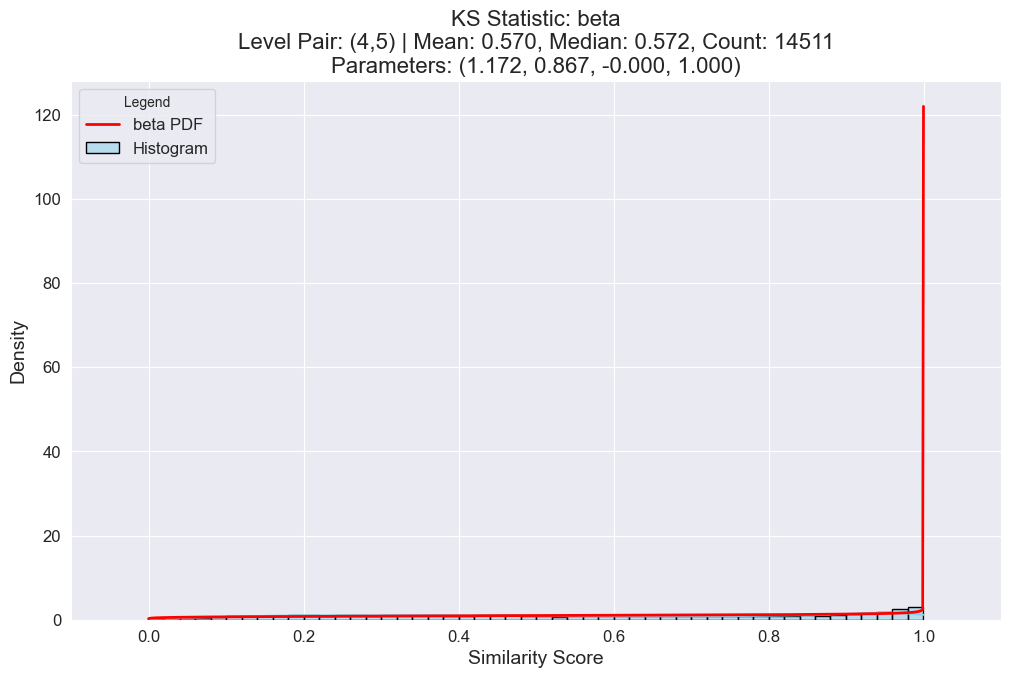

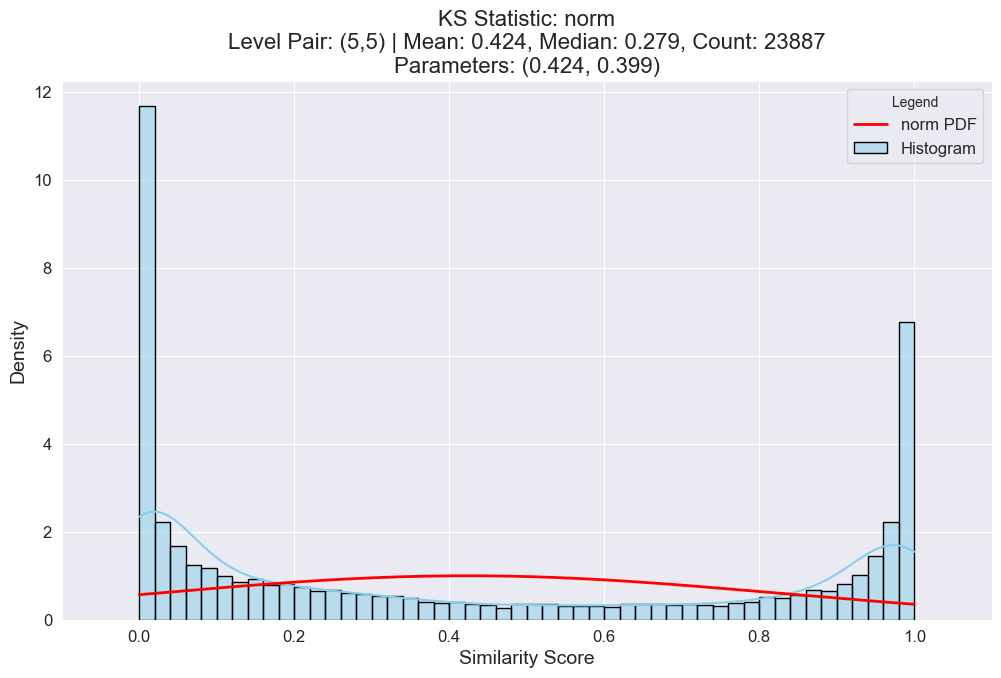

In [42]:
# Plotting Best-Fitting Distributions Based on KS Statistic
print("\nPlotting Best-Fitting Distributions Based on KS Statistic:")
plot_best_fit(
    summary_df=ks_summary_df,
    all_level_sims=all_level_sims_hung,
    criterion='KS Statistic',
    save_plots=False  # Set to True to save plots as PNG files
)


Plotting Best-Fitting Distributions Based on AIC:


/Users/macbook/UTILS/anaconda3/envs/massspecgym/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2036: RuntimeWarning: overflow encountered in divide
  place(output, cond, self._pdf(*goodargs) / scale)


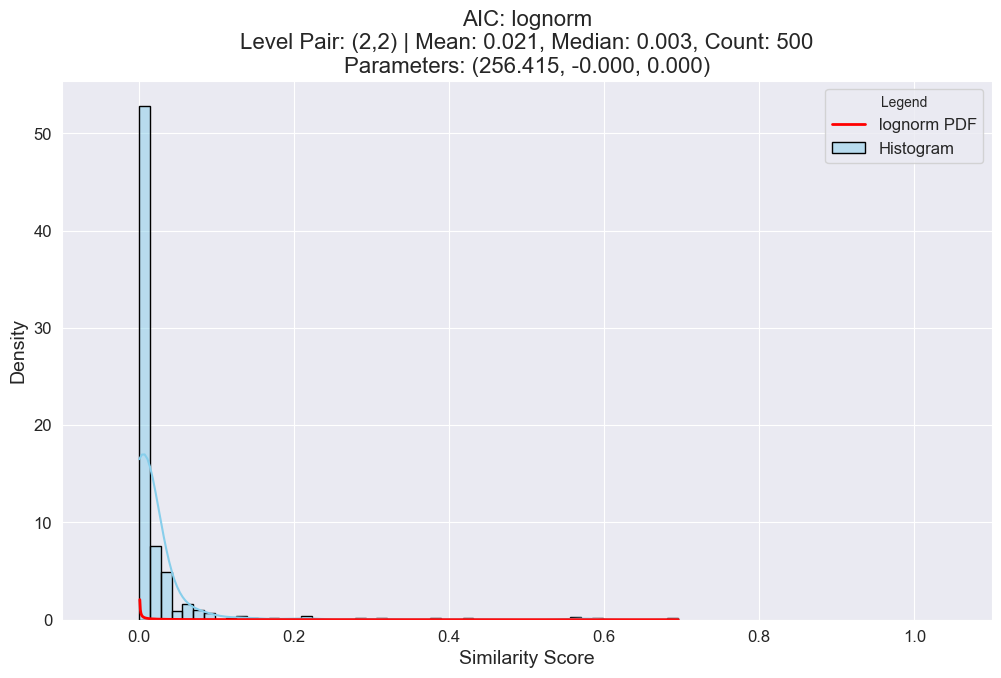

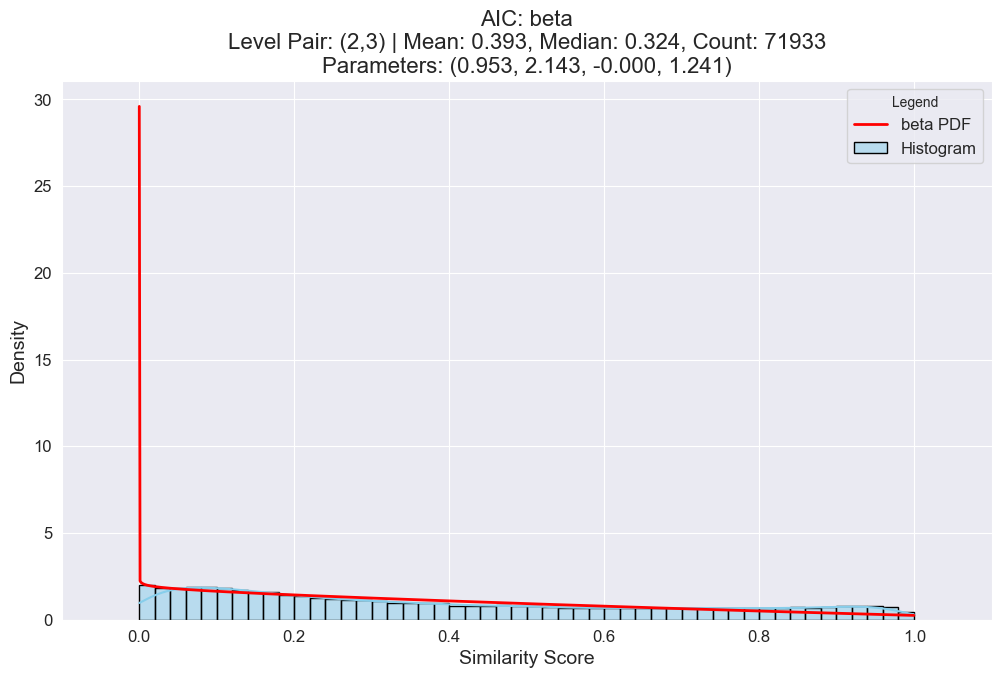

/Users/macbook/UTILS/anaconda3/envs/massspecgym/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2036: RuntimeWarning: overflow encountered in divide
  place(output, cond, self._pdf(*goodargs) / scale)


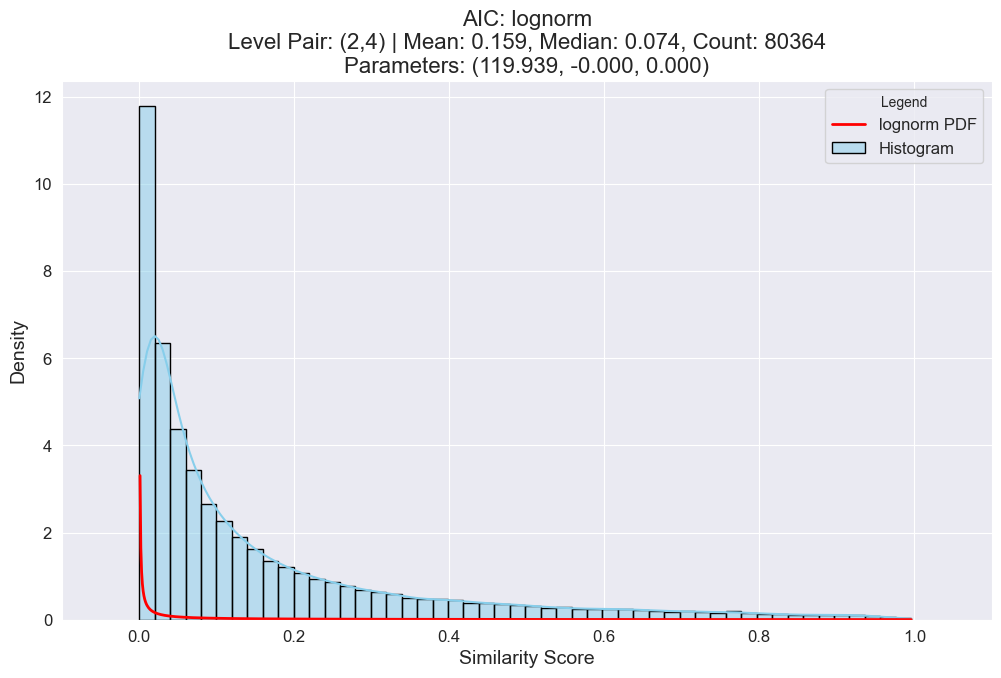

/Users/macbook/UTILS/anaconda3/envs/massspecgym/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2036: RuntimeWarning: overflow encountered in divide
  place(output, cond, self._pdf(*goodargs) / scale)


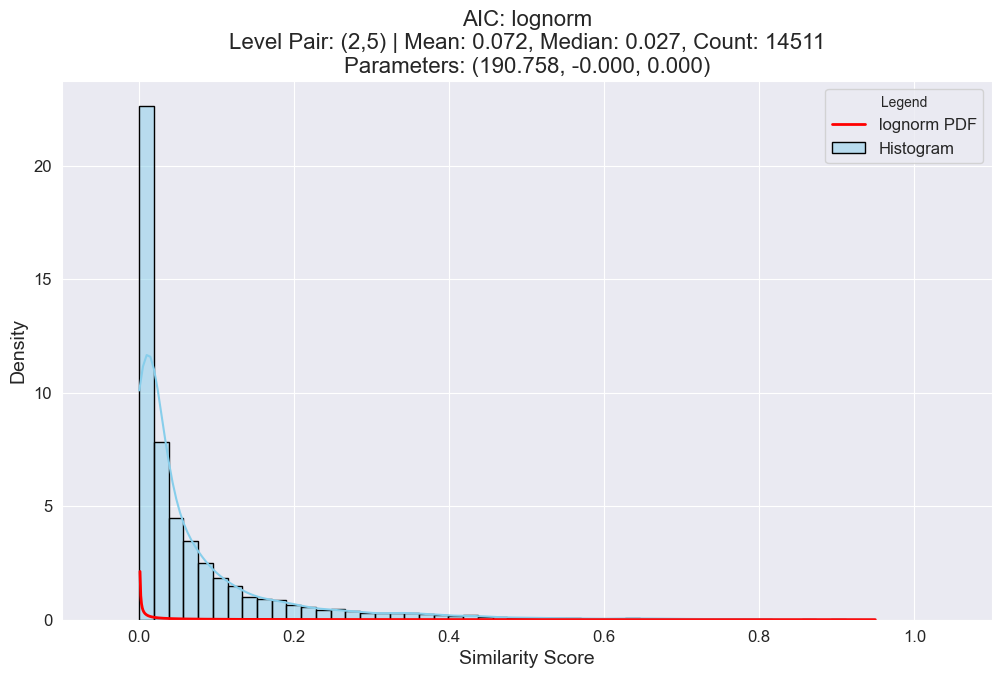

/Users/macbook/UTILS/anaconda3/envs/massspecgym/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2036: RuntimeWarning: overflow encountered in divide
  place(output, cond, self._pdf(*goodargs) / scale)


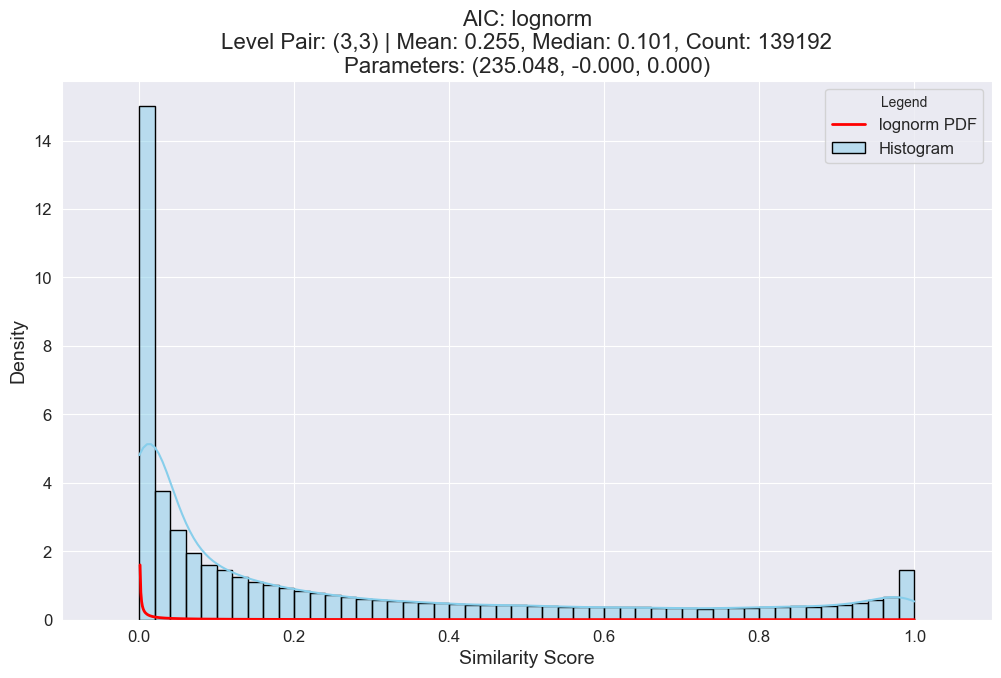

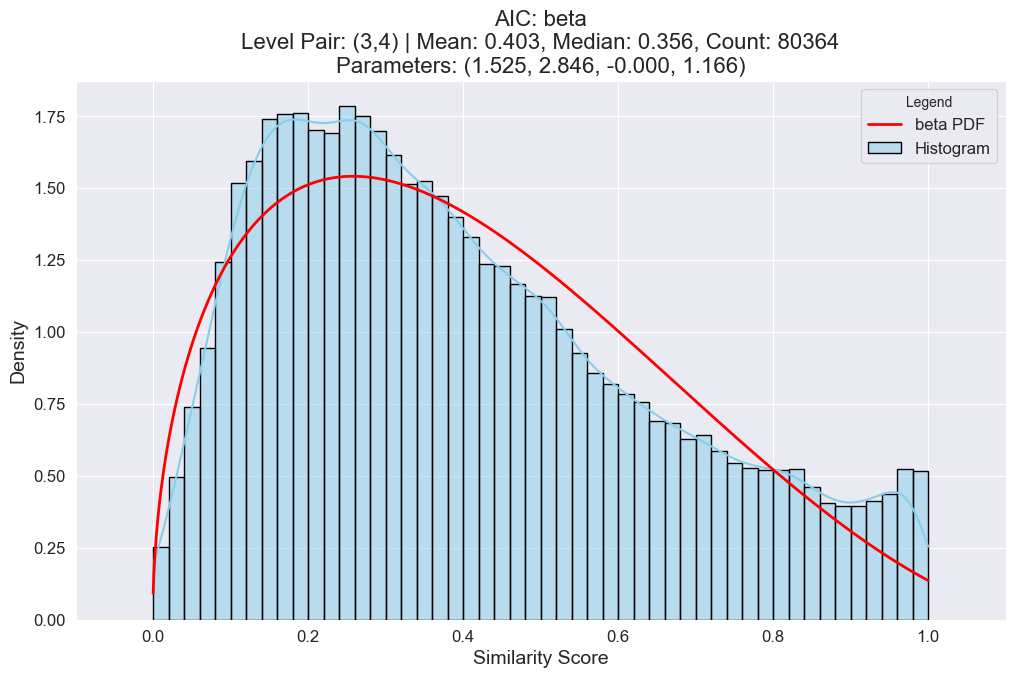

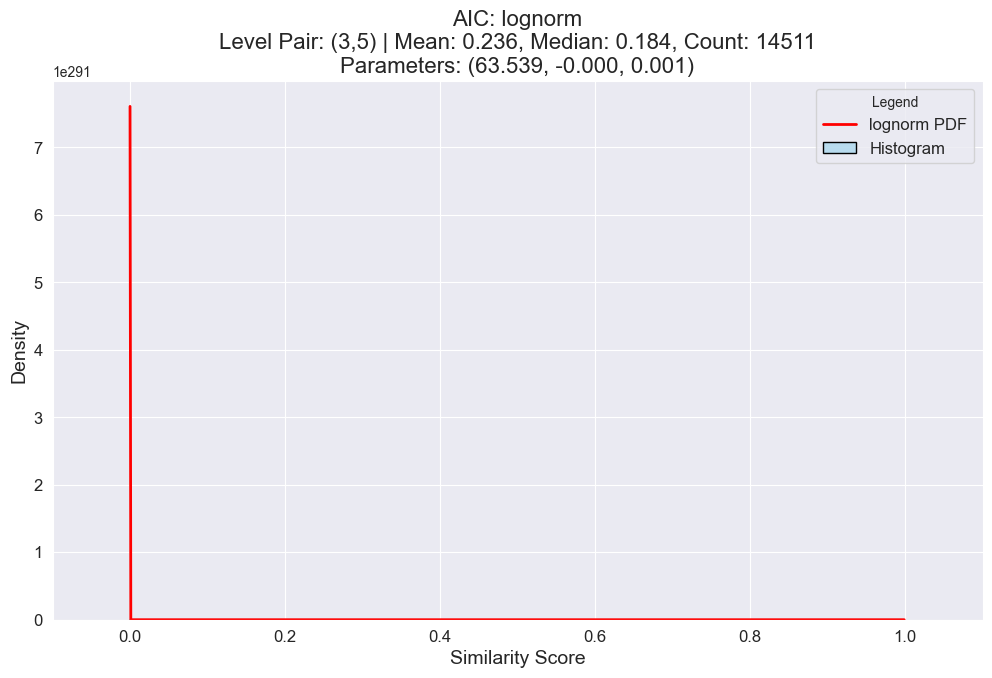

/Users/macbook/UTILS/anaconda3/envs/massspecgym/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2036: RuntimeWarning: overflow encountered in divide
  place(output, cond, self._pdf(*goodargs) / scale)


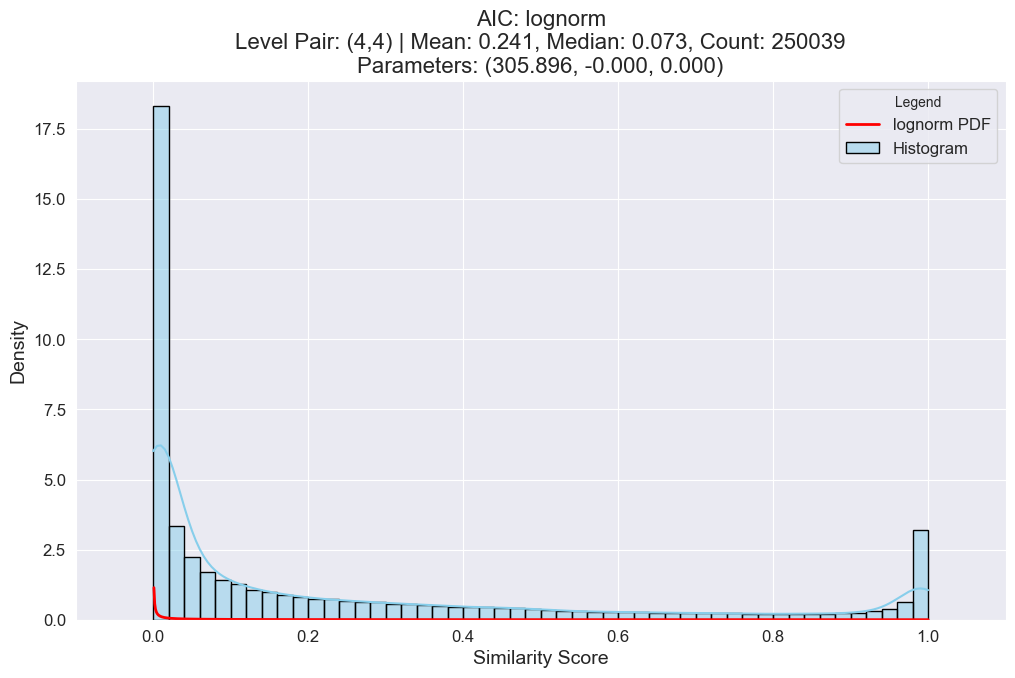

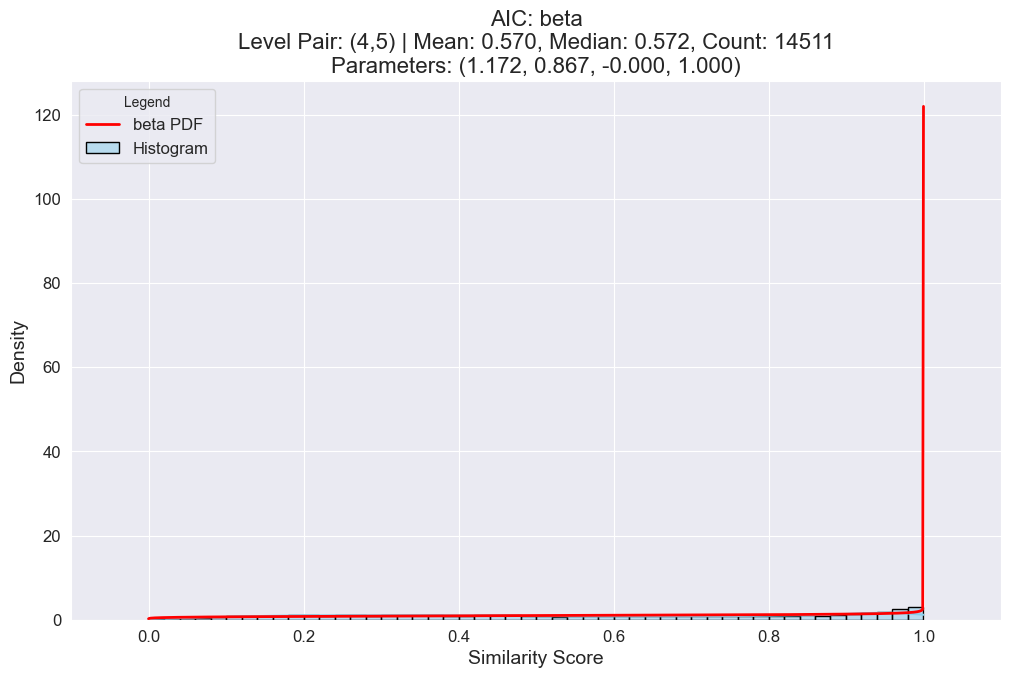

/Users/macbook/UTILS/anaconda3/envs/massspecgym/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2036: RuntimeWarning: overflow encountered in divide
  place(output, cond, self._pdf(*goodargs) / scale)


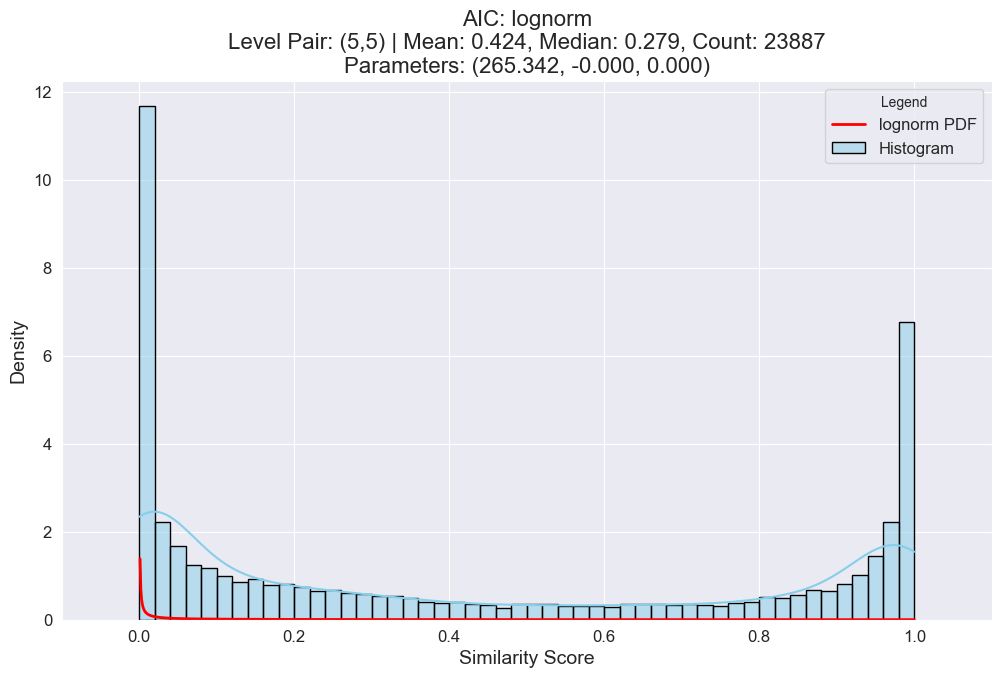

In [43]:
# Plotting Best-Fitting Distributions Based on AIC
print("\nPlotting Best-Fitting Distributions Based on AIC:")
plot_best_fit(
    summary_df=aic_summary_df,
    all_level_sims=all_level_sims_hung,
    criterion='AIC',
    save_plots=False  # Set to True to save plots as PNG files
)

In [44]:
# # Extract similarity scores for (2,2)
# sims_2_2 = all_level_sims_hung.get((2, 2), [])
# 
# # Identify the best-fitting distribution
# best_fit_dist = identify_best_fit_distribution(sims_2_2)
# 
# # Plot histogram with best-fitting distribution
# if best_fit_dist is not None:
#     plot_histogram_with_best_fit(sims_2_2, best_fit_dist, "Histogram and KDE with Best-Fitting Distribution")

In [45]:
# Generate the summary table
summary_table = summarize_all_level_pairs(all_level_sims_hung)

# Display the summary table
print("\nBest-Fitting Distributions for All Level Pairs:")
display(summary_table)


Fitting distributions for Level Pair (2, 3) with 71933 scores...

Fitting distributions for Level Pair (2, 4) with 80364 scores...

Fitting distributions for Level Pair (3, 3) with 139192 scores...

Fitting distributions for Level Pair (3, 4) with 80364 scores...

Fitting distributions for Level Pair (4, 4) with 250039 scores...

Fitting distributions for Level Pair (2, 5) with 14511 scores...

Fitting distributions for Level Pair (3, 5) with 14511 scores...

Fitting distributions for Level Pair (4, 5) with 14511 scores...

Fitting distributions for Level Pair (5, 5) with 23887 scores...

Fitting distributions for Level Pair (2, 2) with 500 scores...

Best-Fitting Distributions for All Level Pairs:


(   Distribution                                         Parameters  \
 0          beta  (0.9529189668699778, 2.1430406223244924, -1.57...   
 1   weibull_min  (1.2124347883121667, -0.0008508629037633147, 0...   
 2         gamma  (1.247510526508711, -0.0007953053784309521, 0....   
 3       lognorm  (0.6717420620441968, -0.09993517911944097, 0.4...   
 4   weibull_max  (141373146.89470714, 32791666.38793264, 327916...   
 5   weibull_min  (0.7453535431238589, -1.0705943309842896e-30, ...   
 6        pareto  (2.002329621328352, -0.18230990420184898, 0.18...   
 7         gamma  (0.576079908061335, -5.4385845413828965e-31, 0...   
 8          beta  (0.46856270451909277, 2.495022325184895, -4.29...   
 9         expon                         (0.0, 0.15920017039996986)   
 10       pareto  (0.645866249499667, -0.03056486974734716, 0.03...   
 11  weibull_min  (0.507421604591606, -5.346976874343505e-29, 0....   
 12         beta  (0.3981177561468062, 0.8409864083573237, -2.44...   
 13  w

In [46]:
# Generate the summary table
summary_table = summarize_all_level_pairs(all_level_sims_hung)

# Display the summary table
print("\nBest-Fitting Distributions for All Level Pairs:")
display(summary_table)


Fitting distributions for Level Pair (2, 3) with 71933 scores...

Fitting distributions for Level Pair (2, 4) with 80364 scores...

Fitting distributions for Level Pair (3, 3) with 139192 scores...

Fitting distributions for Level Pair (3, 4) with 80364 scores...

Fitting distributions for Level Pair (4, 4) with 250039 scores...

Fitting distributions for Level Pair (2, 5) with 14511 scores...

Fitting distributions for Level Pair (3, 5) with 14511 scores...

Fitting distributions for Level Pair (4, 5) with 14511 scores...

Fitting distributions for Level Pair (5, 5) with 23887 scores...

Fitting distributions for Level Pair (2, 2) with 500 scores...

Best-Fitting Distributions for All Level Pairs:


(   Distribution                                         Parameters  \
 0          beta  (0.9529189668699778, 2.1430406223244924, -1.57...   
 1   weibull_min  (1.2124347883121667, -0.0008508629037633147, 0...   
 2         gamma  (1.247510526508711, -0.0007953053784309521, 0....   
 3       lognorm  (0.6717420620441968, -0.09993517911944097, 0.4...   
 4   weibull_max  (141373146.89470714, 32791666.38793264, 327916...   
 5   weibull_min  (0.7453535431238589, -1.0705943309842896e-30, ...   
 6        pareto  (2.002329621328352, -0.18230990420184898, 0.18...   
 7         gamma  (0.576079908061335, -5.4385845413828965e-31, 0...   
 8          beta  (0.46856270451909277, 2.495022325184895, -4.29...   
 9         expon                         (0.0, 0.15920017039996986)   
 10       pareto  (0.645866249499667, -0.03056486974734716, 0.03...   
 11  weibull_min  (0.507421604591606, -5.346976874343505e-29, 0....   
 12         beta  (0.3981177561468062, 0.8409864083573237, -2.44...   
 13  w

In [47]:
all_level_sims_hung.keys()

dict_keys([(2, 3), (2, 4), (3, 3), (3, 4), (4, 4), (2, 5), (3, 5), (4, 5), (5, 5), (2, 2)])

In [48]:
len(all_level_sims_hung[(2,3)])

71933

In [49]:
type(all_level_sims_hung[(2,3)])

list

In [50]:
all_level_sims_hung[(2,3)][0]

0.09482385185445195

In [51]:
type(all_level_sims_hung[(2,3)][0])

float

In [52]:
len(all_level_sims_hung[(2,2)])

500

In [53]:
all_level_sims_hung[(2,2)][0]

0.029566219173215544

## Correlation

In [54]:
# Convert the dictionary to a DataFrame
data = []
for level_pair, sims in all_level_sims_hung.items():
    lvlA, lvlB = level_pair
    data.append({
        'Level_A': lvlA,
        'Level_B': lvlB,
        'Similarity_Scores': sims
    })

df = pd.DataFrame(data)

In [55]:
# Function to compute statistics
def compute_statistics(row):
    sims = row['Similarity_Scores']
    return pd.Series({
        'Mean_Similarity': np.mean(sims),
        'Median_Similarity': np.median(sims),
        'Std_Similarity': np.std(sims),
        'Count': len(sims),
        'Min_Level': min(row['Level_A'], row['Level_B']),
        'Max_Level': max(row['Level_A'], row['Level_B']),
        'Avg_Level': (row['Level_A'] + row['Level_B']) / 2,
        'Level_Difference': abs(row['Level_A'] - row['Level_B'])
    })

# Apply the function to each row
stats_df = df.apply(compute_statistics, axis=1)

# Combine with original DataFrame if needed
df_stats = pd.concat([df, stats_df], axis=1)

# Display the DataFrame with statistics
display(df_stats)

Level_A  Level_B                                  Similarity_Scores  \
0        2        3  [0.09482385185445195, 0.8912841082529714, 0.00...   
1        2        4  [0.005919828689851691, 0.001820470000688197, 0...   
2        3        3  [0.07014378596781198, 0.5454345735326523, 0.0,...   
3        3        4  [0.5756669539237175, 0.1869511803622772, 0.755...   
4        4        4  [0.4143261690514941, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
5        2        5  [0.05456264309397094, 0.0, 0.05503910775680427...   
6        3        5  [0.16923158673220134, 0.026852419768683314, 0....   
7        4        5  [0.4296082776067361, 0.14487559927419574, 0.65...   
8        5        5  [0.0034051087972177237, 0.27212079082509977, 0...   
9        2        2  [0.029566219173215544, 5.9475197241021546e-05,...   

   Mean_Similarity  Median_Similarity  Std_Similarity     Count  Min_Level  \
0         0.392914           0.323588        0.294467   71933.0        2.0   
1         0.159200           0.074344        0.202640   80364.0        2.0   
2         0.255479           0.100533        0.313105  139192.0        3.0   
3         0.402923           0.355645        0.245863   80364.0        3.0   
4         0.241203           0.072792        0.322015  250039.0        4.0   
5         0.071939           0.026582        0.114875   14511.0        2.0   
6         0.235871           0.184107        0.197325   14511.0        3.0   
7         0.569701           0.571747        0.296589   14511.0        4.0   
8         0.423661           0.279100        0.398949   23887.0        5.0   
9         0.020921           0.003300        0.066551     500.0        2.0   

   Max_Level  Avg_Level  Level_Difference  
0        3.0        2.5               1.0  
1        4.0        3.0               2.0  
2        3.0        3.0               0.0  
3        4.0        3.5               1.0  
4        4.0        4.0               0.0  
5        5.0        3.5               3.0  
6        5.0        4.0               2.0  
7        5.0        4.5               1.0  
8        5.0        5.0               0.0  
9        2.0        2.0               0.0

In [56]:
# Selecting relevant columns for correlation
corr_columns = ['Avg_Level', 'Level_Difference', 'Mean_Similarity', 'Median_Similarity', 'Std_Similarity']

# Compute the correlation matrix
corr_matrix = df_stats[corr_columns].corr()

# Display the correlation matrix
print("Correlation Matrix:")
display(corr_matrix)

Correlation Matrix:


Avg_Level  Level_Difference  Mean_Similarity  \
Avg_Level          1.000000e+00     -7.691851e-17         0.579978   
Level_Difference  -7.691851e-17      1.000000e+00        -0.248829   
Mean_Similarity    5.799780e-01     -2.488293e-01         1.000000   
Median_Similarity  4.726725e-01     -8.392926e-02         0.945261   
Std_Similarity     6.042282e-01     -4.903616e-01         0.764027   

                   Median_Similarity  Std_Similarity  
Avg_Level                   0.472673        0.604228  
Level_Difference           -0.083929       -0.490362  
Mean_Similarity             0.945261        0.764027  
Median_Similarity           1.000000        0.514162  
Std_Similarity              0.514162        1.000000

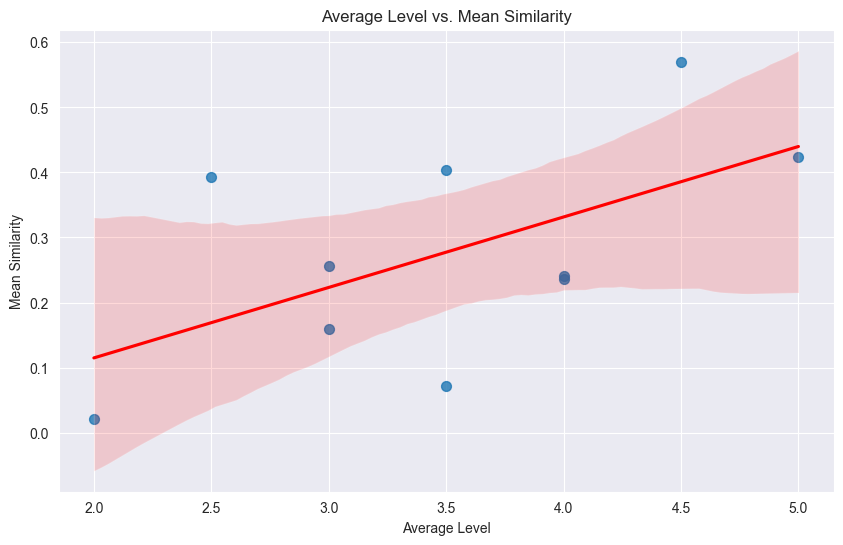

In [57]:
plt.figure(figsize=(10, 6))
sns.regplot(x='Avg_Level', y='Mean_Similarity', data=df_stats, scatter_kws={'s':50}, line_kws={'color':'red'})
plt.title('Average Level vs. Mean Similarity')
plt.xlabel('Average Level')
plt.ylabel('Mean Similarity')
plt.show()

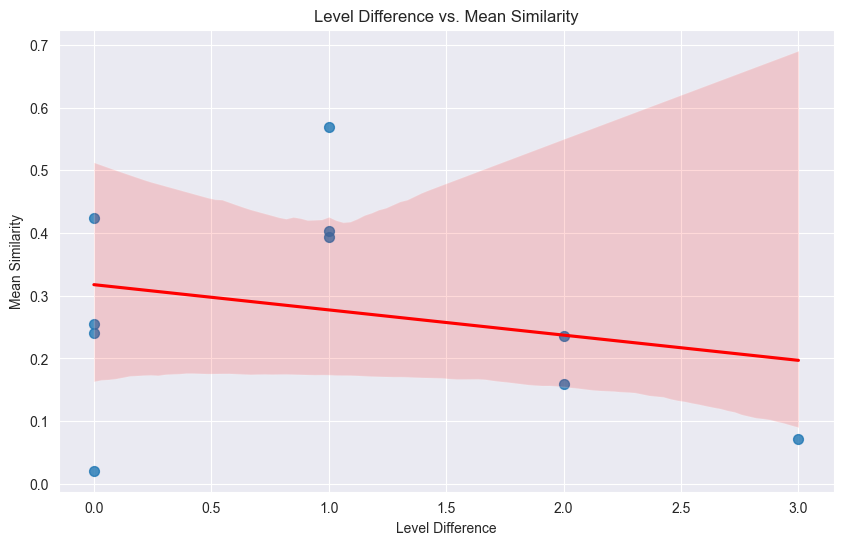

In [58]:
plt.figure(figsize=(10, 6))
sns.regplot(x='Level_Difference', y='Mean_Similarity', data=df_stats, scatter_kws={'s':50}, line_kws={'color':'red'})
plt.title('Level Difference vs. Mean Similarity')
plt.xlabel('Level Difference')
plt.ylabel('Mean Similarity')
plt.show()

/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_26379/3728132525.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Avg_Level', y='Mean_Similarity', data=df_stats, palette='Set2')


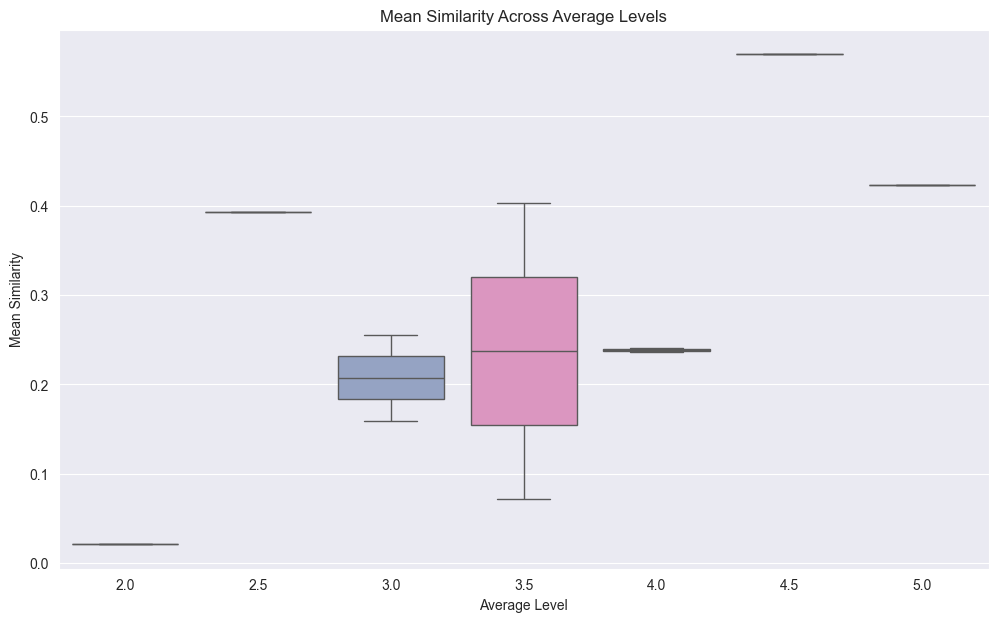

In [59]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Avg_Level', y='Mean_Similarity', data=df_stats, palette='Set2')
plt.title('Mean Similarity Across Average Levels')
plt.xlabel('Average Level')
plt.ylabel('Mean Similarity')
plt.show()

/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_26379/933056188.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Level_Difference', y='Median_Similarity', data=df_stats, palette='Set1')


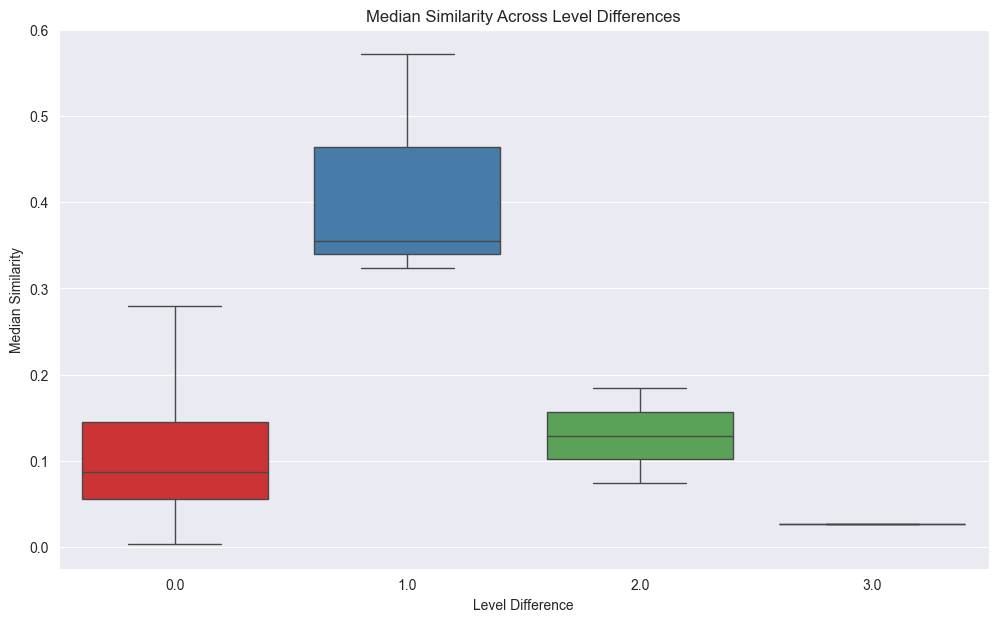

In [60]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Level_Difference', y='Median_Similarity', data=df_stats, palette='Set1')
plt.title('Median Similarity Across Level Differences')
plt.xlabel('Level Difference')
plt.ylabel('Median Similarity')
plt.show()

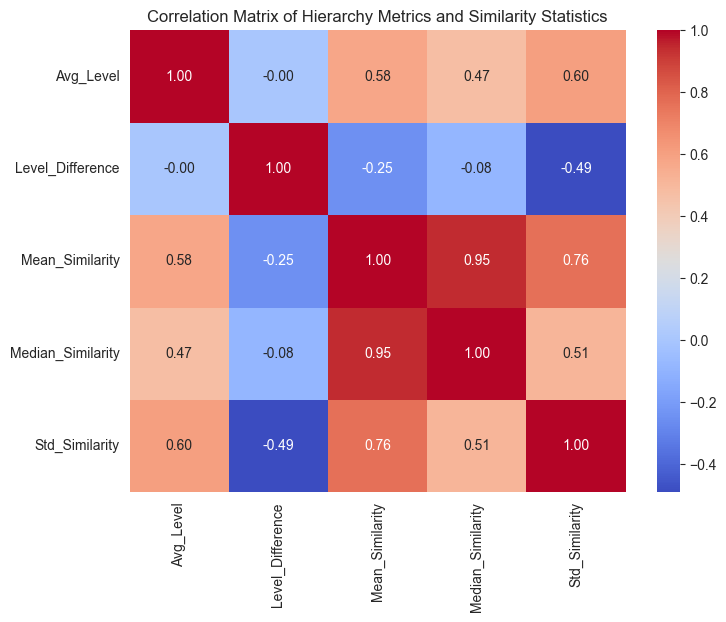

In [61]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Hierarchy Metrics and Similarity Statistics')
plt.show()

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Set Seaborn style
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 12})

# ===========================
# 1. Data Preparation
# ===========================



# Convert the dictionary to a DataFrame
data = []
for level_pair, sims in all_level_sims_hung.items():
    lvlA, lvlB = level_pair
    for sim in sims:
        data.append({
            'Level_A': lvlA,
            'Level_B': lvlB,
            'Similarity_Score': sim
        })

df = pd.DataFrame(data)

# Compute Avg_Level and Level_Difference
df['Avg_Level'] = df[['Level_A', 'Level_B']].mean(axis=1)
df['Level_Difference'] = abs(df['Level_A'] - df['Level_B'])

# Create a categorical variable for Level_Pair
df['Level_Pair'] = df.apply(lambda row: f"{row['Level_A']},{row['Level_B']}", axis=1)

# Display the first few rows
display(df.head())

# Group by Level Pair and compute descriptive statistics
grouped = df.groupby(['Level_A', 'Level_B'])

# Compute mean, median, std, and count similarity scores
stats_df = grouped['Similarity_Score'].agg(['mean', 'median', 'std', 'count']).reset_index()
stats_df.rename(columns={
    'mean': 'Mean_Similarity',
    'median': 'Median_Similarity',
    'std': 'Std_Similarity',
    'count': 'Count'
}, inplace=True)

# Compute additional hierarchy metrics
stats_df['Avg_Level'] = stats_df[['Level_A', 'Level_B']].mean(axis=1)
stats_df['Level_Difference'] = abs(stats_df['Level_A'] - stats_df['Level_B'])

# Display the summary statistics
display(stats_df)


Level_A  Level_B  Similarity_Score  Avg_Level  Level_Difference Level_Pair
0        2        3          0.094824        2.5                 1    2.0,3.0
1        2        3          0.891284        2.5                 1    2.0,3.0
2        2        3          0.005303        2.5                 1    2.0,3.0
3        2        3          0.189323        2.5                 1    2.0,3.0
4        2        3          0.898551        2.5                 1    2.0,3.0

Level_A  Level_B  Mean_Similarity  Median_Similarity  Std_Similarity  \
0        2        2         0.020921           0.003300        0.066618   
1        2        3         0.392914           0.323588        0.294469   
2        2        4         0.159200           0.074344        0.202641   
3        2        5         0.071939           0.026582        0.114879   
4        3        3         0.255479           0.100533        0.313106   
5        3        4         0.402923           0.355645        0.245865   
6        3        5         0.235871           0.184107        0.197331   
7        4        4         0.241203           0.072792        0.322016   
8        4        5         0.569701           0.571747        0.296600   
9        5        5         0.423661           0.279100        0.398957   

    Count  Avg_Level  Level_Difference  
0     500        2.0                 0  
1   71933        2.5                 1  
2   80364        3.0                 2  
3   14511        3.5                 3  
4  139192        3.0                 0  
5   80364        3.5                 1  
6   14511        4.0                 2  
7  250039        4.0                 0  
8   14511        4.5                 1  
9   23887        5.0                 0

In [63]:
df.shape

(689812, 6)

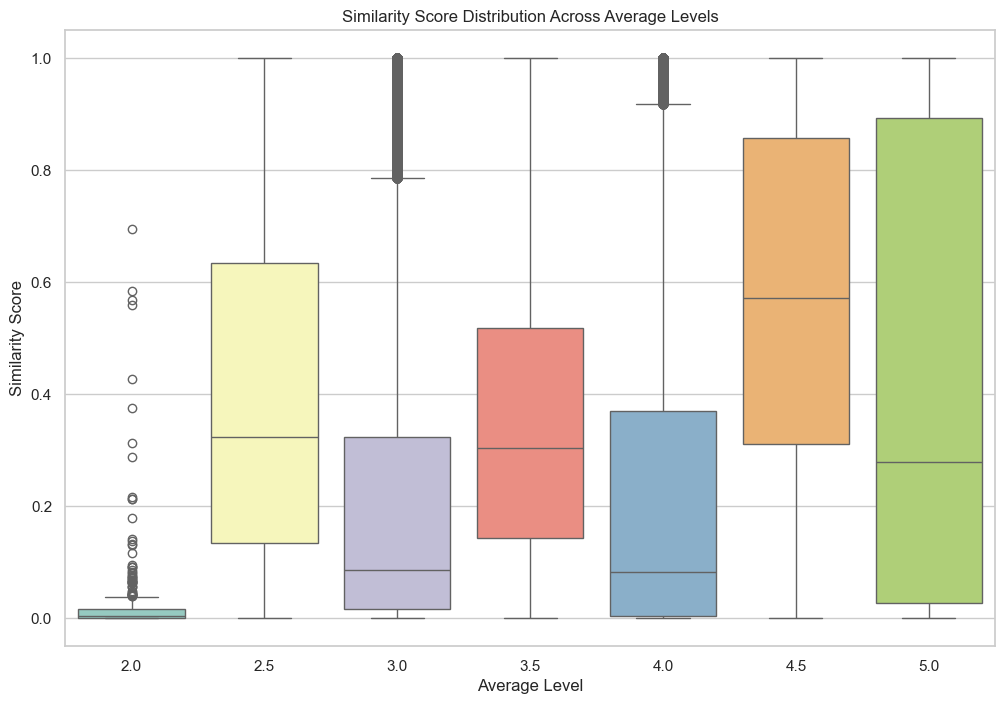

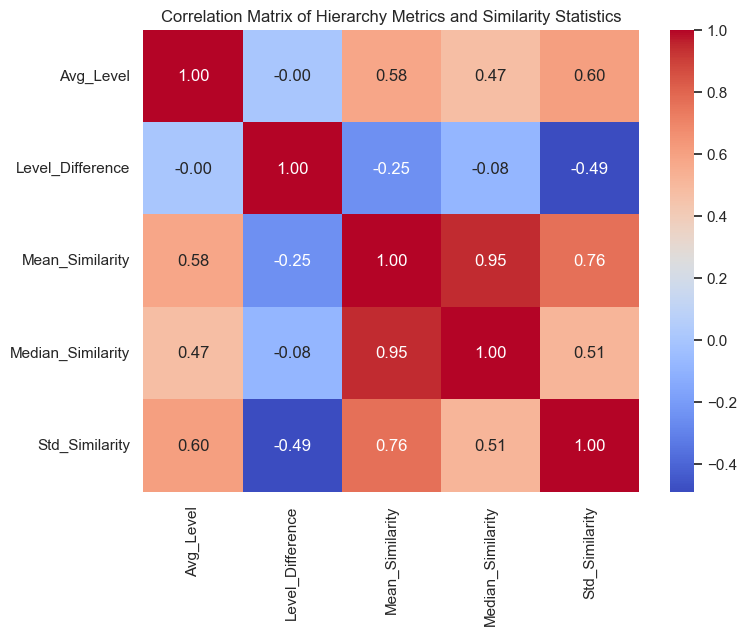

In [64]:
# ===========================
# 2. Exploratory Data Analysis (EDA)
# ===========================

# Box Plot: Similarity Score Distribution Across Average Levels
plt.figure(figsize=(12, 8))
sns.boxplot(x='Avg_Level', y='Similarity_Score', data=df, palette='Set3')
plt.title('Similarity Score Distribution Across Average Levels')
plt.xlabel('Average Level')
plt.ylabel('Similarity Score')
plt.show()

# Scatter Plot: Avg_Level vs. Similarity_Score colored by Level_Difference
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='Avg_Level', y='Similarity_Score', hue='Level_Difference', size='Level_Difference',
#                 sizes=(50, 200), palette='viridis', alpha=0.7, data=df)
# plt.title('Average Level vs. Similarity Score')
# plt.xlabel('Average Level')
# plt.ylabel('Similarity Score')
# plt.legend(title='Level Difference', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.show()

# Heatmap of Correlation Matrix
corr_matrix = stats_df[['Avg_Level', 'Level_Difference', 'Mean_Similarity', 'Median_Similarity', 'Std_Similarity']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Hierarchy Metrics and Similarity Statistics')
plt.show()

In [65]:
# ===========================
# 3. Correlation Analysis
# ===========================

# Pearson Correlation between Avg_Level and Mean_Similarity
pearson_corr, pearson_p = stats.pearsonr(stats_df['Avg_Level'], stats_df['Mean_Similarity'])
print(f"Pearson Correlation between Avg_Level and Mean_Similarity: {pearson_corr:.3f}")
print(f"P-value: {pearson_p:.3f}\n")

# Spearman Correlation between Avg_Level and Mean_Similarity
spearman_corr, spearman_p = stats.spearmanr(stats_df['Avg_Level'], stats_df['Mean_Similarity'])
print(f"Spearman Correlation between Avg_Level and Mean_Similarity: {spearman_corr:.3f}")
print(f"P-value: {spearman_p:.3f}\n")

# Pearson Correlation between Level_Difference and Mean_Similarity
pearson_corr_ld, pearson_p_ld = stats.pearsonr(stats_df['Level_Difference'], stats_df['Mean_Similarity'])
print(f"Pearson Correlation between Level_Difference and Mean_Similarity: {pearson_corr_ld:.3f}")
print(f"P-value: {pearson_p_ld:.3f}\n")

# Spearman Correlation between Level_Difference and Mean_Similarity
spearman_corr_ld, spearman_p_ld = stats.spearmanr(stats_df['Level_Difference'], stats_df['Mean_Similarity'])
print(f"Spearman Correlation between Level_Difference and Mean_Similarity: {spearman_corr_ld:.3f}")
print(f"P-value: {spearman_p_ld:.3f}\n")

Pearson Correlation between Avg_Level and Mean_Similarity: 0.580
P-value: 0.079

Spearman Correlation between Avg_Level and Mean_Similarity: 0.569
P-value: 0.086

Pearson Correlation between Level_Difference and Mean_Similarity: -0.249
P-value: 0.488

Spearman Correlation between Level_Difference and Mean_Similarity: -0.261
P-value: 0.467



In [66]:
# Pearson correlation between Avg_Level and Similarity_Score
pearson_corr, pearson_p = stats.pearsonr(df['Avg_Level'], df['Similarity_Score'])
print(f"Pearson Correlation between Avg_Level and Similarity_Score: {pearson_corr:.3f}")
print(f"P-value: {pearson_p:.3f}")

Pearson Correlation between Avg_Level and Similarity_Score: 0.021
P-value: 0.000


In [67]:
# Spearman Correlation between Level_Difference and Mean_Similarity
spearman_corr_ld, spearman_p_ld = stats.spearmanr(stats_df['Avg_Level'], stats_df['Mean_Similarity'])
print(f"Spearman Correlation between Avg_Level and Mean_Similarity: {spearman_corr_ld:.3f}")
print(f"P-value: {spearman_p_ld:.3f}\n")

Spearman Correlation between Avf_Difference and Mean_Similarity: 0.569
P-value: 0.086



In [68]:
# Spearman correlation between Avg_Level and Similarity_Score
spearman_corr, spearman_p = stats.spearmanr(df['Avg_Level'], df['Similarity_Score'])
print(f"Spearman Correlation between Avg_Level and Similarity_Score: {spearman_corr:.3f}")
print(f"P-value: {spearman_p:.3f}")

Spearman Correlation between Avg_Level and Similarity_Score: -0.063
P-value: 0.000


In [69]:
df.keys()

Index(['Level_A', 'Level_B', 'Similarity_Score', 'Avg_Level',
       'Level_Difference', 'Level_Pair'],
      dtype='object')

In [70]:
# ===========================
# 4. Regression Analysis
# ===========================

# Simple Linear Regression: Mean_Similarity ~ Avg_Level
X = sm.add_constant(stats_df['Avg_Level'])
y = stats_df['Mean_Similarity']

model = sm.OLS(y, X).fit()
print(model.summary())

# Multiple Linear Regression: Mean_Similarity ~ Avg_Level + Level_Difference
X_multi = sm.add_constant(stats_df[['Avg_Level', 'Level_Difference']])
y_multi = stats_df['Mean_Similarity']

model_multi = sm.OLS(y_multi, X_multi).fit()
print(model_multi.summary())

                            OLS Regression Results                            
Dep. Variable:        Mean_Similarity   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     4.055
Date:                Mon, 30 Dec 2024   Prob (F-statistic):             0.0788
Time:                        14:19:45   Log-Likelihood:                 6.0820
No. Observations:                  10   AIC:                            -8.164
Df Residuals:                       8   BIC:                            -7.559
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1016      0.194     -0.524      0.6

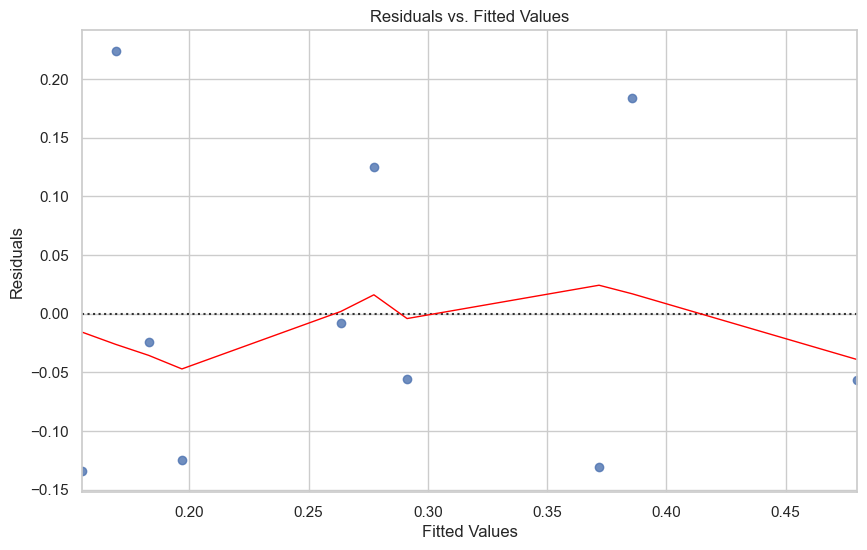

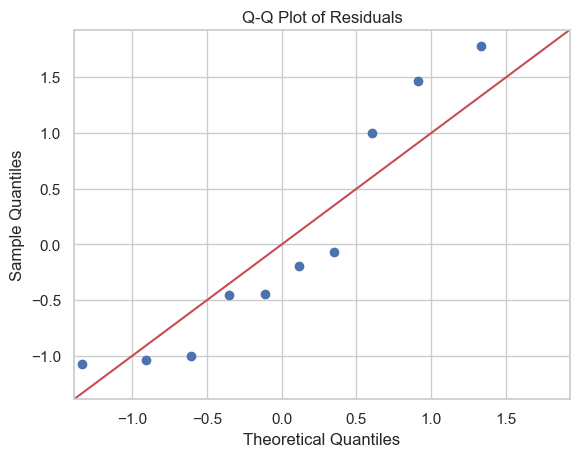

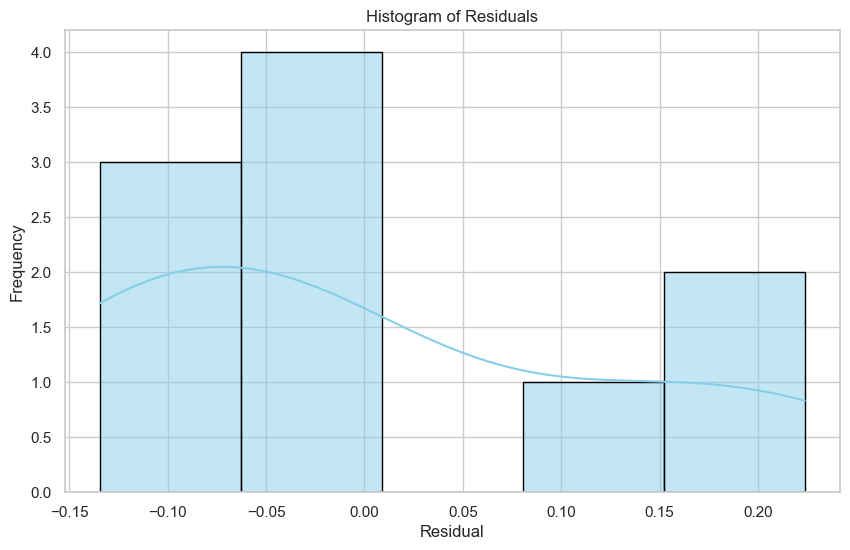

In [71]:
# Assessing Model Assumptions

# Residuals vs. Fitted Values
# 	•	Homogeneity of Variance: The spread of residuals should be consistent across all levels of fitted values.
# 	•	No Patterns: Residuals should be randomly scattered without discernible patterns, indicating linearity.
plt.figure(figsize=(10, 6))
sns.residplot(x=model_multi.fittedvalues, y=model_multi.resid, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

# Q-Q Plot for Normality of Residuals
# Normality: Points should lie approximately along the 45-degree line, suggesting that residuals are normally distributed.
sm.qqplot(model_multi.resid, line='45', fit=True)
plt.title('Q-Q Plot of Residuals')
plt.show()

# Histogram of Residuals
# 	•	Symmetry: The histogram should be symmetric around zero.
# 	•	KDE Overlay: The Kernel Density Estimate should resemble a normal distribution.
plt.figure(figsize=(10, 6))
sns.histplot(model_multi.resid, kde=True, color='skyblue', edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

In [78]:
# ===========================
# 4. Regression Analysis
# ===========================

# Simple Linear Regression: Mean_Similarity ~ Avg_Level
X = sm.add_constant(df['Avg_Level'])
y = df['Similarity_Score']

model = sm.OLS(y, X).fit()
print(model.summary())

# Multiple Linear Regression: Mean_Similarity ~ Avg_Level + Level_Difference
X_multi = sm.add_constant(df[['Avg_Level', 'Level_Difference']])
y_multi = df['Similarity_Score']

model_multi = sm.OLS(y_multi, X_multi).fit()
print(model_multi.summary())

                            OLS Regression Results                            
Dep. Variable:       Similarity_Score   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     315.7
Date:                Mon, 30 Dec 2024   Prob (F-statistic):           1.31e-70
Time:                        14:37:33   Log-Likelihood:            -1.6907e+05
No. Observations:              689812   AIC:                         3.381e+05
Df Residuals:                  689810   BIC:                         3.382e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2410      0.002    112.356      0.0

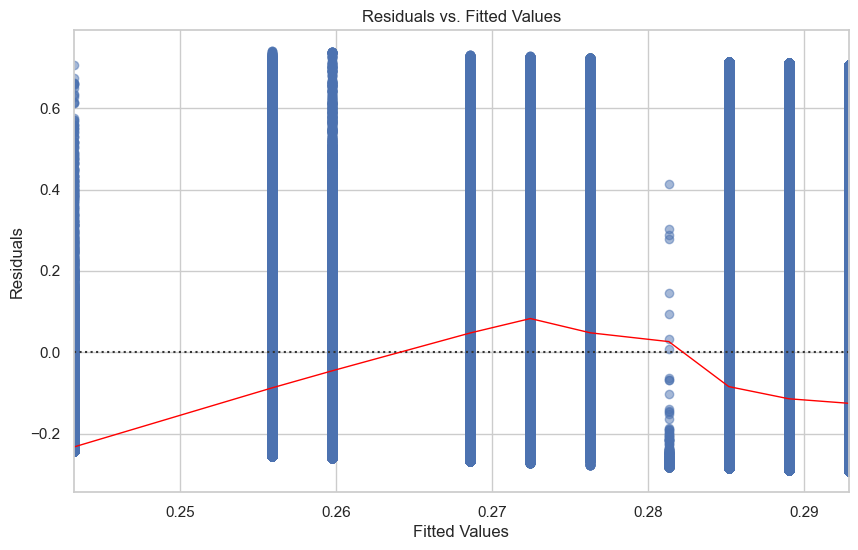

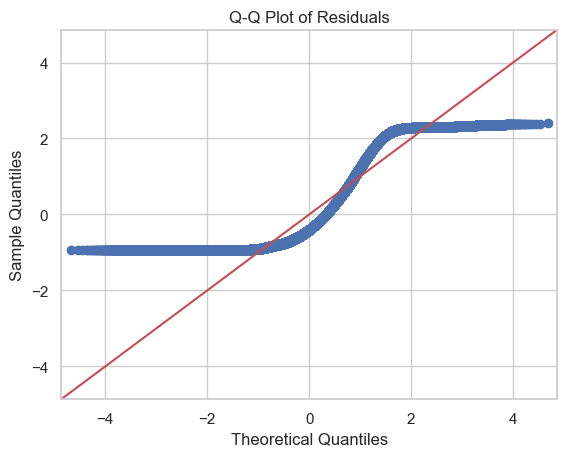

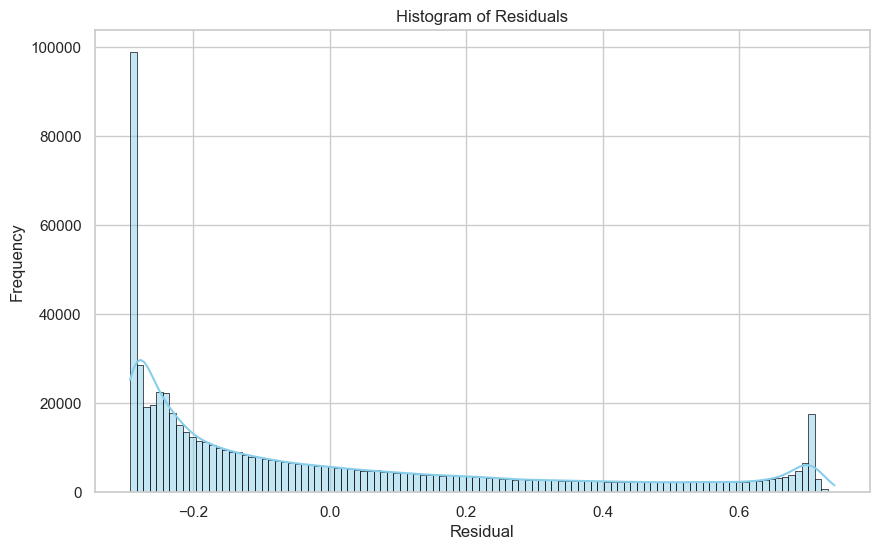

In [83]:
# Assessing Model Assumptions

# Residuals vs. Fitted Values
# 	•	Homogeneity of Variance: The spread of residuals should be consistent across all levels of fitted values.
# 	•	No Patterns: Residuals should be randomly scattered without discernible patterns, indicating linearity.
plt.figure(figsize=(10, 6))
sns.residplot(x=model_multi.fittedvalues, y=model_multi.resid, lowess=True, line_kws={'color': 'red', 'lw': 1}, scatter_kws={'alpha':0.5})
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

# Q-Q Plot for Normality of Residuals
# Normality: Points should lie approximately along the 45-degree line, suggesting that residuals are normally distributed.
sm.qqplot(model_multi.resid, line='45', fit=True, )
plt.title('Q-Q Plot of Residuals')
plt.show()

# Histogram of Residuals
# 	•	Symmetry: The histogram should be symmetric around zero.
# 	•	KDE Overlay: The Kernel Density Estimate should resemble a normal distribution.
plt.figure(figsize=(10, 6))
sns.histplot(model_multi.resid, kde=True, color='skyblue', edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Similarity_Score
No. Observations: 689812  Method:             REML            
No. Groups:       10      Scale:              0.0867          
Min. group size:  500     Log-Likelihood:     -135451.2653    
Max. group size:  250039  Converged:          Yes             
Mean group size:  68981.2                                     
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept           -0.061    0.399 -0.153 0.878 -0.843  0.721
Avg_Level            0.108    0.108  1.006 0.314 -0.103  0.319
Level_Difference    -0.040    0.093 -0.432 0.666 -0.223  0.142
Group Var            0.087                                    



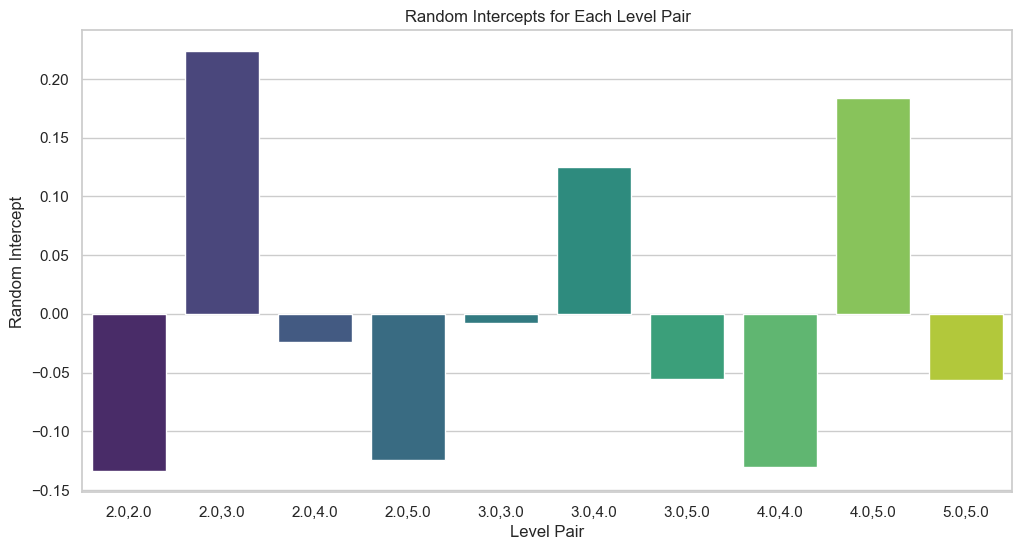

In [72]:
# ===========================
# 5. Hierarchical (Multilevel) Modeling
# ===========================
# Given that multiple similarity scores are nested within each level pair, hierarchical (multilevel) modeling
# is appropriate. This approach accounts for both fixed effects (e.g., hierarchy metrics) and
# random effects (e.g., variability between level pairs).

# Fit the mixed-effects model
md = smf.mixedlm("Similarity_Score ~ Avg_Level + Level_Difference", df, groups=df["Level_Pair"])
mdf = md.fit()

# Print the model summary
print(mdf.summary())

# Extract random effects
random_effects = mdf.random_effects

# Convert to DataFrame for plotting
random_effects_df = pd.DataFrame.from_dict(random_effects, orient='index').reset_index()
random_effects_df.columns = ['Level_Pair', 'Random_Intercept']

# Plot the random intercepts
# Interpretation:
# 	•	Positive Random Intercept: Indicates that the level pair has a higher-than-average similarity score.
# 	•	Negative Random Intercept: Indicates that the level pair has a lower-than-average similarity score.
plt.figure(figsize=(12, 6))
sns.barplot(x='Level_Pair', y='Random_Intercept', data=random_effects_df, palette='viridis')
plt.title('Random Intercepts for Each Level Pair')
plt.xlabel('Level Pair')
plt.ylabel('Random Intercept')
plt.show()

                            OLS Regression Results                            
Dep. Variable:        Mean_Similarity   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     1.363
Date:                Mon, 30 Dec 2024   Prob (F-statistic):              0.341
Time:                        14:19:47   Log-Likelihood:                 6.6299
No. Observations:                  10   AIC:                            -5.260
Df Residuals:                       6   BIC:                            -4.049
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

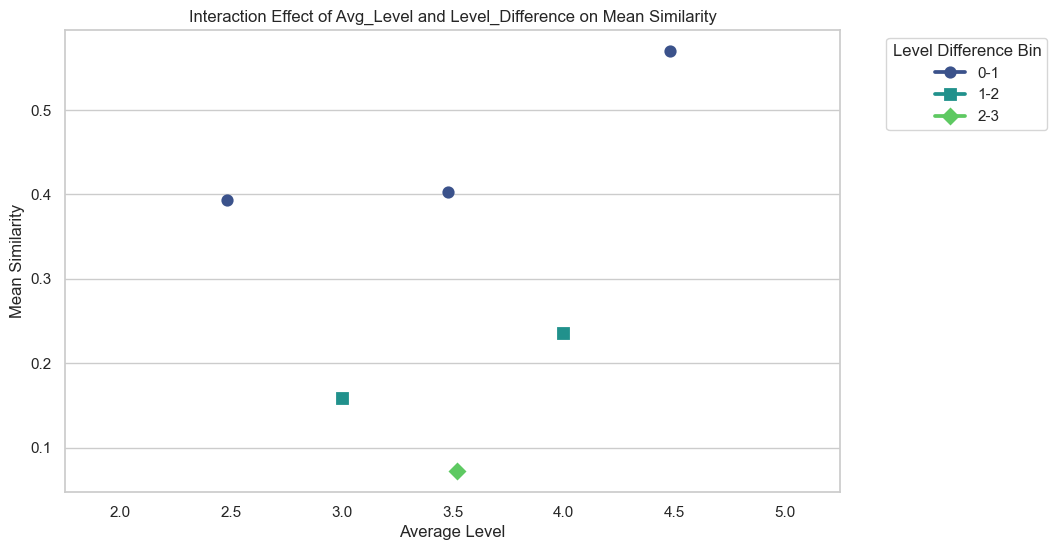

In [73]:
# ===========================
# 6. Multivariate Analysis
# ===========================

# Multiple Linear Regression with Interaction: Mean_Similarity ~ Avg_Level * Level_Difference
model_interaction = smf.ols("Mean_Similarity ~ Avg_Level * Level_Difference", data=stats_df).fit()
print(model_interaction.summary())

# Visualizing Interaction Effects
# Bin Level_Difference for visualization if necessary
stats_df['Level_Diff_Bin'] = pd.cut(stats_df['Level_Difference'], bins=[0,1,2,3], labels=['0-1','1-2','2-3'])

# Interpretation:
# 	•	The plot shows how the relationship between Avg_Level and Mean_Similarity varies across different bins of Level_Difference.
# 	•	Steeper negative slopes in higher Level_Difference bins indicate stronger negative relationships.
plt.figure(figsize=(10, 6))
sns.pointplot(x='Avg_Level', y='Mean_Similarity', hue='Level_Diff_Bin', data=stats_df,
              palette='viridis', dodge=True, markers=["o", "s", "D"], capsize=.1)
plt.title('Interaction Effect of Avg_Level and Level_Difference on Mean Similarity')
plt.xlabel('Average Level')
plt.ylabel('Mean Similarity')
plt.legend(title='Level Difference Bin', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## inter group investigation

In [144]:
data = []
for level_pair, sims in all_level_sims_hung.items():
    lvlA, lvlB = level_pair
    for sim in sims:
        data.append({
            'Level_A': lvlA,
            'Level_B': lvlB,
            'Similarity_Score': sim
        })

df = pd.DataFrame(data)

# Calculate additional hierarchy metrics
df['Avg_Level'] = df[['Level_A', 'Level_B']].mean(axis=1)
df['Level_Difference'] = abs(df['Level_A'] - df['Level_B'])
df['Level_Pair'] = df.apply(lambda row: f"{int(row['Level_A'])},{int(row['Level_B'])}", axis=1)

# Display the first few rows
print("Sample DataFrame:")
display(df.head())

Sample DataFrame:


Level_A  Level_B  Similarity_Score  Avg_Level  Level_Difference Level_Pair
0        2        3          0.094824        2.5                 1        2,3
1        2        3          0.891284        2.5                 1        2,3
2        2        3          0.005303        2.5                 1        2,3
3        2        3          0.189323        2.5                 1        2,3
4        2        3          0.898551        2.5                 1        2,3

In [145]:
# Example: Sampling 500 observations from each group
# df = df.groupby('Level_Pair').apply(lambda x: x.sample(n=500, random_state=42) if len(x) > 500 else x).reset_index(drop=True)

In [146]:
import scikit_posthocs as sp  # Ensure scikit_posthocs is installed: pip install scikit-posthocs
from scipy.stats import kruskal
import seaborn as sns
import matplotlib.pyplot as plt

# Filter intergroup data
intergroup_pairs = [(2,2), (3,3), (4,4), (5,5)]
intergroup_df = df[df['Level_Pair'].isin([f"{a},{b}" for a,b in intergroup_pairs])].copy()

# Ensure 'Level_Pair' is categorical
intergroup_df['Level_Pair'] = intergroup_df['Level_Pair'].astype('category')

# Check for NaNs and remove if any
intergroup_df = intergroup_df.dropna(subset=['Similarity_Score'])

# Perform Kruskal-Wallis H-test
groups = intergroup_df.groupby('Level_Pair')['Similarity_Score'].apply(list)

stat, p = kruskal(*groups)
print("Kruskal-Wallis H-test for Intergroup Comparison:")
print(f"Statistic: {stat:.3f}, p-value: {p:.3f}\n")



Kruskal-Wallis H-test for Intergroup Comparison:
Statistic: 380.781, p-value: 0.000



In [147]:
from scipy.stats import mannwhitneyu

In [148]:
# Get unique groups
groups = intergroup_df.groupby('Level_Pair')['Similarity_Score'].apply(list)

# Get all pairwise combinations
pairwise = list(combinations(groups.index, 2))

results = []
p_values = []

for g1, g2 in pairwise:
    stat, p = stats.mannwhitneyu(groups[g1], groups[g2], alternative='two-sided')
    results.append((g1, g2, stat, p))
    p_values.append(p)

# Adjust p-values for multiple comparisons using Bonferroni correction
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='bonferroni')

# Compile results
comparison_results = []
for i, (g1, g2, stat, p) in enumerate(results):
    comparison_results.append({
        "Group 1": g1,
        "Group 2": g2,
        "Statistic": stat,
        "p-value": p,
        "p-value Adjusted": pvals_corrected[i],
        "Significant": reject[i]
    })

comparison_df = pd.DataFrame(comparison_results)

print("Pairwise Mann-Whitney U Test with Bonferroni Correction:")
print(comparison_df)

Pairwise Mann-Whitney U Test with Bonferroni Correction:
  Group 1 Group 2  Statistic       p-value  p-value Adjusted  Significant
0     2,2     3,3    56309.0  2.933558e-51      1.760135e-50         True
1     2,2     4,4    75176.0  7.019286e-28      4.211572e-27         True
2     2,2     5,5    44589.0  1.425843e-69      8.555056e-69         True
3     3,3     4,4   135046.0  2.736229e-02      1.641738e-01        False
4     3,3     5,5    95436.0  9.085700e-11      5.451420e-10         True
5     4,4     5,5    89255.5  4.130446e-15      2.478268e-14         True


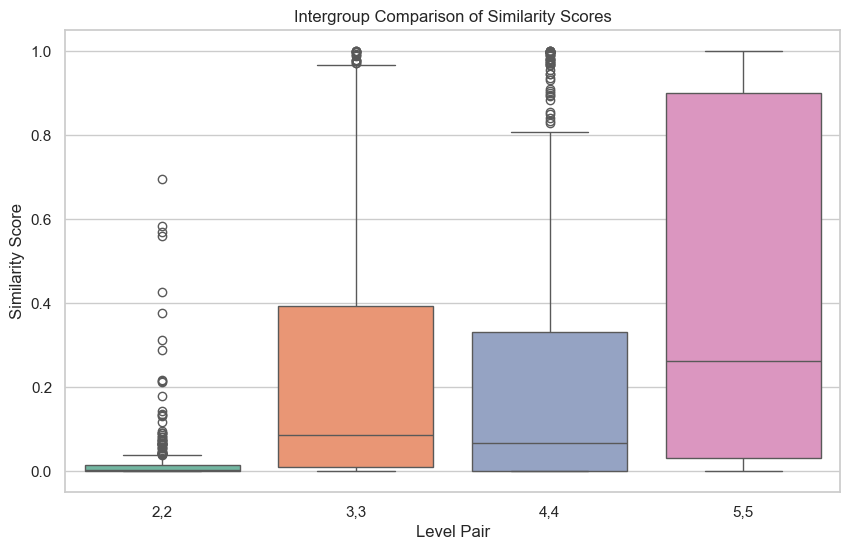

In [149]:
# Visualization: Box Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Level_Pair', y='Similarity_Score', data=intergroup_df, palette='Set2')
plt.title('Intergroup Comparison of Similarity Scores')
plt.xlabel('Level Pair')
plt.ylabel('Similarity Score')
plt.show()

In [150]:
intergroup_df['Hierarchy_Level'] = intergroup_df['Level_Pair'].apply(lambda x: int(x.split(',')[0]))

# Calculate summary statistics
summary_df = intergroup_df.groupby('Hierarchy_Level')['Similarity_Score'].agg(['mean', 'median', 'std', 'count']).reset_index()
print("Summary Statistics by Hierarchy Level:")
print(summary_df)

Summary Statistics by Hierarchy Level:
  Hierarchy_Level      mean    median       std  count
0               2  0.020921  0.003300  0.066618    500
1               3  0.242367  0.087462  0.305653    500
2               4  0.221317  0.066965  0.302506    500
3               5  0.423232  0.261930  0.401864    500


In [151]:
# Perform Spearman's Rank Correlation between Hierarchy_Level and Similarity_Score
spearman_corr, spearman_p = stats.spearmanr(intergroup_df['Hierarchy_Level'], intergroup_df['Similarity_Score'])
print("Spearman Correlation for Intergroup Comparison:")
print(f"Correlation: {spearman_corr:.3f}, p-value: {spearman_p:.3f}\n")

# Interpretation
if spearman_p < 0.05:
    print("There is a significant monotonic relationship between Hierarchy Level and Similarity Score in the Intergroup.\n")
    if spearman_corr > 0:
        print("Higher hierarchy levels are associated with higher similarity scores.\n")
    else:
        print("Higher hierarchy levels are associated with lower similarity scores.\n")
else:
    print("No significant monotonic relationship found between Hierarchy Level and Similarity Score in the Intergroup.\n")

Spearman Correlation for Intergroup Comparison:
Correlation: 0.384, p-value: 0.000

There is a significant monotonic relationship between Hierarchy Level and Similarity Score in the Intergroup.

Higher hierarchy levels are associated with higher similarity scores.



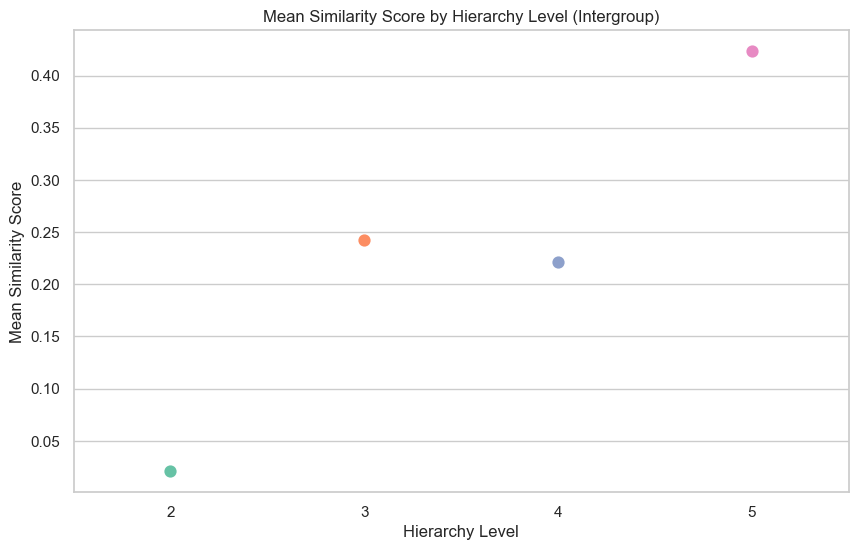

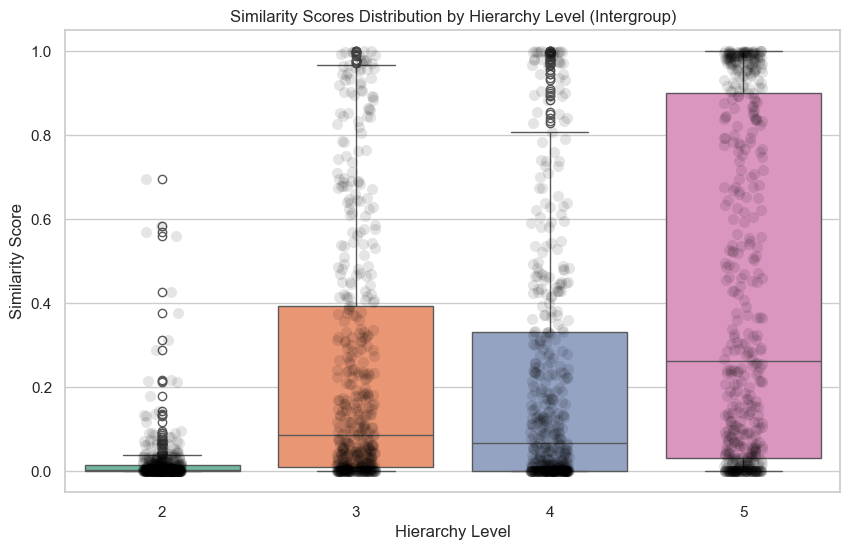

In [154]:
# Plotting Mean Similarity Score by Hierarchy Level
plt.figure(figsize=(10, 6))
sns.pointplot(x='Hierarchy_Level', y='mean', data=summary_df, join=True, capsize=.1, errwidth=1, palette='Set2')
plt.title('Mean Similarity Score by Hierarchy Level (Intergroup)')
plt.xlabel('Hierarchy Level')
plt.ylabel('Mean Similarity Score')
plt.show()

# Alternatively, use box plots with jitter and transparency
plt.figure(figsize=(10, 6))
sns.boxplot(x='Hierarchy_Level', y='Similarity_Score', data=intergroup_df, palette='Set2')
sns.stripplot(x='Hierarchy_Level', y='Similarity_Score', data=intergroup_df, color='black', alpha=0.1, jitter=True, size=8)
plt.title('Similarity Scores Distribution by Hierarchy Level (Intergroup)')
plt.xlabel('Hierarchy Level')
plt.ylabel('Similarity Score')
plt.show()

In [153]:
print(intergroup_df['Level_B'].apply(type).unique())

[<class 'int'>]


Spearman Correlation for Outer Group:
Correlation: -0.521, p-value: 0.000

There is a significant monotonic relationship between Level Difference and Similarity Score in the Outer Group.



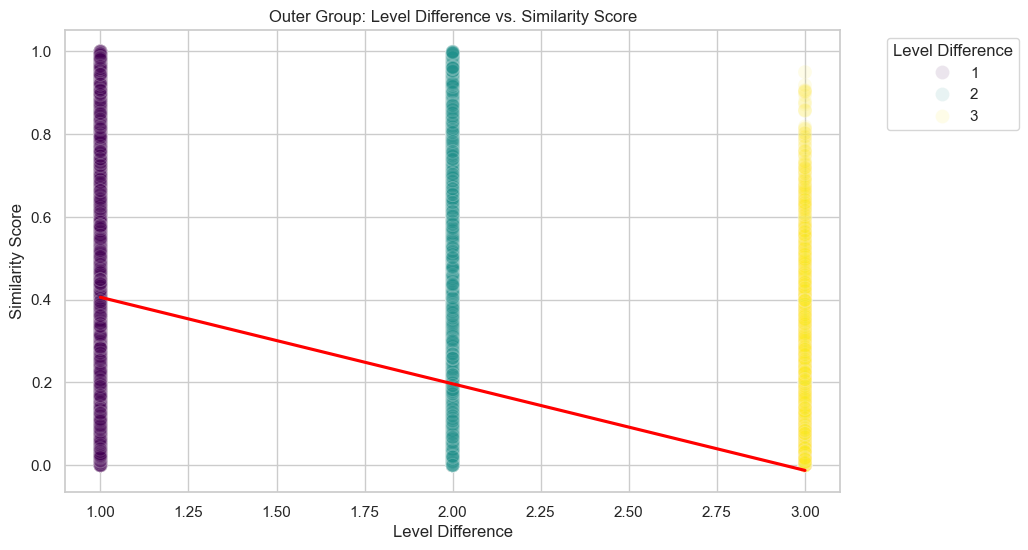

In [143]:
# Filter outer group data
outer_group_pairs = [(2,3), (2,4), (3,4), (2,5), (3,5), (4,5)]
outer_group_df = df[df['Level_Pair'].isin([f"{a},{b}" for a,b in outer_group_pairs])]

# Define a closeness metric
# Here, we'll use Avg_Level; alternatively, you can define another metric if more appropriate
# Since user mentions that (2,4),(3,4) are increasing similarity and (2,5),(3,5),(4,5) are similar around 0,
# it's better to consider a separate metric or categorize the outer group

# For simplicity, perform Spearman's correlation between Level_Difference and Similarity_Score
spearman_corr, spearman_p = stats.spearmanr(outer_group_df['Level_Difference'], outer_group_df['Similarity_Score'])
print("Spearman Correlation for Outer Group:")
print(f"Correlation: {spearman_corr:.3f}, p-value: {spearman_p:.3f}\n")

# Interpretation based on correlation
if spearman_p < 0.05:
    print("There is a significant monotonic relationship between Level Difference and Similarity Score in the Outer Group.\n")
else:
    print("No significant monotonic relationship found between Level Difference and Similarity Score in the Outer Group.\n")

# Visualization: Scatter plot with trend line
plt.figure(figsize=(10,6))
sns.scatterplot(x='Level_Difference', y='Similarity_Score', data=outer_group_df, hue='Level_Difference', palette='viridis', s=100, alpha=0.1)
sns.regplot(x='Level_Difference', y='Similarity_Score', data=outer_group_df, scatter=False, color='red')
plt.title('Outer Group: Level Difference vs. Similarity Score')
plt.xlabel('Level Difference')
plt.ylabel('Similarity Score')
plt.legend(title='Level Difference', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Spearman Correlation for Outer Group Subset 1 (2,4 and 3,4):
Correlation: -0.551, p-value: 0.000

Spearman Correlation for Outer Group Subset 2 (2,5; 3,5; 4,5):
Correlation: -0.731, p-value: 0.000



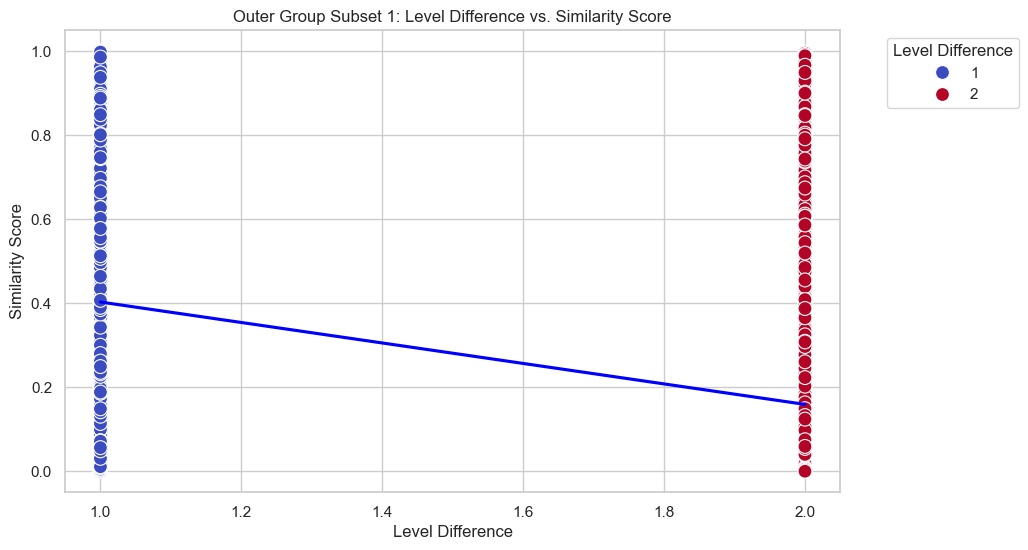

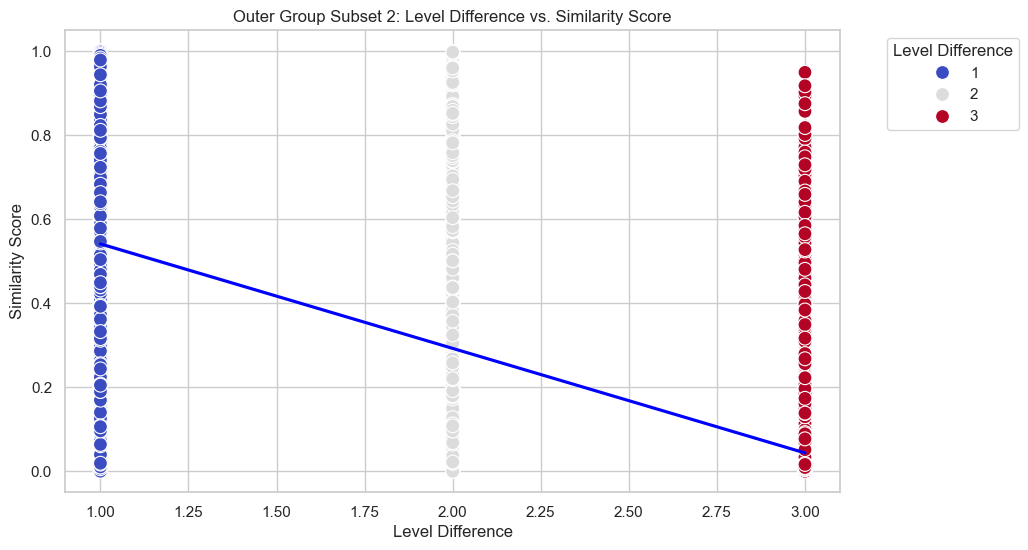

In [97]:
# Define subsets based on user observation
subset1_pairs = [(2,4), (3,4)]
subset2_pairs = [(2,5), (3,5), (4,5)]

subset1_df = outer_group_df[outer_group_df['Level_Pair'].isin([f"{a},{b}" for a,b in subset1_pairs])]
subset2_df = outer_group_df[outer_group_df['Level_Pair'].isin([f"{a},{b}" for a,b in subset2_pairs])]

# Spearman Correlation for Subset 1
spearman_corr_sub1, spearman_p_sub1 = stats.spearmanr(subset1_df['Level_Difference'], subset1_df['Similarity_Score'])
print("Spearman Correlation for Outer Group Subset 1 (2,4 and 3,4):")
print(f"Correlation: {spearman_corr_sub1:.3f}, p-value: {spearman_p_sub1:.3f}\n")

# Spearman Correlation for Subset 2
spearman_corr_sub2, spearman_p_sub2 = stats.spearmanr(subset2_df['Level_Difference'], subset2_df['Similarity_Score'])
print("Spearman Correlation for Outer Group Subset 2 (2,5; 3,5; 4,5):")
print(f"Correlation: {spearman_corr_sub2:.3f}, p-value: {spearman_p_sub2:.3f}\n")

# Visualization for Subset 1
plt.figure(figsize=(10,6))
sns.scatterplot(x='Level_Difference', y='Similarity_Score', data=subset1_df, hue='Level_Difference', palette='coolwarm', s=100)
sns.regplot(x='Level_Difference', y='Similarity_Score', data=subset1_df, scatter=False, color='blue')
plt.title('Outer Group Subset 1: Level Difference vs. Similarity Score')
plt.xlabel('Level Difference')
plt.ylabel('Similarity Score')
plt.legend(title='Level Difference', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Visualization for Subset 2
plt.figure(figsize=(10,6))
sns.scatterplot(x='Level_Difference', y='Similarity_Score', data=subset2_df, hue='Level_Difference', palette='coolwarm', s=100)
sns.regplot(x='Level_Difference', y='Similarity_Score', data=subset2_df, scatter=False, color='blue')
plt.title('Outer Group Subset 2: Level Difference vs. Similarity Score')
plt.xlabel('Level Difference')
plt.ylabel('Similarity Score')
plt.legend(title='Level Difference', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

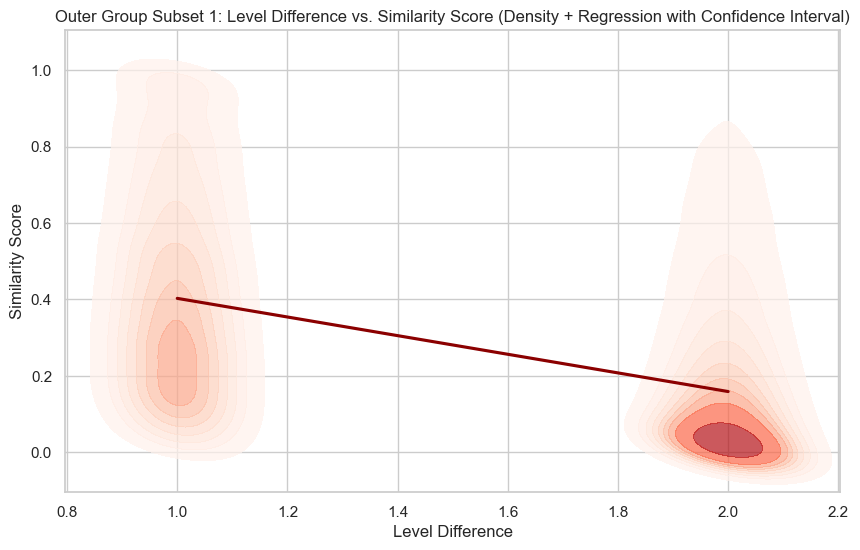

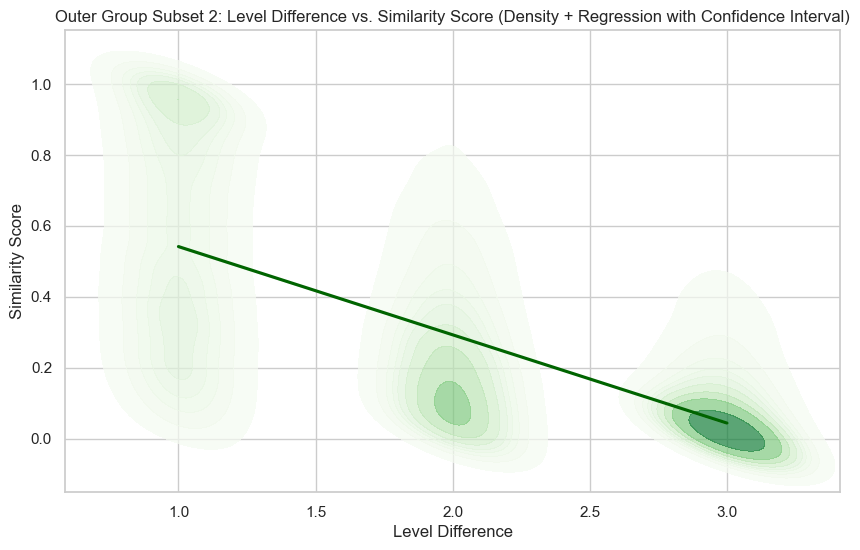

In [162]:
# Visualization for Subset 1: KDE + Regression Line with Confidence Interval
plt.figure(figsize=(10, 6))
sns.kdeplot(
    x='Level_Difference',
    y='Similarity_Score',
    data=subset1_df,
    fill=True,
    cmap='Reds',
    thresh=0.05,
    alpha=0.7
)
sns.regplot(
    x='Level_Difference',
    y='Similarity_Score',
    data=subset1_df,
    scatter=False,
    color='darkred',
    ci=95  # 95% confidence interval
)
plt.title('Outer Group Subset 1: Level Difference vs. Similarity Score (Density + Regression with Confidence Interval)')
plt.xlabel('Level Difference')
plt.ylabel('Similarity Score')
plt.show()

# Visualization for Subset 2: KDE + Regression Line with Confidence Interval
plt.figure(figsize=(10, 6))
sns.kdeplot(
    x='Level_Difference',
    y='Similarity_Score',
    data=subset2_df,
    fill=True,
    cmap='Greens',
    thresh=0.05,
    alpha=0.7
)
sns.regplot(
    x='Level_Difference',
    y='Similarity_Score',
    data=subset2_df,
    scatter=False,
    color='darkgreen',
    ci=95  # 95% confidence interval
)
plt.title('Outer Group Subset 2: Level Difference vs. Similarity Score (Density + Regression with Confidence Interval)')
plt.xlabel('Level Difference')
plt.ylabel('Similarity Score')
plt.show()

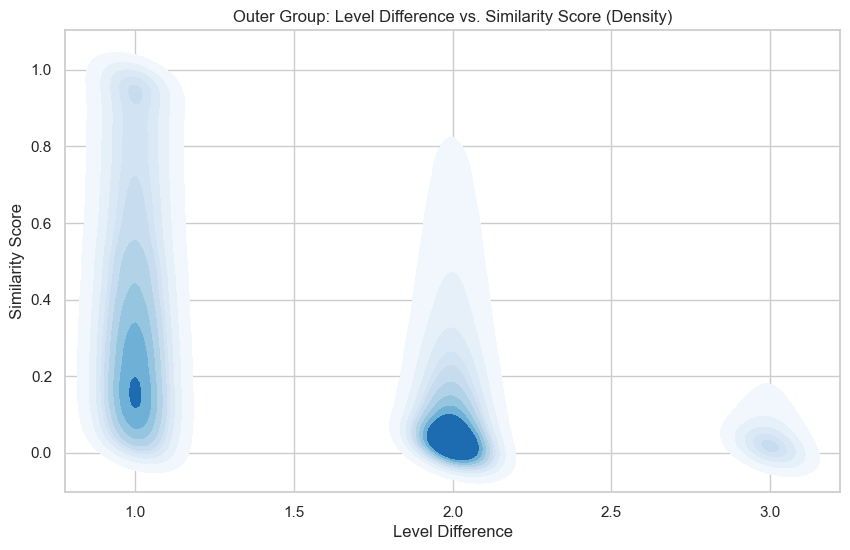

In [157]:
plt.figure(figsize=(10,6))
sns.kdeplot(x='Level_Difference', y='Similarity_Score', data=outer_group_df, fill=True, cmap='Blues', thresh=0.05)
plt.title('Outer Group: Level Difference vs. Similarity Score (Density)')
plt.xlabel('Level Difference')
plt.ylabel('Similarity Score')
plt.show()

## DreaMS

In [36]:
embeddings_dict = load_embeddings(
    file_path="/Users/macbook/CODE/Majer:MassSpecGym/data/MSn/MSn_DreaMS.h5",
    identifier_col="identifiers",
    embedding_col="embeddings"
)

In [37]:
# MS-Level Pair Analysis (embedding-based)
all_level_sims_hung = defaultdict(list)

for tree in msn_dataset.trees:
    level_sims_dict = compute_pairwise_similarity_by_mslevel(
        tree, use_embedding=True, sim_fn=None, embeddings_dict=embeddings_dict
    )
    for (lvlA, lvlB), simvals in level_sims_dict.items():
        if (lvlA, lvlB) not in all_level_sims_hung:
            all_level_sims_hung[(lvlA, lvlB)] = []
        all_level_sims_hung[(lvlA, lvlB)].extend(simvals)

In [38]:
# MS2 <-> MS2 (embedding-based) with limited pairs
ms2_sims_hung = compute_same_level_similarity_limited(
    msn_dataset,
    target_level=2,
    use_embedding=True,
    sim_fn=None,
    embeddings_dict=embeddings_dict,
    max_pairs=5000 
)

In [39]:
# Initialize (2,2) if not present
if (2, 2) not in all_level_sims_hung:
    all_level_sims_hung[(2, 2)] = []

all_level_sims_hung[(2, 2)].extend(ms2_sims_hung)

In [40]:
# Print average for each level pair
for level_pair, vals in all_level_sims_hung.items():
    stats_lv = summarize_similarity_distribution(vals)
    print(f"Level pair {level_pair} -> {stats_lv}")

Level pair (2, 3) -> {'mean': 0.36960604786872864, 'std': 0.18211105465888977, 'median': 0.35392341017723083, 'count': 71933, 'shapiro_p': nan, 'ks_p': 1.3672070184790992e-77, 'is_normal': False}
Level pair (2, 4) -> {'mean': 0.21595095098018646, 'std': 0.13768118619918823, 'median': 0.20510858297348022, 'count': 80364, 'shapiro_p': nan, 'ks_p': 2.472693430814236e-73, 'is_normal': False}
Level pair (3, 3) -> {'mean': 0.3400874137878418, 'std': 0.23485657572746277, 'median': 0.3094925582408905, 'count': 139192, 'shapiro_p': nan, 'ks_p': 0.0, 'is_normal': False}
Level pair (3, 4) -> {'mean': 0.3061775863170624, 'std': 0.22588127851486206, 'median': 0.26777011156082153, 'count': 400242, 'shapiro_p': nan, 'ks_p': 0.0, 'is_normal': False}
Level pair (4, 4) -> {'mean': 0.34772124886512756, 'std': 0.25415658950805664, 'median': 0.2987461984157562, 'count': 250039, 'shapiro_p': nan, 'ks_p': 0.0, 'is_normal': False}
Level pair (2, 5) -> {'mean': 0.21092155575752258, 'std': 0.12815092504024506, 

In [41]:
# Summarize and perform statistical tests for hungarian_fn similarities
print("\n--- Statistical Analysis for Hungarian Similarity Function ---")
comparison_results_hung = perform_statistical_tests_with_effect_sizes(all_level_sims_hung, alpha=0.05)
report_comparison_results_with_effect_sizes(comparison_results_hung)


--- Statistical Analysis for Hungarian Similarity Function ---
Group 1 Group 2           Test Used    Statistic       p-value  Adjusted Alpha  Significant  Effect Size          Effect Size Type
    2-3     2-4 Mann-Whitney U test 4.315303e+09  0.000000e+00        0.001111         True    -0.492972 Rank-Biserial Correlation
    3-3     2-2 Mann-Whitney U test 5.400329e+08  0.000000e+00        0.001111         True    -0.551908 Rank-Biserial Correlation
    3-4     4-4 Mann-Whitney U test 4.589233e+10  0.000000e+00        0.001111         True     0.082851 Rank-Biserial Correlation
    3-4     2-5 Mann-Whitney U test 3.562181e+09  0.000000e+00        0.001111         True    -0.226665 Rank-Biserial Correlation
    3-4     4-5 Mann-Whitney U test 1.755883e+10  0.000000e+00        0.001111         True     0.242442 Rank-Biserial Correlation
    3-4     5-5 Mann-Whitney U test 2.386486e+09  0.000000e+00        0.001111         True     0.500766 Rank-Biserial Correlation
    3-4     2-2 Man

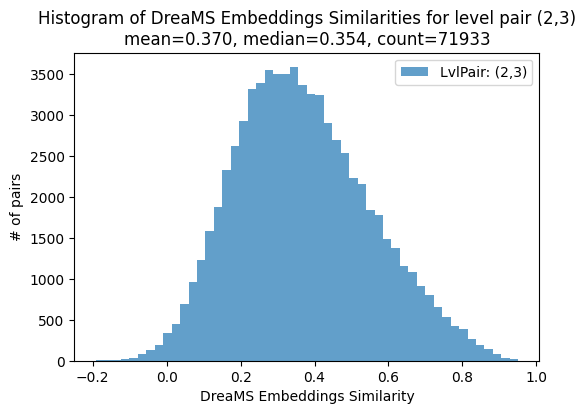

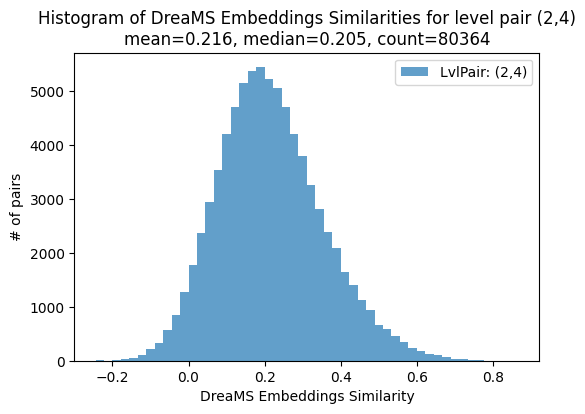

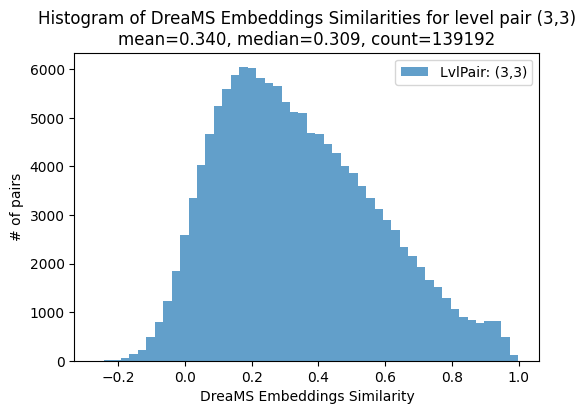

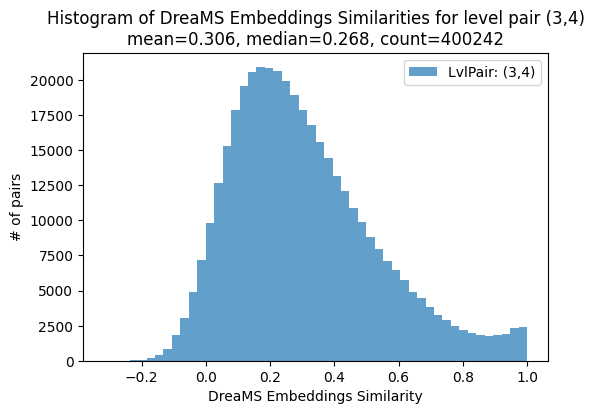

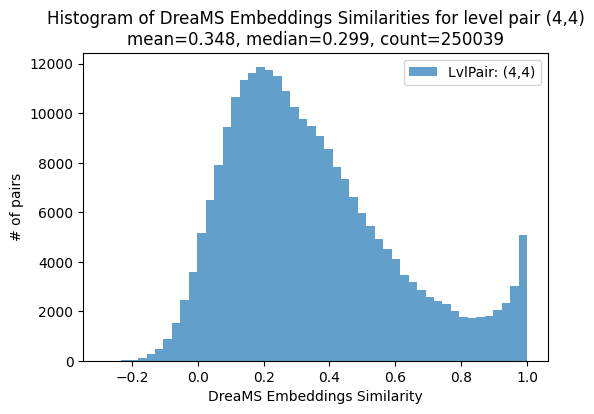

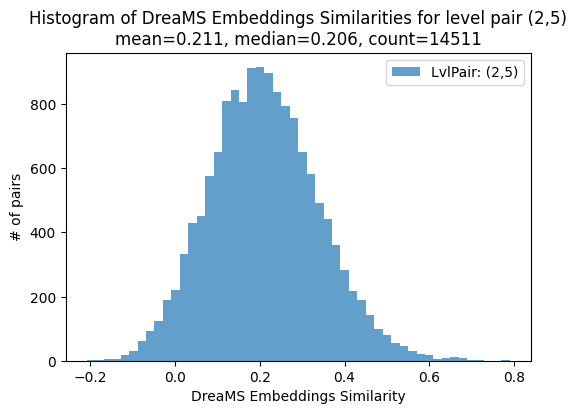

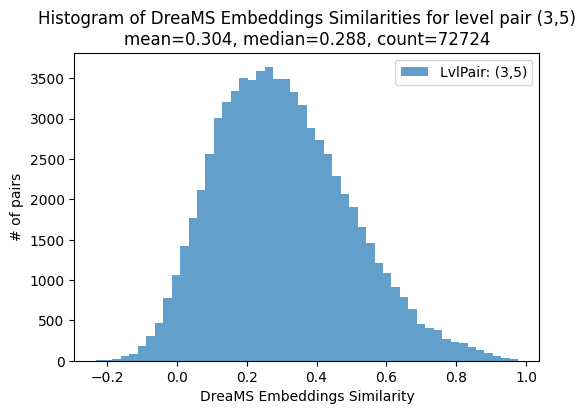

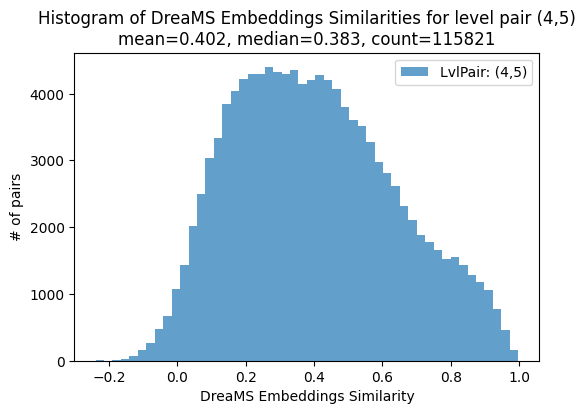

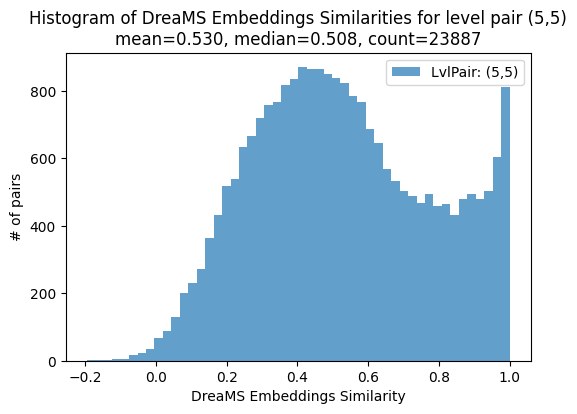

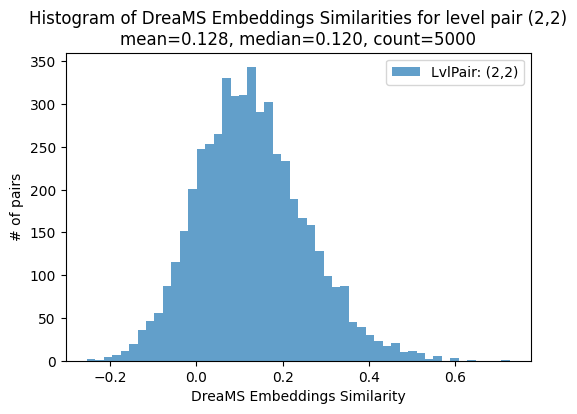

In [42]:
# Optionally plot each level pair in a separate figure:
plot_histograms_by_level_pairs(all_level_sims_hung, mode="DreaMS Embeddings")

In [14]:
def hungarian_fn(specA, specB):
    (sc, _) = compute_cosine_hungarian_score(specA, specB, tolerance=0.1)
    return (sc, 0)

ad_sims_hung = []
sib_sims_hung = []
rand_sims_hung = []

In [15]:
for tree in msn_dataset.trees:
    # Anc-Desc
    sims = compute_ancestor_descendant_similarity(
        tree, use_embedding=False, sim_fn=hungarian_fn
    )
    ad_sims_hung.extend(sims)

    # Siblings
    siblings = compute_sibling_similarity(
        tree, use_embedding=False, sim_fn=hungarian_fn
    )
    sib_sims_hung.extend(siblings)

rand_sims_hung = random_node_pairs(msn_dataset, num_pairs=5000,
                                   use_embedding=False, sim_fn=hungarian_fn)

In [16]:
stats_ad_hung = summarize_similarity_distribution(ad_sims_hung)
stats_sib_hung = summarize_similarity_distribution(sib_sims_hung)
stats_rand_hung = summarize_similarity_distribution(rand_sims_hung)

print("Ancestor-Descendant (Hungarian Cosine) stats:", stats_ad_hung)
print("Sibling (Hungarian Cosine) stats:", stats_sib_hung)
print("Random pairs (Hungarian Cosine) stats:", stats_rand_hung)

Ancestor-Descendant (Hungarian Cosine) stats: {'mean': 0.41311503931629406, 'std': 0.2766341832752525, 'median': 0.358482554701118, 'count': 166808, 'shapiro_p': nan, 'ks_p': 0.0, 'is_normal': False}
Sibling (Hungarian Cosine) stats: {'mean': 0.2600110815415143, 'std': 0.3069481175822487, 'median': 0.11463458831076889, 'count': 173661, 'shapiro_p': nan, 'ks_p': 0.0, 'is_normal': False}
Random pairs (Hungarian Cosine) stats: {'mean': 0.02776404450850912, 'std': 0.08324445757657506, 'median': 0.0015620962330701858, 'count': 5000, 'shapiro_p': 8.093267018062923e-86, 'ks_p': 0.0, 'is_normal': False}


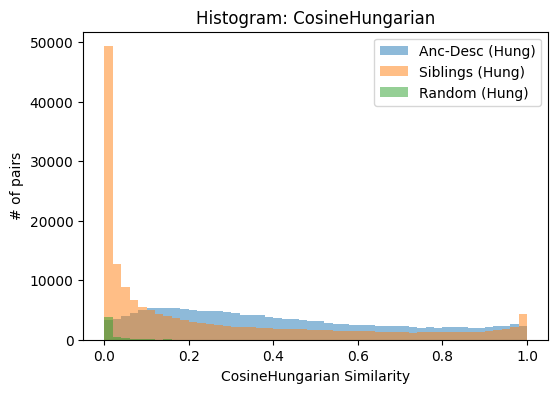

In [17]:
plot_histograms({
    "Anc-Desc (Hung)": ad_sims_hung,
    "Siblings (Hung)": sib_sims_hung,
    "Random (Hung)": rand_sims_hung
}, title="Histogram: CosineHungarian", xlabel="CosineHungarian Similarity")

In [18]:
# MS-Level Pair Analysis
all_level_sims = defaultdict(list)

for tree in msn_dataset.trees:
    level_sims_dict = compute_pairwise_similarity_by_mslevel(
        tree, use_embedding=False, sim_fn=hungarian_fn
    )
    for (lvlA, lvlB), simvals in level_sims_dict.items():
        all_level_sims[(lvlA, lvlB)].extend(simvals)


In [22]:
# Print average for each level pair
for level_pair, vals in all_level_sims.items():
    stats_lv = summarize_similarity_distribution_aggregated(vals)
    print(f"Level pair {level_pair} -> {stats_lv}")

Level pair (2, 3) -> {'mean': 0.39291368614045286, 'std': 0.29446695517700344, 'median': 0.3235879346057741, 'count': 71933}
Level pair (2, 4) -> {'mean': 0.15920017039996986, 'std': 0.2026399596469752, 'median': 0.07434368995850654, 'count': 80364}
Level pair (3, 3) -> {'mean': 0.2554785019529586, 'std': 0.31310530745819204, 'median': 0.10053266364833399, 'count': 139192}
Level pair (3, 4) -> {'mean': 0.24371597288093041, 'std': 0.29400848616911196, 'median': 0.11401620645957766, 'count': 400242}
Level pair (4, 4) -> {'mean': 0.24120319032465876, 'std': 0.32201527994996815, 'median': 0.0727915126063649, 'count': 250039}
Level pair (2, 5) -> {'mean': 0.07193860604153023, 'std': 0.11487458429477933, 'median': 0.02658169835400203, 'count': 14511}
Level pair (3, 5) -> {'mean': 0.17168872250009667, 'std': 0.22198916240377284, 'median': 0.08056879358545516, 'count': 72724}
Level pair (4, 5) -> {'mean': 0.27896573058598184, 'std': 0.3234083841746633, 'median': 0.12890938206511526, 'count': 1

In [19]:
# Perform statistical tests
comparison_results = perform_statistical_tests(all_level_sims, alpha=0.05)

# Report the results
report_comparison_results(comparison_results)

Group 1 Group 2           Test Used    Statistic       p-value  Adjusted Alpha  Significant
    2-3     2-4 Mann-Whitney U test 4.418347e+09  0.000000e+00        0.001389         True
    3-5     4-5 Mann-Whitney U test 3.736132e+09  0.000000e+00        0.001389         True
    2-5     5-5 Mann-Whitney U test 9.509983e+07  0.000000e+00        0.001389         True
    2-5     4-5 Mann-Whitney U test 5.945492e+08  0.000000e+00        0.001389         True
    2-5     3-5 Mann-Whitney U test 3.983101e+08  0.000000e+00        0.001389         True
    4-4     5-5 Mann-Whitney U test 2.233256e+09  0.000000e+00        0.001389         True
    4-4     4-5 Mann-Whitney U test 1.336197e+10  0.000000e+00        0.001389         True
    3-4     5-5 Mann-Whitney U test 3.752695e+09  0.000000e+00        0.001389         True
    3-4     3-5 Mann-Whitney U test 1.599715e+10  0.000000e+00        0.001389         True
    3-4     2-5 Mann-Whitney U test 3.800016e+09  0.000000e+00        0.001389  

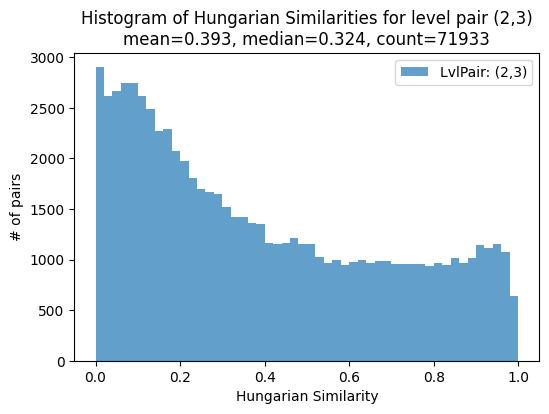

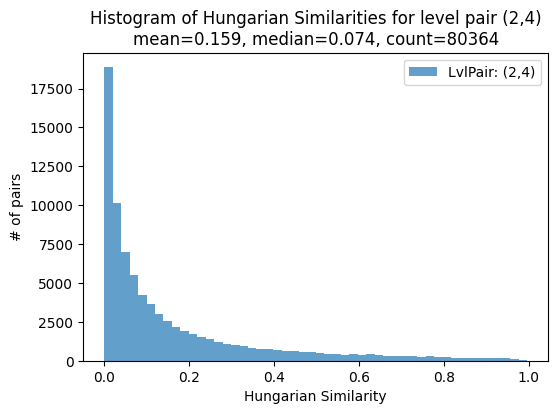

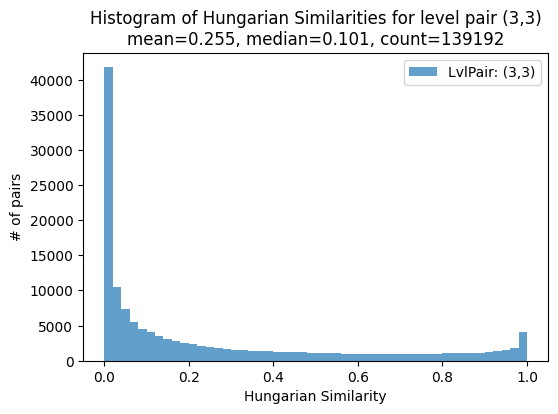

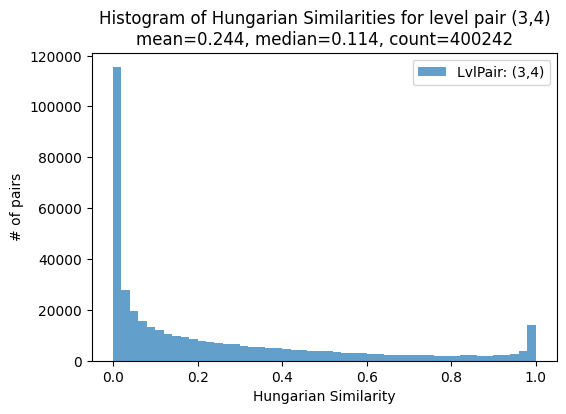

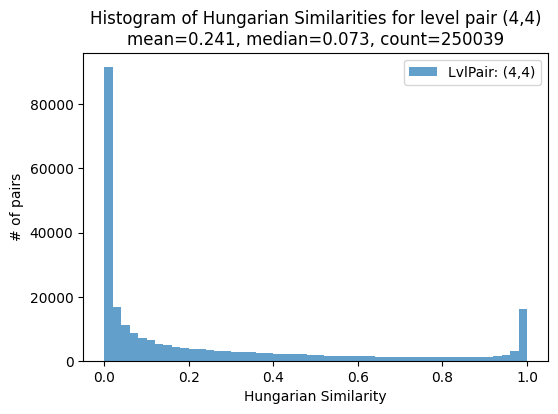

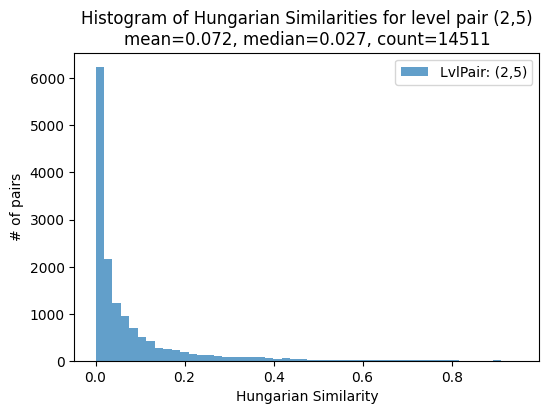

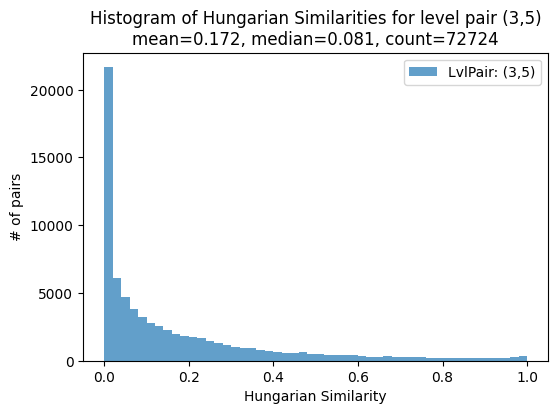

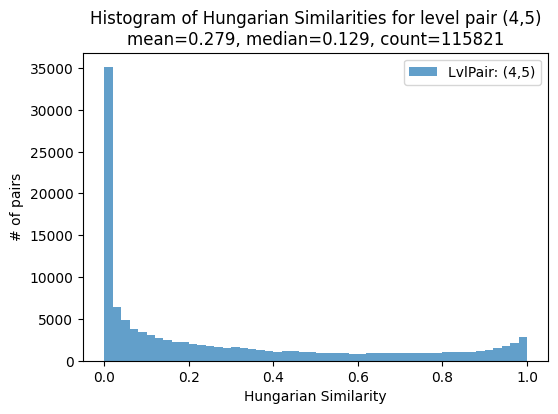

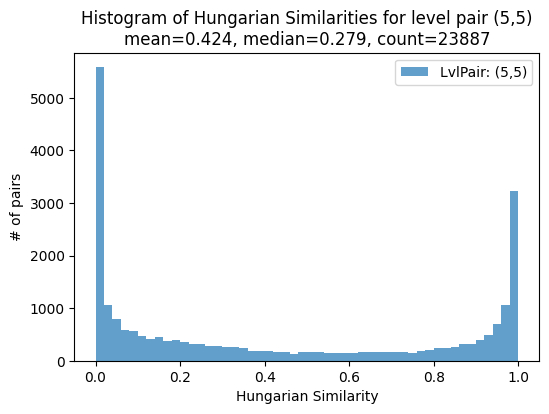

In [20]:
# Optionally plot each level pair in a separate figure:
plot_histograms_by_level_pairs(all_level_sims, mode="Hungarian")

In [25]:
# We want MS level 2 only
ms2_sims_hung = compute_same_level_similarity_limited(
    msn_dataset,
    target_level=2,
    use_embedding=False,
    sim_fn=hungarian_fn,
    tolerance=0.1,
    max_pairs=500  
)

stats_ms2_hung = summarize_similarity_distribution(ms2_sims_hung)
print("MS2<->MS2 (Hungarian) limited stats:", stats_ms2_hung)

MS2<->MS2 (Hungarian) limited stats: {'mean': 0.022353537793716256, 'std': 0.05934879960602478, 'median': 0.00456160157323064, 'count': 500}


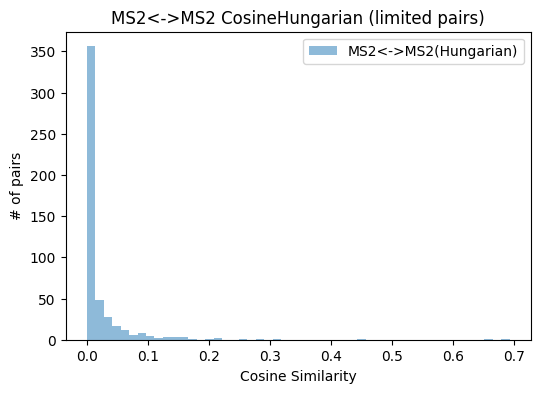

In [26]:
plot_histograms({
    "MS2<->MS2(Hungarian)": ms2_sims_hung
}, title="MS2<->MS2 CosineHungarian (limited pairs)", xlabel="Cosine Similarity")

## DreaMS embedding

In [27]:
embeddings_dict = load_embeddings(
    file_path="/Users/macbook/CODE/Majer:MassSpecGym/data/MSn/MSn_DreaMS.h5",
    identifier_col="identifiers",
    embedding_col="embeddings"
)

In [35]:
# 1) Ancestor-Descendant
embed_ad_sims = []
for tree in msn_dataset.trees:
    sims = compute_ancestor_descendant_similarity(
        tree,
        use_embedding=True,
        sim_fn=None,
        embeddings_dict=embeddings_dict
    )
    embed_ad_sims.extend(sims)
stats_ad = summarize_similarity_distribution(embed_ad_sims)

# 2) Siblings
embed_sib_sims = []
for tree in msn_dataset.trees:
    sims = compute_sibling_similarity(
        tree,
        use_embedding=True,
        sim_fn=None,
        embeddings_dict=embeddings_dict
    )
    embed_sib_sims.extend(sims)
stats_sib = summarize_similarity_distribution(embed_sib_sims)

# 3) Random pairs
embed_rand_sims = random_node_pairs(
    msn_dataset,
    num_pairs=5000,
    use_embedding=True,
    sim_fn=None,              
    embeddings_dict=embeddings_dict
)
stats_rand = summarize_similarity_distribution(embed_rand_sims)

In [36]:
print("Ancestor-Descendant (DreaMS) stats:", stats_ad)
print("Sibling (DreaMS) stats:", stats_sib)
print("Random pairs (DreaMS) stats:", stats_rand)

Ancestor-Descendant (DreaMS) stats: {'mean': 0.3994917571544647, 'std': 0.19029690325260162, 'median': 0.3847954273223877, 'count': 166808}
Sibling (DreaMS) stats: {'mean': 0.350467711687088, 'std': 0.2291901558637619, 'median': 0.3284909129142761, 'count': 173661}
Random pairs (DreaMS) stats: {'mean': 0.11952214688062668, 'std': 0.12343708425760269, 'median': 0.10753466188907623, 'count': 5000}


In [37]:
# TODO if one is signif better
stats_ad

{'mean': 0.3994917571544647,
 'std': 0.19029690325260162,
 'median': 0.3847954273223877,
 'count': 166808}

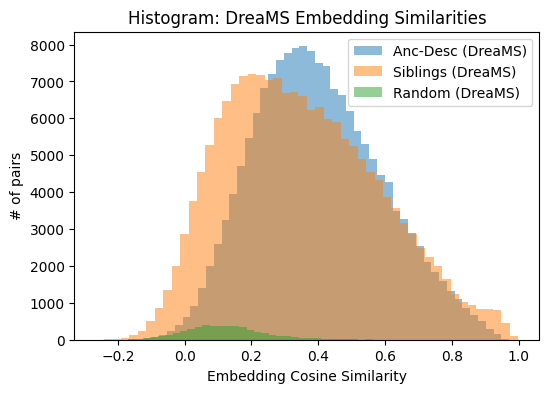

In [30]:
plot_histograms({
    "Anc-Desc (DreaMS)": embed_ad_sims,
    "Siblings (DreaMS)": embed_sib_sims,
    "Random (DreaMS)": embed_rand_sims
},
title="Histogram: DreaMS Embedding Similarities",
xlabel="Embedding Cosine Similarity")


In [31]:
# MS-Level Pair Analysis (embedding-based)
all_level_sims = {}
for tree in msn_dataset.trees:
    level_sims_dict = compute_pairwise_similarity_by_mslevel(
        tree,
        use_embedding=True,
        sim_fn=None,
        embeddings_dict=embeddings_dict
    )
    for (lvlA, lvlB), simvals in level_sims_dict.items():
        if (lvlA, lvlB) not in all_level_sims:
            all_level_sims[(lvlA, lvlB)] = []
        all_level_sims[(lvlA, lvlB)].extend(simvals)

# Print average for each level pair
for level_pair, vals in all_level_sims.items():
    stats_lv = summarize_similarity_distribution(vals)
    print(f"Level pair {level_pair} -> {stats_lv}")

Level pair (2, 3) -> {'mean': 0.36960604786872864, 'std': 0.18211105465888977, 'median': 0.35392341017723083, 'count': 71933}
Level pair (2, 4) -> {'mean': 0.21595095098018646, 'std': 0.13768118619918823, 'median': 0.20510858297348022, 'count': 80364}
Level pair (3, 3) -> {'mean': 0.3400874137878418, 'std': 0.23485657572746277, 'median': 0.3094925582408905, 'count': 139192}
Level pair (3, 4) -> {'mean': 0.3061775863170624, 'std': 0.22588127851486206, 'median': 0.26777011156082153, 'count': 400242}
Level pair (4, 4) -> {'mean': 0.34772124886512756, 'std': 0.25415658950805664, 'median': 0.2987461984157562, 'count': 250039}
Level pair (2, 5) -> {'mean': 0.21092155575752258, 'std': 0.12815092504024506, 'median': 0.20595784485340118, 'count': 14511}
Level pair (3, 5) -> {'mean': 0.3043021857738495, 'std': 0.1910751909017563, 'median': 0.2875922918319702, 'count': 72724}
Level pair (4, 5) -> {'mean': 0.40176916122436523, 'std': 0.23634786903858185, 'median': 0.3825491964817047, 'count': 1158

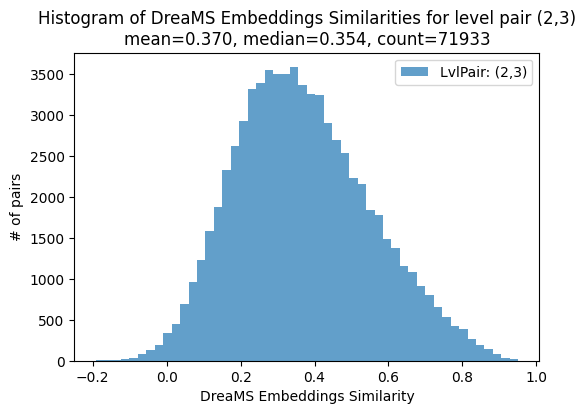

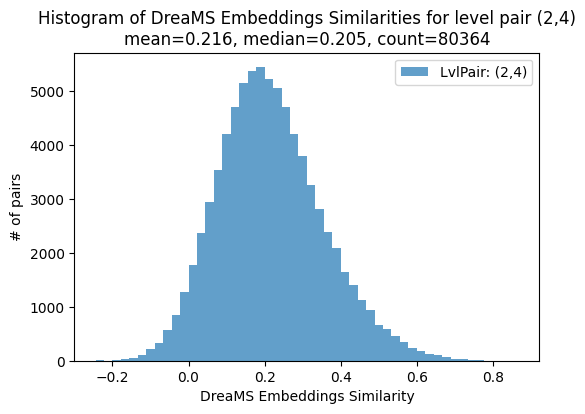

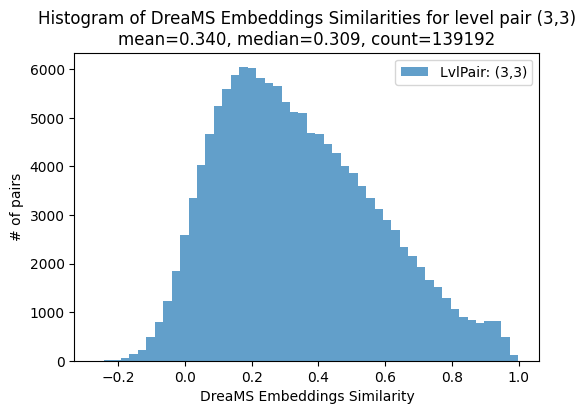

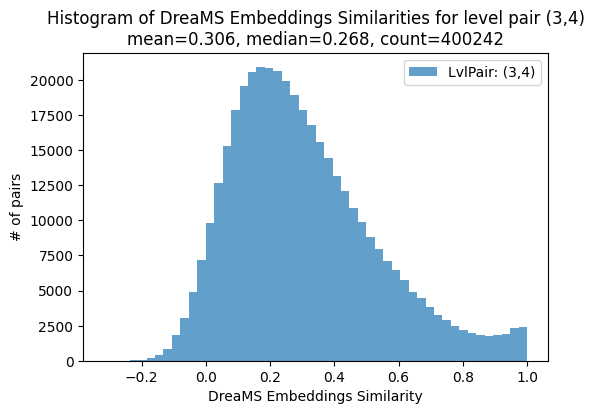

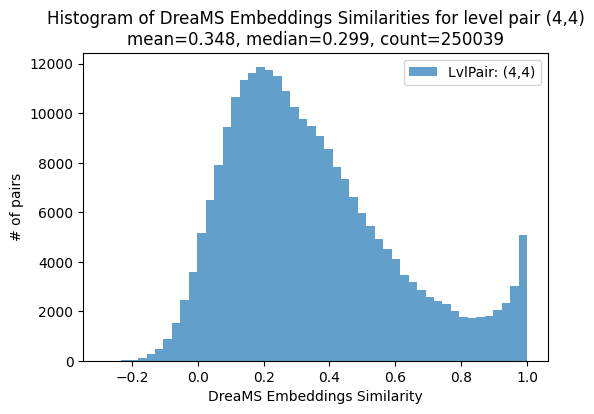

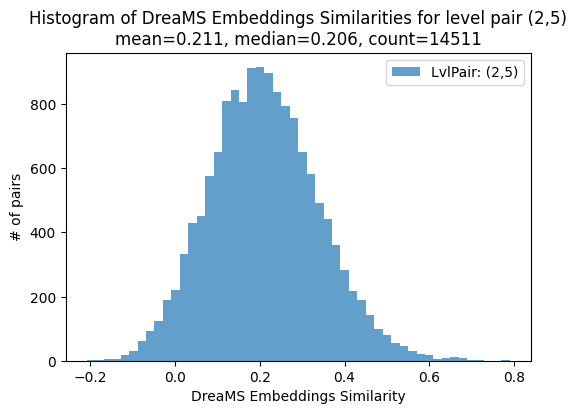

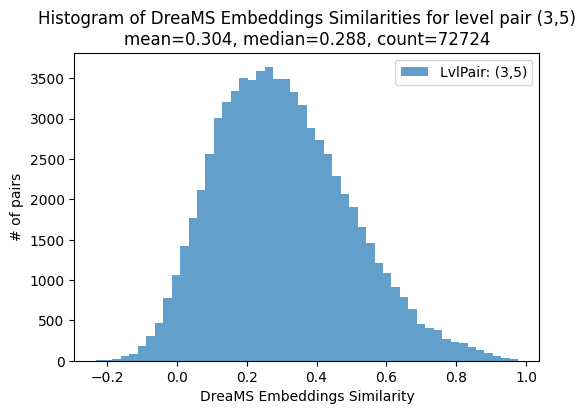

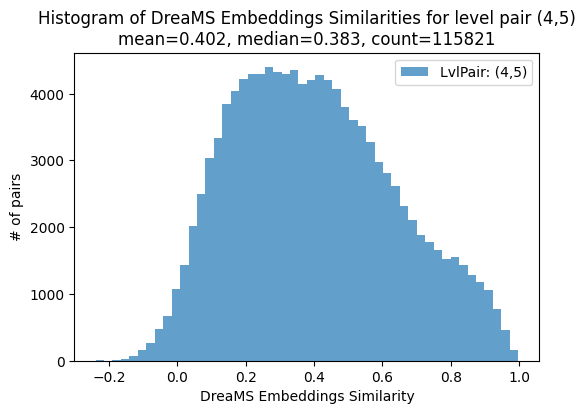

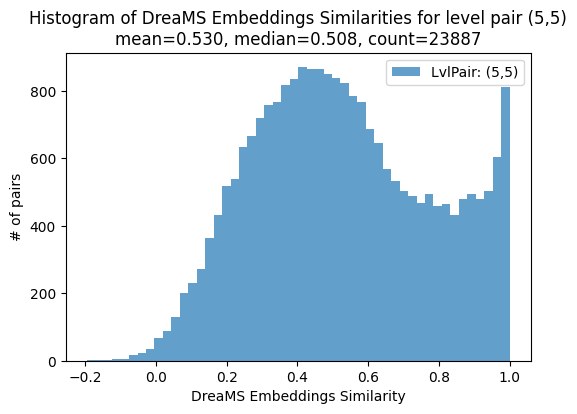

In [32]:
# Plot each level pair in a separate figure
plot_histograms_by_level_pairs(all_level_sims, mode="DreaMS Embeddings")

In [33]:
# MS2 <-> MS2 (embedding-based) with limited pairs
ms2_sims_emb = compute_same_level_similarity_limited(
    msn_dataset,
    target_level=2,
    use_embedding=True,
    sim_fn=None,  # => dreams_embedding_similarity
    embeddings_dict=embeddings_dict,
    max_pairs=5000   
)
stats_ms2_emb = summarize_similarity_distribution(ms2_sims_emb)
print("MS2<->MS2 (DreaMS embeddings) limited stats:", stats_ms2_emb)

MS2<->MS2 (DreaMS embeddings) limited stats: {'mean': 0.12317246198654175, 'std': 0.12449826300144196, 'median': 0.11809742450714111, 'count': 5000}


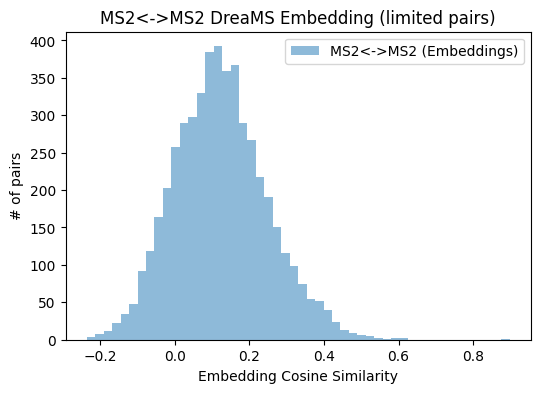

In [34]:
plot_histograms({
    "MS2<->MS2 (Embeddings)": ms2_sims_emb
}, title="MS2<->MS2 DreaMS Embedding (limited pairs)", xlabel="Embedding Cosine Similarity")